In [1]:
# Initialize a new VAME project
import vame
import functions_bondjango as bd
import functions_vame as fv
import paths
import random
import os
import shutil
import h5py
import numpy as np

Using CUDA
GPU active: True
GPU used: GeForce RTX 2080 Ti


In [2]:
# Manually define the config path if project has already been created
# config = r"D:\VAME_projects\VAME_prey_6-Apr28-2021\config.yaml"
# config = r"D:\VAME_projects\VAME_prey_7-Apr29-2021\config.yaml"
# config = r"D:\VAME_projects\VAME_prey_15dim-May2-2021\config.yaml"
config = r"D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\config.yaml"

In [3]:
%%time
# get the file paths

# define the number of files to use
number_files = 0
# define the search string
# search_string = ['rig:miniscope, result:succ', 'rig:miniscope, result:fail']
search_string = ['rig:miniscope']

# define the target model
target_model = 'video_experiment'

# allocate memory for the files
files = []

# for all the queries
for query in search_string:
    # get the queryset
    files.append(bd.query_database(target_model, query))

# concatenate the list
files_list = [item for sublist in files for item in sublist]

# allocate memory for the cleaned up files and analysis paths
files = []
analysis_paths = []
# get rid of the files that are too short for pose segmentation
# for all the files
for el in files_list:
    # get the path to the analyzed data file
    dlc_path = el['avi_path']
    dlc_path = dlc_path.replace('.avi', '_preproc.hdf5')
    dlc_path = dlc_path.replace('VideoExperiment', 'AnalyzedData')
    dlc_path = dlc_path.replace('VRExperiment', 'AnalyzedData')
    # open the file using h5py, as can't install pytables in this env
    with h5py.File(dlc_path, 'r') as f:
        # parse the bounds from the file
        bounds = np.array(f['frame_bounds/block0_values'])[0]
#         values = np.array(f['frame_bounds/block0_values'])[0]
#         labels = np.array(f['frame_bounds/block0_items']).astype(str)
#         bounds = pd.DataFrame(values.reshape([1, 3]), columns=labels)
        # add the file to the final list only if it's long enough
#         if (bounds.loc[0, 'end'] - bounds.loc[0, 'start']) > 50:
        if (bounds[1] - bounds[0]) > 50:
            files.append(el)
            analysis_paths.append(dlc_path)

if number_files > 0:
    # pick a random subset of number_files
    files = random.sample(files, number_files)

# get the video paths in a list
video_paths = [el['avi_path'] for el in files]

# define the working directory
working_directory = paths.vame_path

Wall time: 14.5 s


In [4]:
# print(files[0]['preproc_files'][0])

# dlc_path = files[0]['avi_path']
# dlc_path = dlc_path.replace('.avi', '_preproc.hdf5')
# dlc_path = dlc_path.replace('VideoExperiment', 'AnalyzedData')
# dlc_path = dlc_path.replace('VRExperiment', 'AnalyzedData')
# print(dlc_path)

In [3]:
# %%time

# # initialize the project
# config = vame.init_new_project(project='VAME_prey_mouse15dim', 
#                                videos=video_paths, working_directory=working_directory, videotype='.avi')

Created "D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\videos"
Created "D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\data"
Created "D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results"
Created "D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\model"
Copying the videos 

A VAME project has been created. 

Now its time to prepare your data for VAME. The first step is to move your pose .csv file (e.g. DeepLabCut .csv) into the //YOUR//VAME//PROJECT//videos//pose_estimation folder. From here you can call either the function vame.egocentric_alignment() or if your data is by design egocentric call vame.csv_to_numpy(). This will prepare the data in .csv into the right format to start working with VAME.
Wall time: 2min 8s


In [4]:
%%time
# Align video trajectories

# get the project folder
project_folder, _ = os.path.split(config)

# for all the videos
for idx, el in enumerate(files):
    print(f'Current file: {el["slug"]}')
    
#     # if there is no preprocessing file, skip and warn
#     if len(el['preproc_files']) == 0:
#         print('no preprocessing file found')
#         continue
#     # load the avi file path
#     dlc_path = el['avi_path']
#     # edit it for the preprocessing path
#     dlc_path = dlc_path.replace('.avi', '_preproc.hdf5')
#     dlc_path = dlc_path.replace('VideoExperiment', 'AnalyzedData')
#     dlc_path = dlc_path.replace('VRExperiment', 'AnalyzedData')
    # get the path from the list calculated above
    dlc_path = analysis_paths[idx]
    # define the cropping
    crop_size = (1, 1)
    # egocentrically align the data and save
    fv.run_alignment(dlc_path, project_folder, '.avi', crop_size)

Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [00:00<00:00, 7477.50it/s]

Current file: 04_02_2021_10_34_47_miniscope_dg_210202_a_succ
Current file: 04_02_2021_10_30_38_miniscope_dg_210202_a_succ



Align frames:   0%|                                                                                                                                                                                               | 0/738 [00:00<?, ?it/s]

Current file: 04_02_2021_10_25_41_miniscope_dg_210202_a_succ
Current file: 04_02_2021_10_21_22_miniscope_dg_210202_a_succ
Current file: 04_02_2021_10_16_10_miniscope_dg_210202_a_succ


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1510/1510 [00:00<00:00, 8868.13it/s]

Current file: 04_02_2021_10_10_35_miniscope_dg_210202_a_succ



Align frames:   0%|                                                                                                                                                                                               | 0/515 [00:00<?, ?it/s]

Current file: 04_02_2021_10_06_47_miniscope_dg_210202_a_succ
Current file: 04_02_2021_10_03_36_miniscope_dg_210202_a_succ
Current file: 04_01_2021_09_59_45_miniscope_dg_210202_a_succ_injured


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 6572.43it/s]

Current file: 04_01_2021_09_55_30_miniscope_dg_210202_a_succ
Current file: 04_01_2021_09_51_46_miniscope_dg_210202_a_succ



Align frames:   0%|                                                                                                                                                                                               | 0/510 [00:00<?, ?it/s]

Current file: 04_01_2021_09_47_53_miniscope_dg_210202_a_succ
Current file: 04_01_2021_09_43_29_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/162 [00:00<?, ?it/s]

Current file: 04_01_2021_09_38_38_miniscope_dg_210202_a_succ
Current file: 04_01_2021_09_35_49_miniscope_dg_210202_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 516/516 [00:00<00:00, 7882.57it/s]

Current file: 04_01_2021_09_31_49_miniscope_dg_210202_a_succ_grabbedcable
Current file: 03_31_2021_09_49_31_miniscope_dg_210202_a_succ
Current file: 03_31_2021_09_45_11_miniscope_dg_210202_a_succ



Align frames:   0%|                                                                                                                                                                                               | 0/805 [00:00<?, ?it/s]

Current file: 03_31_2021_09_38_46_miniscope_dg_210202_a_succ
Current file: 03_31_2021_09_35_52_miniscope_dg_210202_a_succ
Current file: 03_31_2021_09_32_31_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/726 [00:00<?, ?it/s]

Current file: 03_31_2021_09_26_57_miniscope_dg_210202_a_succ
Current file: 03_31_2021_09_23_53_miniscope_dg_210202_a_succ


Align frames:   0%|                                                                                                                                                                                              | 0/2943 [00:00<?, ?it/s]

Current file: 03_31_2021_09_19_18_miniscope_dg_210202_a_succ
Current file: 03_30_2021_09_51_19_miniscope_dg_210202_a_succ


Align frames:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1095/1975 [00:00<00:00, 10869.67it/s]

Current file: 03_30_2021_09_46_33_miniscope_dg_210202_a_succ_injured


Align frames:  43%|███████████████████████████████████████████████████████████████████████████▋                                                                                                      | 780/1834 [00:00<00:00, 7780.16it/s]

Current file: 03_30_2021_09_41_12_miniscope_dg_210202_a_succ


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1235/1235 [00:00<00:00, 8033.38it/s]

Current file: 03_30_2021_09_36_54_miniscope_dg_210202_a_succ
Current file: 03_30_2021_09_33_30_miniscope_dg_210202_a_succ_injured



Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1339/1339 [00:00<00:00, 8466.16it/s]

Current file: 03_30_2021_09_27_31_miniscope_dg_210202_a_succ_cutearly
Current file: 03_30_2021_09_21_05_miniscope_dg_210202_a_succ_injured



Align frames:   0%|                                                                                                                                                                                              | 0/2193 [00:00<?, ?it/s]

Current file: 03_30_2021_09_16_35_miniscope_dg_210202_a_succ_injured
Current file: 03_29_2021_10_13_07_miniscope_dg_210202_a_succ


Align frames:  13%|██████████████████████▊                                                                                                                                                           | 498/3878 [00:00<00:00, 4935.23it/s]

Current file: 03_29_2021_10_04_21_miniscope_dg_210202_a_succ


Align frames:  31%|███████████████████████████████████████████████████████                                                                                                                           | 762/2464 [00:00<00:00, 7551.77it/s]

Current file: 03_29_2021_09_56_46_miniscope_dg_210202_a_succ


Align frames:  24%|█████████████████████████████████████████▉                                                                                                                                        | 681/2887 [00:00<00:00, 6802.98it/s]

Current file: 03_29_2021_09_49_44_miniscope_dg_210202_a_succ


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1244/1244 [00:00<00:00, 9238.85it/s]

Current file: 03_29_2021_09_43_54_miniscope_dg_210202_a_succ
Current file: 03_29_2021_09_37_03_miniscope_dg_210202_a_succ



Align frames:  16%|███████████████████████████▋                                                                                                                                                      | 722/4635 [00:00<00:00, 7212.89it/s]

Current file: 03_29_2021_09_25_44_miniscope_dg_210202_a_succ


Align frames:  17%|██████████████████████████████▏                                                                                                                                                   | 841/4952 [00:00<00:00, 8352.52it/s]

Current file: 03_29_2021_09_17_07_miniscope_dg_210202_a_succ
Current file: 03_26_2021_09_00_53_miniscope_dg_210202_a_fail_nonres_attempts


Align frames:  14%|████████████████████████▎                                                                                                                                                         | 691/5047 [00:00<00:00, 6883.80it/s]

Current file: 03_26_2021_08_53_20_miniscope_dg_210202_a_fail_nonres_attempts


Align frames:  19%|██████████████████████████████████▍                                                                                                                                               | 974/5039 [00:00<00:00, 9651.46it/s]

Current file: 03_26_2021_08_45_47_miniscope_dg_210202_a_fail_nonres_attempts


Align frames:  15%|██████████████████████████▌                                                                                                                                                       | 746/5009 [00:00<00:00, 7452.86it/s]

Current file: 03_26_2021_08_38_53_miniscope_dg_210202_a_fail_nonres_attempts


Align frames:   0%|                                                                                                                                                                                              | 0/1528 [00:00<?, ?it/s]

Current file: 03_25_2021_09_52_28_miniscope_dg_210202_a_fail_nonres_attempts
Current file: 03_25_2021_09_45_37_miniscope_dg_210202_a_fail_nonres_attempts


Align frames:  31%|███████████████████████████████████████████████████████▌                                                                                                                          | 827/2648 [00:00<00:00, 8263.13it/s]

Current file: 03_25_2021_09_36_59_miniscope_dg_210202_a_fail_nonres_attempts


Align frames:  10%|█████████████████                                                                                                                                                                 | 484/5052 [00:00<00:00, 4811.70it/s]

Current file: 03_25_2021_09_29_46_miniscope_dg_210202_a_fail_nonres_attempts


Align frames:   0%|                                                                                                                                                                                              | 0/3396 [00:00<?, ?it/s]

Current file: 03_24_2021_13_59_13_miniscope_dg_210202_a_fail_nonres_attempts
Current file: 03_24_2021_13_52_36_miniscope_dg_210202_a_fail_nonres


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1071/1071 [00:00<00:00, 7250.95it/s]

Current file: 03_24_2021_13_45_32_miniscope_dg_210202_a_fail_nonres
Current file: 03_24_2021_13_38_36_miniscope_dg_210202_a_fail_nonres



Align frames:   0%|                                                                                                                                                                                               | 0/401 [00:00<?, ?it/s]

Current file: 03_23_2021_07_36_47_miniscope_dg_210202_a_habi
Current file: 03_23_2021_07_28_32_miniscope_dg_210202_a_habi


Align frames:  23%|█████████████████████████████████████████▌                                                                                                                                        | 665/2846 [00:00<00:00, 6643.91it/s]

Current file: 03_23_2021_07_22_20_miniscope_dg_210202_a_habi


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1472/1472 [00:00<00:00, 7996.67it/s]

Current file: 03_23_2021_07_15_34_miniscope_dg_210202_a_habi



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 345/345 [00:00<00:00, 8050.44it/s]

Current file: 03_22_2021_10_01_27_miniscope_dg_210202_a_habi
Current file: 03_22_2021_09_55_17_miniscope_dg_210202_a_habi



Align frames:   0%|                                                                                                                                                                                              | 0/1090 [00:00<?, ?it/s]

Current file: 03_22_2021_09_49_08_miniscope_dg_210202_a_habi
Current file: 03_22_2021_09_42_53_miniscope_dg_210202_a_habi


Align frames:   0%|                                                                                                                                                                                              | 0/5023 [00:00<?, ?it/s]

Current file: 03_22_2021_09_26_19_miniscope_dg_210202_a_habi_smallfluo
Current file: 03_22_2021_09_19_25_miniscope_dg_210202_a_habi_smallfluo


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1015/1015 [00:00<00:00, 6777.50it/s]


Current file: 03_19_2021_07_37_05_miniscope_dg_210202_a_habi_badfluo
Current file: 03_19_2021_07_30_40_miniscope_dg_210202_a_habi_badfluo


Align frames:  42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                        | 858/2066 [00:00<00:00, 8579.37it/s]

Current file: 03_19_2021_07_24_15_miniscope_dg_210202_a_habi_badfluo


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 2819.28it/s]

Current file: 03_19_2021_07_17_14_miniscope_dg_210202_a_habi_badfluo
Current file: 03_18_2021_09_45_56_miniscope_dg_210202_a_habi_badfov
Current file: 03_18_2021_09_39_24_miniscope_dg_210202_a_habi_badfov



Align frames:   0%|                                                                                                                                                                                              | 0/1733 [00:00<?, ?it/s]

Current file: 03_18_2021_09_32_46_miniscope_dg_210202_a_habi_badfov
Current file: 03_18_2021_09_25_02_miniscope_dg_210202_a_habi_badfov


Align frames:   9%|████████████████▌                                                                                                                                                                 | 457/4913 [00:00<00:00, 4531.18it/s]

Current file: 03_17_2021_09_47_02_miniscope_dg_210202_a_habi_nofluo


Align frames:  11%|███████████████████▏                                                                                                                                                              | 533/4930 [00:00<00:00, 5282.56it/s]

Current file: 03_17_2021_09_35_32_miniscope_dg_210202_a_habi_nofluo


Align frames:  15%|██████████████████████████                                                                                                                                                        | 731/4995 [00:00<00:00, 7304.47it/s]

Current file: 03_17_2021_09_28_35_miniscope_dg_210202_a_habi_nofluo


Align frames:   8%|██████████████                                                                                                                                                                    | 397/5039 [00:00<00:01, 3958.29it/s]

Current file: 03_17_2021_09_21_23_miniscope_dg_210202_a_habi_nofluo


Align frames:  11%|███████████████████▊                                                                                                                                                              | 441/3960 [00:00<00:00, 4381.55it/s]

Current file: 03_16_2021_10_17_47_miniscope_dg_210202_a_habi_nofluo


Align frames:  14%|████████████████████████▊                                                                                                                                                         | 727/5221 [00:00<00:00, 7227.99it/s]

Current file: 03_16_2021_10_11_02_miniscope_dg_210202_a_habi_nofluo


Align frames:  14%|████████████████████████                                                                                                                                                          | 656/4857 [00:00<00:00, 6501.34it/s]

Current file: 03_16_2021_10_00_55_miniscope_dg_210202_a_habi_nofluo


Align frames:  35%|█████████████████████████████████████████████████████████████▌                                                                                                                  | 1182/3382 [00:00<00:00, 11734.26it/s]

Current file: 03_16_2021_09_53_54_miniscope_dg_210202_a_habi_nofluo


Align frames:  15%|███████████████████████████▌                                                                                                                                                      | 764/4945 [00:00<00:00, 7564.87it/s]

Current file: 03_15_2021_10_57_23_miniscope_dg_210202_a_habi_nomini


Align frames:  14%|████████████████████████▉                                                                                                                                                         | 668/4773 [00:00<00:00, 6616.98it/s]

Current file: 03_15_2021_10_50_53_miniscope_dg_210202_a_habi_nomini


Align frames:  14%|████████████████████████▊                                                                                                                                                         | 683/4909 [00:00<00:00, 6807.01it/s]

Current file: 03_15_2021_10_43_36_miniscope_dg_210202_a_habi_nomini


Align frames:  13%|███████████████████████▋                                                                                                                                                          | 646/4847 [00:00<00:00, 6413.11it/s]

Current file: 03_15_2021_10_35_50_miniscope_dg_210202_a_habi_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/183 [00:00<?, ?it/s]

Current file: 09_08_2020_15_56_34_miniscope_dg_200617_b_succ_injured_nofluo
Current file: 09_08_2020_15_54_36_miniscope_dg_200617_b_succ
Current file: 09_08_2020_15_50_32_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:00<00:00, 5616.06it/s]

Current file: 09_08_2020_15_47_44_miniscope_dg_200617_b_succ
Current file: 09_08_2020_15_39_45_miniscope_dg_200617_b_succ
Current file: 09_08_2020_15_36_13_miniscope_dg_200617_b_succ_injured



Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 3812.37it/s]

Current file: 09_08_2020_15_32_30_miniscope_dg_200617_b_succ
Current file: 09_08_2020_15_26_21_miniscope_dg_200701_a_succ
Current file: 09_08_2020_15_23_32_miniscope_dg_200701_a_succ
Current file: 09_08_2020_15_20_34_miniscope_dg_200701_a_succ
Current file: 09_08_2020_15_16_25_miniscope_dg_200701_a_succ



Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 3768.82it/s]

Current file: 09_08_2020_15_13_51_miniscope_dg_200701_a_succ
Current file: 09_08_2020_15_10_07_miniscope_dg_200701_a_succ
Current file: 09_08_2020_15_06_13_miniscope_dg_200701_a_succ
Current file: 09_08_2020_15_03_49_miniscope_dg_200701_a_succ_nomini



Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 3955.21it/s]

Current file: 09_08_2020_15_00_07_miniscope_dg_200701_a_succ
Current file: 09_07_2020_15_41_46_miniscope_dg_200617_b_succ
Current file: 09_07_2020_15_38_41_miniscope_dg_200617_b_succ
Current file: 09_07_2020_15_29_47_miniscope_dg_200617_b_succ
Current file: 09_07_2020_15_26_46_miniscope_dg_200617_b_succ
Current file: 09_07_2020_15_23_07_miniscope_dg_200617_b_succ



Align frames:   0%|                                                                                                                                                                                               | 0/114 [00:00<?, ?it/s]

Current file: 09_07_2020_15_18_17_miniscope_dg_200617_b_succ
Current file: 09_07_2020_15_02_53_miniscope_dg_200701_a_succ
Current file: 09_07_2020_14_59_11_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 2616.66it/s]

Current file: 09_07_2020_14_53_42_miniscope_dg_200701_a_succ
Current file: 09_07_2020_14_51_32_miniscope_dg_200701_a_succ
Current file: 09_07_2020_14_48_19_miniscope_dg_200701_a_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 2958.38it/s]


Current file: 09_07_2020_14_45_29_miniscope_dg_200701_a_succ
Current file: 09_07_2020_14_42_14_miniscope_dg_200701_a_succ_injured
Current file: 09_06_2020_15_51_43_miniscope_dg_200617_b_succ
Current file: 09_06_2020_15_47_33_miniscope_dg_200617_b_succ_injured


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 3986.78it/s]


Current file: 09_06_2020_15_43_13_miniscope_dg_200617_b_succ
Current file: 09_06_2020_15_35_22_miniscope_dg_200617_b_succ
Current file: 09_06_2020_15_28_50_miniscope_dg_200617_b_succ
Current file: 09_06_2020_15_25_10_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/158 [00:00<?, ?it/s]

Current file: 09_06_2020_15_18_22_miniscope_dg_200701_a_succ
Current file: 09_06_2020_15_14_12_miniscope_dg_200701_a_succ
Current file: 09_06_2020_15_11_37_miniscope_dg_200701_a_succ
Current file: 09_06_2020_15_09_11_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 8533.75it/s]


Current file: 09_06_2020_15_05_22_miniscope_dg_200701_a_succ
Current file: 09_06_2020_15_02_17_miniscope_dg_200701_a_succ
Current file: 09_06_2020_14_58_24_miniscope_dg_200701_a_succ
Current file: 09_06_2020_14_55_10_miniscope_dg_200701_a_succ_injured
Current file: 09_05_2020_16_26_47_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/170 [00:00<?, ?it/s]

Current file: 09_05_2020_16_23_03_miniscope_dg_200617_b_succ
Current file: 09_05_2020_16_19_09_miniscope_dg_200617_b_succ
Current file: 09_05_2020_16_16_21_miniscope_dg_200617_b_succ
Current file: 09_05_2020_16_12_58_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3038.73it/s]


Current file: 09_05_2020_16_09_14_miniscope_dg_200617_b_succ
Current file: 09_05_2020_15_59_18_miniscope_dg_200701_a_succ
Current file: 09_05_2020_15_56_40_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/117 [00:00<?, ?it/s]

Current file: 09_05_2020_15_52_46_miniscope_dg_200701_a_succ
Current file: 09_05_2020_15_50_02_miniscope_dg_200701_a_succ
Current file: 09_05_2020_15_47_48_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 3864.99it/s]

Current file: 09_05_2020_15_45_35_miniscope_dg_200701_a_succ_injured
Current file: 09_05_2020_15_40_48_miniscope_dg_200701_a_succ_injured
Current file: 09_04_2020_17_26_53_miniscope_dg_200617_b_succ
Current file: 09_04_2020_17_23_03_miniscope_dg_200617_b_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:00<00:00, 4421.65it/s]

Current file: 09_04_2020_17_17_48_miniscope_dg_200617_b_succ
Current file: 09_04_2020_17_14_08_miniscope_dg_200617_b_succ
Current file: 09_04_2020_17_07_37_miniscope_dg_200617_b_succ_injured



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 4248.82it/s]

Current file: 09_04_2020_17_03_57_miniscope_dg_200617_b_succ
Current file: 09_04_2020_17_00_52_miniscope_dg_200617_b_succ
Current file: 09_04_2020_16_52_56_miniscope_dg_200701_a_succ
Current file: 09_04_2020_16_46_11_miniscope_dg_200701_a_succ_distractedbytrash



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 3939.98it/s]

Current file: 09_04_2020_16_43_01_miniscope_dg_200701_a_succ
Current file: 09_04_2020_16_39_31_miniscope_dg_200701_a_succ
Current file: 09_04_2020_16_35_52_miniscope_dg_200701_a_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 3084.91it/s]


Current file: 09_04_2020_16_33_29_miniscope_dg_200701_a_succ
Current file: 09_04_2020_16_30_05_miniscope_dg_200701_a_succ_injured
Current file: 09_03_2020_16_40_53_miniscope_dg_200617_b_succ
Current file: 09_03_2020_16_36_15_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/118 [00:00<?, ?it/s]

Current file: 09_03_2020_16_31_10_miniscope_dg_200617_b_succ
Current file: 09_03_2020_16_28_25_miniscope_dg_200617_b_succ
Current file: 09_03_2020_16_24_34_miniscope_dg_200617_b_succ
Current file: 09_03_2020_16_21_39_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/113 [00:00<?, ?it/s]

Current file: 09_03_2020_16_15_16_miniscope_dg_200701_a_succ
Current file: 09_03_2020_16_12_49_miniscope_dg_200701_a_succ
Current file: 09_03_2020_16_09_44_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/178 [00:00<?, ?it/s]

Current file: 09_03_2020_16_06_54_miniscope_dg_200701_a_succ_injured
Current file: 09_03_2020_16_03_07_miniscope_dg_200701_a_succ
Current file: 09_03_2020_15_59_43_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 4154.37it/s]

Current file: 09_03_2020_15_57_43_miniscope_dg_200701_a_succ
Current file: 09_03_2020_15_54_14_miniscope_dg_200701_a_succ
Current file: 09_02_2020_17_38_56_miniscope_dg_200617_b_succ



Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 3092.28it/s]

Current file: 09_02_2020_17_35_23_miniscope_dg_200617_b_succ
Current file: 09_02_2020_17_27_37_miniscope_dg_200617_b_succ
Current file: 09_02_2020_17_24_54_miniscope_dg_200617_b_succ
Current file: 09_02_2020_17_21_30_miniscope_dg_200617_b_succ



Align frames:   0%|                                                                                                                                                                                               | 0/215 [00:00<?, ?it/s]

Current file: 09_02_2020_17_17_37_miniscope_dg_200617_b_succ
Current file: 09_02_2020_17_13_08_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/368 [00:00<?, ?it/s]

Current file: 09_02_2020_16_55_43_miniscope_dg_200701_a_succ
Current file: 09_02_2020_16_53_10_miniscope_dg_200701_a_succ
Current file: 09_02_2020_16_50_16_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/144 [00:00<?, ?it/s]

Current file: 09_02_2020_16_45_55_miniscope_dg_200701_a_succ
Current file: 09_02_2020_16_41_25_miniscope_dg_200701_a_succ
Current file: 09_02_2020_16_37_35_miniscope_dg_200701_a_succ


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 4448.36it/s]

Current file: 09_02_2020_16_34_36_miniscope_dg_200701_a_succ
Current file: 09_02_2020_16_30_27_miniscope_dg_200701_a_succ_injured
Current file: 09_01_2020_16_58_35_miniscope_dg_200617_b_succ_injured
Current file: 09_01_2020_16_55_25_miniscope_dg_200617_b_succ



Align frames:   0%|                                                                                                                                                                                               | 0/188 [00:00<?, ?it/s]

Current file: 09_01_2020_16_52_15_miniscope_dg_200617_b_succ_injured
Current file: 09_01_2020_16_47_10_miniscope_dg_200617_b_succ
Current file: 09_01_2020_16_43_46_miniscope_dg_200617_b_succ


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 3463.13it/s]

Current file: 09_01_2020_16_34_42_miniscope_dg_200617_b_succ
Current file: 09_01_2020_16_29_24_miniscope_dg_200617_b_succ
Current file: 09_01_2020_16_20_52_miniscope_dg_200701_a_succ
Current file: 09_01_2020_16_17_14_miniscope_dg_200701_a_succ



Align frames:   0%|                                                                                                                                                                                               | 0/130 [00:00<?, ?it/s]

Current file: 09_01_2020_16_14_05_miniscope_dg_200701_a_succ
Current file: 09_01_2020_16_10_27_miniscope_dg_200701_a_succ
Current file: 09_01_2020_16_07_13_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 131/131 [00:00<00:00, 3981.15it/s]

Current file: 09_01_2020_16_03_24_miniscope_dg_200701_a_succ
Current file: 09_01_2020_15_59_31_miniscope_dg_200701_a_succ
Current file: 09_01_2020_15_56_27_miniscope_dg_200701_a_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 4005.58it/s]


Current file: 08_31_2020_16_42_25_miniscope_dg_200617_b_succ_injured
Current file: 08_31_2020_16_39_00_miniscope_dg_200617_b_succ
Current file: 08_31_2020_16_36_15_miniscope_dg_200617_b_succ
Current file: 08_31_2020_16_32_34_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/142 [00:00<?, ?it/s]

Current file: 08_31_2020_16_29_59_miniscope_dg_200617_b_succ
Current file: 08_31_2020_16_26_28_miniscope_dg_200617_b_succ
Current file: 08_31_2020_16_22_19_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 3932.28it/s]

Current file: 08_31_2020_16_10_12_miniscope_dg_200701_a_succ
Current file: 08_31_2020_16_05_52_miniscope_dg_200701_a_succ
Current file: 08_31_2020_16_01_53_miniscope_dg_200701_a_succ



Align frames:   0%|                                                                                                                                                                                               | 0/129 [00:00<?, ?it/s]

Current file: 08_31_2020_15_54_51_miniscope_dg_200701_a_succ
Current file: 08_31_2020_15_50_06_miniscope_dg_200701_a_succ
Current file: 08_31_2020_15_46_43_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/169 [00:00<?, ?it/s]

Current file: 08_31_2020_15_41_54_miniscope_dg_200701_a_succ
Current file: 08_30_2020_16_35_54_miniscope_dg_200617_b_succ
Current file: 08_30_2020_16_31_45_miniscope_dg_200617_b_succ


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 3486.88it/s]


Current file: 08_30_2020_16_28_07_miniscope_dg_200617_b_succ
Current file: 08_30_2020_16_24_08_miniscope_dg_200617_b_succ
Current file: 08_30_2020_16_20_40_miniscope_dg_200617_b_succ
Current file: 08_30_2020_16_17_16_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 5471.08it/s]


Current file: 08_30_2020_16_14_23_miniscope_dg_200617_b_succ
Current file: 08_30_2020_16_10_58_miniscope_dg_200617_b_succ_injured
Current file: 08_30_2020_16_03_21_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 325/325 [00:00<00:00, 3981.93it/s]

Current file: 08_30_2020_15_59_37_miniscope_dg_200701_a_succ_injured
Current file: 08_30_2020_15_56_29_miniscope_dg_200701_a_succ
Current file: 08_30_2020_15_53_35_miniscope_dg_200701_a_succ_injured



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 3766.25it/s]

Current file: 08_30_2020_15_50_51_miniscope_dg_200701_a_succ
Current file: 08_30_2020_15_47_33_miniscope_dg_200701_a_succ_injured
Current file: 08_30_2020_15_44_44_miniscope_dg_200701_a_succ
Current file: 08_30_2020_15_40_53_miniscope_dg_200701_a_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 3635.08it/s]

Current file: 08_29_2020_16_54_07_miniscope_dg_200617_b_succ_nofluo
Current file: 08_29_2020_16_50_48_miniscope_dg_200617_b_succ
Current file: 08_29_2020_16_46_00_miniscope_dg_200617_b_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 4231.12it/s]

Current file: 08_29_2020_16_42_06_miniscope_dg_200617_b_succ
Current file: 08_29_2020_16_38_23_miniscope_dg_200617_b_succ
Current file: 08_29_2020_16_33_45_miniscope_dg_200617_b_succ



Align frames:   0%|                                                                                                                                                                                               | 0/129 [00:00<?, ?it/s]

Current file: 08_29_2020_16_31_16_miniscope_dg_200617_b_succ_injured
Current file: 08_29_2020_16_17_59_miniscope_dg_200701_a_succ
Current file: 08_29_2020_16_15_31_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:00<00:00, 5173.08it/s]


Current file: 08_29_2020_16_12_42_miniscope_dg_200701_a_succ
Current file: 08_29_2020_16_08_29_miniscope_dg_200701_a_succ
Current file: 08_29_2020_16_04_30_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/289 [00:00<?, ?it/s]

Current file: 08_29_2020_16_01_17_miniscope_dg_200701_a_succ
Current file: 08_29_2020_15_58_33_miniscope_dg_200701_a_succ
Current file: 08_29_2020_15_55_24_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/230 [00:00<?, ?it/s]

Current file: 08_21_2020_16_33_02_miniscope_dg_200617_b_succ
Current file: 08_21_2020_16_28_13_miniscope_dg_200617_b_succ
Current file: 08_21_2020_16_24_35_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 3329.09it/s]

Current file: 08_21_2020_16_18_56_miniscope_dg_200617_b_succ
Current file: 08_21_2020_16_12_47_miniscope_dg_200617_b_succ
Current file: 08_21_2020_16_08_48_miniscope_dg_200617_b_succ
Current file: 08_21_2020_16_03_54_miniscope_dg_200617_b_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 211/211 [00:00<00:00, 5250.06it/s]


Current file: 08_21_2020_15_58_04_miniscope_dg_200617_b_succ_injured
Current file: 08_21_2020_15_48_23_miniscope_dg_200701_a_succ
Current file: 08_21_2020_15_45_14_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 3200.99it/s]

Current file: 08_21_2020_15_42_56_miniscope_dg_200701_a_succ
Current file: 08_21_2020_15_39_23_miniscope_dg_200701_a_succ
Current file: 08_21_2020_15_36_39_miniscope_dg_200701_a_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 245/245 [00:00<00:00, 3547.87it/s]


Current file: 08_21_2020_15_34_25_miniscope_dg_200701_a_succ_injured
Current file: 08_21_2020_15_32_26_miniscope_dg_200701_a_succ
Current file: 08_21_2020_15_29_32_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/155 [00:00<?, ?it/s]

Current file: 08_20_2020_16_43_39_miniscope_dg_200617_b_succ_injured
Current file: 08_20_2020_16_40_35_miniscope_dg_200617_b_succ
Current file: 08_20_2020_16_36_12_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                                | 0/72 [00:00<?, ?it/s]

Current file: 08_20_2020_16_31_59_miniscope_dg_200617_b_succ
Current file: 08_20_2020_16_27_00_miniscope_dg_200617_b_succ
Current file: 08_20_2020_16_23_32_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [00:00<00:00, 4950.09it/s]

Current file: 08_20_2020_16_18_53_miniscope_dg_200617_b_succ
Current file: 08_20_2020_16_13_59_miniscope_dg_200617_b_succ
Current file: 08_20_2020_16_06_26_miniscope_dg_200701_a_succ



Align frames:   0%|                                                                                                                                                                                               | 0/646 [00:00<?, ?it/s]

Current file: 08_20_2020_16_03_02_miniscope_dg_200701_a_succ
Current file: 08_20_2020_15_57_27_miniscope_dg_200701_a_succ_grabbedcable


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 3242.93it/s]


Current file: 08_20_2020_15_54_48_miniscope_dg_200701_a_succ
Current file: 08_20_2020_15_51_33_miniscope_dg_200701_a_succ
Current file: 08_20_2020_15_48_39_miniscope_dg_200701_a_succ
Current file: 08_20_2020_15_43_36_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 252/252 [00:00<00:00, 4320.21it/s]


Current file: 08_20_2020_15_40_41_miniscope_dg_200701_a_succ
Current file: 08_19_2020_16_55_33_miniscope_dg_200617_b_succ
Current file: 08_19_2020_16_52_39_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 4280.13it/s]


Current file: 08_19_2020_16_50_11_miniscope_dg_200617_b_succ
Current file: 08_19_2020_16_44_52_miniscope_dg_200617_b_succ
Current file: 08_19_2020_16_39_04_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [00:00<00:00, 5079.95it/s]

Current file: 08_19_2020_16_35_29_miniscope_dg_200617_b_succ_injured
Current file: 08_19_2020_16_33_11_miniscope_dg_200617_b_succ_injured
Current file: 08_19_2020_16_27_02_miniscope_dg_200617_b_succ
Current file: 08_19_2020_16_16_55_miniscope_dg_200701_a_succ_noncon



Align frames:   0%|                                                                                                                                                                                               | 0/484 [00:00<?, ?it/s]

Current file: 08_19_2020_16_11_32_miniscope_dg_200701_a_succ_injured
Current file: 08_19_2020_16_09_08_miniscope_dg_200701_a_succ
Current file: 08_19_2020_16_05_59_miniscope_dg_200701_a_succ_grabbedcable


Align frames:   0%|                                                                                                                                                                                               | 0/252 [00:00<?, ?it/s]

Current file: 08_19_2020_16_01_41_miniscope_dg_200701_a_succ
Current file: 08_19_2020_15_58_22_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 3939.17it/s]


Current file: 08_19_2020_15_55_28_miniscope_dg_200701_a_succ_injured
Current file: 08_19_2020_15_51_39_miniscope_dg_200701_a_succ_injured


Align frames:   0%|                                                                                                                                                                                               | 0/232 [00:00<?, ?it/s]

Current file: 08_18_2020_16_45_57_miniscope_dg_200617_b_succ
Current file: 08_18_2020_16_41_33_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/609 [00:00<?, ?it/s]

Current file: 08_18_2020_16_38_40_miniscope_dg_200617_b_succ
Current file: 08_18_2020_16_34_54_miniscope_dg_200617_b_succ
Current file: 08_18_2020_16_31_06_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/185 [00:00<?, ?it/s]

Current file: 08_18_2020_16_28_42_miniscope_dg_200617_b_succ
Current file: 08_18_2020_16_25_33_miniscope_dg_200617_b_succ
Current file: 08_18_2020_16_23_10_miniscope_dg_200617_b_succ
Current file: 08_18_2020_16_15_09_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/215 [00:00<?, ?it/s]

Current file: 08_18_2020_16_11_41_miniscope_dg_200701_a_succ_grabbedcable
Current file: 08_18_2020_16_08_29_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 456/456 [00:00<00:00, 7964.17it/s]


Current file: 08_18_2020_16_04_51_miniscope_dg_200701_a_succ
Current file: 08_18_2020_16_01_32_miniscope_dg_200701_a_succ_injured
Current file: 08_18_2020_15_59_09_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/192 [00:00<?, ?it/s]

Current file: 08_18_2020_15_54_55_miniscope_dg_200701_a_succ
Current file: 08_18_2020_15_51_16_miniscope_dg_200701_a_succ
Current file: 08_17_2020_16_25_53_miniscope_dg_200617_b_succ_injured


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3740.58it/s]

Current file: 08_17_2020_16_22_44_miniscope_dg_200617_b_succ_injured
Current file: 08_17_2020_16_19_31_miniscope_dg_200617_b_succ
Current file: 08_17_2020_16_16_18_miniscope_dg_200617_b_succ



Align frames:   0%|                                                                                                                                                                                               | 0/240 [00:00<?, ?it/s]

Current file: 08_17_2020_16_12_24_miniscope_dg_200617_b_succ
Current file: 08_17_2020_16_10_15_miniscope_dg_200617_b_succ
Current file: 08_17_2020_16_06_06_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/198 [00:00<?, ?it/s]

Current file: 08_17_2020_16_01_03_miniscope_dg_200617_b_succ
Current file: 08_17_2020_15_50_49_miniscope_dg_200701_a_succ_injured
Current file: 08_17_2020_15_47_55_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/260 [00:00<?, ?it/s]

Current file: 08_17_2020_15_45_26_miniscope_dg_200701_a_succ
Current file: 08_17_2020_15_43_31_miniscope_dg_200701_a_succ
Current file: 08_17_2020_15_40_54_miniscope_dg_200701_a_succ


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4368.99it/s]

Current file: 08_17_2020_15_38_44_miniscope_dg_200701_a_succ
Current file: 08_17_2020_15_36_48_miniscope_dg_200701_a_succ
Current file: 08_17_2020_15_34_07_miniscope_dg_200701_a_succ_injured
Current file: 08_16_2020_16_27_15_miniscope_dg_200617_b_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 6187.29it/s]

Current file: 08_16_2020_16_23_16_miniscope_dg_200617_b_succ_injured
Current file: 08_16_2020_16_18_28_miniscope_dg_200617_b_succ
Current file: 08_16_2020_16_15_42_miniscope_dg_200617_b_succ



Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 3150.92it/s]

Current file: 08_16_2020_16_13_04_miniscope_dg_200617_b_succ
Current file: 08_16_2020_16_09_31_miniscope_dg_200617_b_succ
Current file: 08_16_2020_16_07_07_miniscope_dg_200617_b_succ



Align frames:   0%|                                                                                                                                                                                               | 0/119 [00:00<?, ?it/s]

Current file: 08_16_2020_16_04_28_miniscope_dg_200617_b_succ
Current file: 08_16_2020_15_56_30_miniscope_dg_200701_a_succ
Current file: 08_16_2020_15_52_46_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 5615.05it/s]


Current file: 08_16_2020_15_50_17_miniscope_dg_200701_a_succ
Current file: 08_16_2020_15_46_53_miniscope_dg_200701_a_succ
Current file: 08_16_2020_15_43_35_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/111 [00:00<?, ?it/s]

Current file: 08_16_2020_15_41_26_miniscope_dg_200701_a_succ_injured
Current file: 08_16_2020_15_39_22_miniscope_dg_200701_a_succ
Current file: 08_16_2020_15_35_26_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/315 [00:00<?, ?it/s]

Current file: 08_15_2020_16_36_57_miniscope_dg_200617_b_succ
Current file: 08_15_2020_16_34_53_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 4225.67it/s]

Current file: 08_15_2020_16_31_30_miniscope_dg_200617_b_succ_nofluo
Current file: 08_15_2020_16_28_36_miniscope_dg_200617_b_succ_injured
Current file: 08_15_2020_16_25_08_miniscope_dg_200617_b_succ_injured



Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 2957.69it/s]

Current file: 08_15_2020_16_22_29_miniscope_dg_200617_b_succ
Current file: 08_15_2020_16_18_50_miniscope_dg_200617_b_succ
Current file: 08_15_2020_16_16_11_miniscope_dg_200617_b_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 3459.42it/s]


Current file: 08_15_2020_16_12_31_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/211 [00:00<?, ?it/s]

Current file: 08_15_2020_16_05_59_miniscope_dg_200701_a_succ
Current file: 08_15_2020_16_02_16_miniscope_dg_200701_a_succ
Current file: 08_15_2020_15_58_47_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 3419.37it/s]

Current file: 08_15_2020_15_54_28_miniscope_dg_200701_a_succ
Current file: 08_15_2020_15_52_25_miniscope_dg_200701_a_succ
Current file: 08_15_2020_15_49_06_miniscope_dg_200701_a_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:00<00:00, 4507.15it/s]

Current file: 08_15_2020_15_45_13_miniscope_dg_200701_a_succ
Current file: 08_15_2020_15_41_21_miniscope_dg_200701_a_succ
Current file: 08_14_2020_15_57_32_miniscope_dg_200617_b_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 4042.01it/s]

Current file: 08_14_2020_15_54_58_miniscope_dg_200617_b_succ
Current file: 08_14_2020_15_50_50_miniscope_dg_200617_b_succ
Current file: 08_14_2020_15_47_26_miniscope_dg_200617_b_succ_injured



Align frames:   0%|                                                                                                                                                                                               | 0/212 [00:00<?, ?it/s]

Current file: 08_14_2020_15_44_42_miniscope_dg_200617_b_succ
Current file: 08_14_2020_15_40_19_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 3315.41it/s]


Current file: 08_14_2020_15_37_49_miniscope_dg_200617_b_succ_injured
Current file: 08_14_2020_15_34_20_miniscope_dg_200617_b_succ_injured
Current file: 08_14_2020_15_28_27_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/122 [00:00<?, ?it/s]

Current file: 08_14_2020_15_23_43_miniscope_dg_200701_a_succ
Current file: 08_14_2020_15_21_09_miniscope_dg_200701_a_succ
Current file: 08_14_2020_15_17_30_miniscope_dg_200701_a_succ_injured


Align frames:   0%|                                                                                                                                                                                               | 0/189 [00:00<?, ?it/s]

Current file: 08_14_2020_15_09_52_miniscope_dg_200701_a_succ
Current file: 08_14_2020_15_07_03_miniscope_dg_200701_a_succ
Current file: 08_14_2020_15_04_44_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/110 [00:00<?, ?it/s]

Current file: 08_14_2020_15_02_32_miniscope_dg_200701_a_succ
Current file: 08_13_2020_16_35_25_miniscope_dg_200617_b_succ
Current file: 08_13_2020_16_32_11_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/174 [00:00<?, ?it/s]

Current file: 08_13_2020_16_26_36_miniscope_dg_200617_b_succ
Current file: 08_13_2020_16_21_12_miniscope_dg_200617_b_succ_injured
Current file: 08_13_2020_16_12_01_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:00<00:00, 4502.27it/s]


Current file: 08_13_2020_16_09_18_miniscope_dg_200617_b_succ_injured
Current file: 08_13_2020_16_05_09_miniscope_dg_200617_b_succ
Current file: 08_13_2020_15_59_37_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 370/370 [00:00<00:00, 5707.84it/s]

Current file: 08_13_2020_15_55_14_miniscope_dg_200701_a_succ
Current file: 08_13_2020_15_52_37_miniscope_dg_200701_a_succ



Align frames:   0%|                                                                                                                                                                                               | 0/122 [00:00<?, ?it/s]

Current file: 08_13_2020_15_49_59_miniscope_dg_200701_a_succ_injured
Current file: 08_13_2020_15_45_14_miniscope_dg_200701_a_succ_injured
Current file: 08_13_2020_15_42_16_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 3743.27it/s]

Current file: 08_13_2020_15_39_43_miniscope_dg_200701_a_succ_movecam
Current file: 08_13_2020_15_36_29_miniscope_dg_200701_a_succ
Current file: 08_12_2020_16_30_56_miniscope_dg_200617_b_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 4411.68it/s]

Current file: 08_12_2020_16_24_56_miniscope_dg_200617_b_succ
Current file: 08_12_2020_16_17_05_miniscope_dg_200617_b_succ
Current file: 08_12_2020_16_12_08_miniscope_dg_200617_b_succ
Current file: 08_12_2020_16_06_17_miniscope_dg_200617_b_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 7569.29it/s]

Current file: 08_12_2020_16_02_32_miniscope_dg_200617_b_succ
Current file: 08_12_2020_15_56_49_miniscope_dg_200701_a_succ
Current file: 08_12_2020_15_51_54_miniscope_dg_200701_a_succ
Current file: 08_12_2020_15_47_44_miniscope_dg_200701_a_succ



Align frames:   0%|                                                                                                                                                                                               | 0/734 [00:00<?, ?it/s]

Current file: 08_12_2020_15_44_23_miniscope_dg_200701_a_succ_noncon
Current file: 08_12_2020_15_39_17_miniscope_dg_200701_a_succ
Current file: 08_12_2020_15_35_36_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 6893.27it/s]

Current file: 08_12_2020_15_32_21_miniscope_dg_200701_a_succ_injured
Current file: 08_12_2020_15_29_25_miniscope_dg_200701_a_succ
Current file: 08_11_2020_16_10_57_miniscope_dg_200617_b_succ
Current file: 08_11_2020_16_06_06_miniscope_dg_200617_b_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 7401.40it/s]


Current file: 08_11_2020_16_03_21_miniscope_dg_200617_b_succ
Current file: 08_11_2020_16_00_10_miniscope_dg_200617_b_succ
Current file: 08_11_2020_15_56_40_miniscope_dg_200617_b_succ
Current file: 08_11_2020_15_51_51_miniscope_dg_200617_b_succ
Current file: 08_11_2020_15_47_26_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 8443.07it/s]


Current file: 08_11_2020_15_44_45_miniscope_dg_200617_b_succ
Current file: 08_11_2020_15_33_47_miniscope_dg_200701_a_succ
Current file: 08_11_2020_15_31_17_miniscope_dg_200701_a_succ_injured
Current file: 08_11_2020_15_27_09_miniscope_dg_200701_a_succ_injured
Current file: 08_11_2020_15_25_00_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/267 [00:00<?, ?it/s]

Current file: 08_11_2020_15_22_04_miniscope_dg_200701_a_succ
Current file: 08_11_2020_15_17_38_miniscope_dg_200701_a_succ
Current file: 08_11_2020_15_15_22_miniscope_dg_200701_a_succ
Current file: 08_11_2020_15_12_33_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 202/202 [00:00<00:00, 3285.73it/s]

Current file: 08_10_2020_17_33_00_miniscope_dg_200617_b_succ
Current file: 08_10_2020_17_27_54_miniscope_dg_200617_b_succ
Current file: 08_10_2020_17_24_14_miniscope_dg_200617_b_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 4862.93it/s]

Current file: 08_10_2020_17_20_19_miniscope_dg_200617_b_succ
Current file: 08_10_2020_17_16_40_miniscope_dg_200617_b_succ
Current file: 08_10_2020_17_13_00_miniscope_dg_200617_b_succ



Align frames:   0%|                                                                                                                                                                                               | 0/212 [00:00<?, ?it/s]

Current file: 08_10_2020_17_07_51_miniscope_dg_200617_b_succ_injured
Current file: 08_10_2020_17_04_35_miniscope_dg_200617_b_succ
Current file: 08_10_2020_16_56_35_miniscope_dg_200701_a_succ_injured


Align frames:   0%|                                                                                                                                                                                               | 0/202 [00:00<?, ?it/s]

Current file: 08_10_2020_16_52_15_miniscope_dg_200701_a_succ
Current file: 08_10_2020_16_48_58_miniscope_dg_200701_a_succ
Current file: 08_10_2020_16_44_58_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 5622.94it/s]


Current file: 08_10_2020_16_41_32_miniscope_dg_200701_a_succ
Current file: 08_10_2020_16_38_11_miniscope_dg_200701_a_succ
Current file: 08_10_2020_16_34_57_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/346 [00:00<?, ?it/s]

Current file: 08_10_2020_16_31_43_miniscope_dg_200701_a_succ
Current file: 08_09_2020_16_26_36_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/144 [00:00<?, ?it/s]

Current file: 08_09_2020_16_23_45_miniscope_dg_200617_b_succ
Current file: 08_09_2020_16_17_40_miniscope_dg_200617_b_succ
Current file: 08_09_2020_16_13_20_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 4812.64it/s]

Current file: 08_09_2020_16_08_16_miniscope_dg_200617_b_succ
Current file: 08_09_2020_16_03_39_miniscope_dg_200617_b_succ
Current file: 08_09_2020_16_01_33_miniscope_dg_200617_b_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [00:00<00:00, 3553.63it/s]

Current file: 08_09_2020_15_57_15_miniscope_dg_200617_b_succ
Current file: 08_09_2020_15_51_40_miniscope_dg_200701_a_succ



Align frames:   0%|                                                                                                                                                                                              | 0/4733 [00:00<?, ?it/s]

Current file: 08_09_2020_15_48_25_miniscope_dg_200701_a_succ_nomini
Current file: 08_09_2020_15_44_35_miniscope_dg_200701_a_succ
Current file: 08_09_2020_15_08_18_miniscope_dg_200701_a_fail_alive


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 432/432 [00:00<00:00, 5853.48it/s]

Current file: 08_09_2020_15_05_48_miniscope_dg_200701_a_succ
Current file: 08_09_2020_15_03_09_miniscope_dg_200701_a_succ



Align frames:   0%|                                                                                                                                                                                               | 0/340 [00:00<?, ?it/s]

Current file: 08_09_2020_14_59_34_miniscope_dg_200701_a_succ_injured
Current file: 08_09_2020_14_55_56_miniscope_dg_200701_a_succ


Align frames:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 459/609 [00:00<00:00, 4556.77it/s]

Current file: 08_09_2020_14_53_16_miniscope_dg_200701_a_succ
Current file: 08_08_2020_16_29_56_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/555 [00:00<?, ?it/s]

Current file: 08_08_2020_16_26_31_miniscope_dg_200617_b_succ
Current file: 08_08_2020_16_18_51_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/838 [00:00<?, ?it/s]

Current file: 08_08_2020_16_15_39_miniscope_dg_200617_b_succ
Current file: 08_08_2020_16_12_42_miniscope_dg_200617_b_succ_noncon
Current file: 08_08_2020_16_08_14_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 347/347 [00:00<00:00, 8803.04it/s]

Current file: 08_08_2020_16_00_22_miniscope_dg_200617_b_succ
Current file: 08_08_2020_15_57_37_miniscope_dg_200617_b_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 459/459 [00:00<00:00, 6084.31it/s]

Current file: 08_08_2020_15_50_40_miniscope_dg_200701_a_succ_noncon
Current file: 08_08_2020_15_47_53_miniscope_dg_200701_a_succ
Current file: 08_08_2020_15_44_28_miniscope_dg_200701_a_succ



Align frames:  26%|██████████████████████████████████████████████▎                                                                                                                                   | 521/2002 [00:00<00:00, 5205.35it/s]

Current file: 08_08_2020_15_38_09_miniscope_dg_200701_a_succ_injured


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1315/1315 [00:00<00:00, 7848.32it/s]

Current file: 08_08_2020_15_33_57_miniscope_dg_200701_a_succ_injured_noncon



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 295/295 [00:00<00:00, 5131.42it/s]

Current file: 08_08_2020_15_30_48_miniscope_dg_200701_a_succ
Current file: 08_08_2020_15_27_33_miniscope_dg_200701_a_succ
Current file: 08_08_2020_15_24_06_miniscope_dg_200701_a_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 397/397 [00:00<00:00, 4391.58it/s]

Current file: 08_07_2020_17_13_15_miniscope_dg_200617_b_succ
Current file: 08_07_2020_17_08_34_miniscope_dg_200617_b_succ
Current file: 08_07_2020_17_03_26_miniscope_dg_200617_b_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 3712.76it/s]

Current file: 08_07_2020_16_57_16_miniscope_dg_200617_b_succ
Current file: 08_07_2020_16_52_22_miniscope_dg_200617_b_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 368/368 [00:00<00:00, 6962.38it/s]

Current file: 08_07_2020_16_48_37_miniscope_dg_200617_b_succ
Current file: 08_07_2020_16_43_52_miniscope_dg_200617_b_succ
Current file: 08_07_2020_16_39_29_miniscope_dg_200617_b_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 538/538 [00:00<00:00, 7228.76it/s]

Current file: 08_07_2020_16_28_48_miniscope_dg_200701_a_succ
Current file: 08_07_2020_16_24_44_miniscope_dg_200701_a_succ_noncon



Align frames:   0%|                                                                                                                                                                                               | 0/271 [00:00<?, ?it/s]

Current file: 08_07_2020_16_21_53_miniscope_dg_200701_a_succ
Current file: 08_07_2020_16_16_35_miniscope_dg_200701_a_succ
Current file: 08_07_2020_16_13_27_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/964 [00:00<?, ?it/s]

Current file: 08_07_2020_16_08_55_miniscope_dg_200701_a_succ
Current file: 08_07_2020_16_05_16_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/260 [00:00<?, ?it/s]

Current file: 08_07_2020_16_01_27_miniscope_dg_200701_a_succ
Current file: 08_06_2020_18_53_34_miniscope_dg_200617_b_succ
Current file: 08_06_2020_18_50_24_miniscope_dg_200617_b_succ


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 6106.63it/s]


Current file: 08_06_2020_18_46_29_miniscope_dg_200617_b_succ
Current file: 08_06_2020_18_42_09_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/547 [00:00<?, ?it/s]

Current file: 08_06_2020_18_35_22_miniscope_dg_200617_b_succ
Current file: 08_06_2020_18_30_31_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                              | 0/1042 [00:00<?, ?it/s]

Current file: 08_06_2020_18_24_41_miniscope_dg_200617_b_succ
Current file: 08_06_2020_18_15_22_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 3819.76it/s]


Current file: 08_06_2020_18_07_32_miniscope_dg_200701_a_succ
Current file: 08_06_2020_18_02_17_miniscope_dg_200701_a_succ
Current file: 08_06_2020_17_58_44_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                              | 0/4933 [00:00<?, ?it/s]

Current file: 08_06_2020_17_54_57_miniscope_dg_200701_a_succ
Current file: 08_06_2020_17_47_03_miniscope_dg_200701_a_fail


Align frames:   0%|                                                                                                                                                                                               | 0/724 [00:00<?, ?it/s]

Current file: 08_06_2020_17_41_32_miniscope_dg_200701_a_succ
Current file: 08_06_2020_17_37_15_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                              | 0/1951 [00:00<?, ?it/s]

Current file: 08_06_2020_17_33_37_miniscope_dg_200701_a_succ
Current file: 08_05_2020_16_20_09_miniscope_dg_200617_b_succ


Align frames:  24%|██████████████████████████████████████████▉                                                                                                                                       | 497/2058 [00:00<00:00, 4916.44it/s]

Current file: 08_05_2020_16_11_00_miniscope_dg_200617_b_succ


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [00:00<00:00, 6998.36it/s]

Current file: 08_05_2020_16_06_18_miniscope_dg_200617_b_succ_earlystop



Align frames:  15%|███████████████████████████▍                                                                                                                                                      | 738/4780 [00:00<00:00, 7326.54it/s]

Current file: 08_05_2020_15_55_12_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 970/970 [00:00<00:00, 7258.17it/s]


Current file: 08_05_2020_15_43_21_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                              | 0/1390 [00:00<?, ?it/s]

Current file: 08_05_2020_15_36_29_miniscope_dg_200701_a_succ
Current file: 08_05_2020_15_29_56_miniscope_dg_200701_a_succ


Align frames:  18%|████████████████████████████████                                                                                                                                                  | 457/2540 [00:00<00:00, 4565.84it/s]

Current file: 08_05_2020_15_22_44_miniscope_dg_200701_a_succ


Align frames:  20%|███████████████████████████████████                                                                                                                                               | 687/3489 [00:00<00:00, 6826.29it/s]

Current file: 08_04_2020_15_49_56_miniscope_dg_200617_b_habi_nocricket


Align frames:  14%|████████████████████████▏                                                                                                                                                         | 637/4696 [00:00<00:00, 6323.66it/s]

Current file: 08_04_2020_15_43_15_miniscope_dg_200617_b_habi_nocricket


Align frames:   9%|████████████████▏                                                                                                                                                                 | 441/4859 [00:00<00:01, 4377.90it/s]

Current file: 08_04_2020_15_36_08_miniscope_dg_200617_b_habi_nocricket


Align frames:  18%|████████████████████████████████▉                                                                                                                                                 | 373/2017 [00:00<00:00, 3689.71it/s]

Current file: 08_04_2020_15_22_12_miniscope_dg_200701_a_habi_nocricket


Align frames:   0%|                                                                                                                                                                                              | 0/4635 [00:00<?, ?it/s]

Current file: 08_04_2020_15_15_34_miniscope_dg_200701_a_habi_nocricket
Current file: 08_04_2020_15_08_43_miniscope_dg_200701_a_habi_nocricket


Align frames:  25%|█████████████████████████████████████████████                                                                                                                                     | 509/2010 [00:00<00:00, 5035.16it/s]

Current file: 08_03_2020_16_51_07_miniscope_dg_200617_b_habi_nocricket


Align frames:  10%|█████████████████                                                                                                                                                                 | 474/4951 [00:00<00:00, 4733.17it/s]

Current file: 08_03_2020_16_43_38_miniscope_dg_200617_b_habi_nocricket


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1025/1025 [00:00<00:00, 7161.18it/s]

Current file: 08_03_2020_16_21_24_miniscope_dg_200701_a_habi_nocricket
Current file: 08_03_2020_16_13_29_miniscope_dg_200701_a_habi_nocricket



Align frames:  21%|█████████████████████████████████████▏                                                                                                                                            | 668/3195 [00:00<00:00, 6631.56it/s]

Current file: 08_03_2020_16_05_59_miniscope_dg_200701_a_habi_nocricket


Align frames:  11%|███████████████████▎                                                                                                                                                              | 498/4602 [00:00<00:00, 4975.40it/s]

Current file: 08_01_2020_13_59_43_miniscope_dg_200617_b_habi_nocricket_nomini


Align frames:   0%|                                                                                                                                                                                              | 0/4650 [00:00<?, ?it/s]

Current file: 08_01_2020_13_53_40_miniscope_dg_200617_b_habi_nocricket_nomini
Current file: 08_01_2020_13_47_15_miniscope_dg_200617_b_habi_nocricket_nomini


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1324/1324 [00:00<00:00, 9348.89it/s]


Current file: 08_01_2020_13_37_45_miniscope_dg_200701_a_habi_nocricket_nomini
Current file: 08_01_2020_13_31_20_miniscope_dg_200701_a_habi_nocricket_nomini


Align frames:  38%|████████████████████████████████████████████████████████████████████                                                                                                              | 546/1428 [00:00<00:00, 5439.71it/s]

Current file: 08_01_2020_13_24_45_miniscope_dg_200701_a_habi_nocricket_nomini


Align frames:  21%|████████████████████████████████████▌                                                                                                                                             | 930/4530 [00:00<00:00, 9232.50it/s]

Current file: 07_31_2020_16_57_29_miniscope_dg_200617_b_habi_nocricket_nomini


Align frames:  19%|████████████████████████████████▉                                                                                                                                                 | 857/4626 [00:00<00:00, 8507.90it/s]

Current file: 07_31_2020_16_51_20_miniscope_dg_200617_b_habi_nocricket_nomini


Align frames:  13%|███████████████████████▋                                                                                                                                                          | 623/4674 [00:00<00:00, 6206.86it/s]

Current file: 07_31_2020_16_44_36_miniscope_dg_200617_b_habi_nocricket_nomini


Align frames:  22%|██████████████████████████████████████▉                                                                                                                                           | 602/2748 [00:00<00:00, 5997.51it/s]

Current file: 07_31_2020_16_29_30_miniscope_dg_200701_a_habi_nocricket_nomini
Current file: 07_31_2020_16_21_42_miniscope_dg_200701_a_habi_nocricket_nomini


Align frames:  17%|█████████████████████████████▌                                                                                                                                                    | 775/4665 [00:00<00:00, 7693.77it/s]

Current file: 07_31_2020_16_13_37_miniscope_dg_200701_a_habi_nocricket_nomini


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 331/331 [00:00<00:00, 5717.04it/s]

Current file: 03_13_2020_14_00_19_miniscope_mm_200129_b_succ
Current file: 03_13_2020_13_53_47_miniscope_mm_200129_b_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:00<00:00, 5835.31it/s]

Current file: 03_13_2020_13_49_34_miniscope_mm_200129_b_succ
Current file: 03_13_2020_13_44_46_miniscope_mm_200129_b_succ
Current file: 03_13_2020_13_25_36_miniscope_mm_200129_a_succ



Align frames:   0%|                                                                                                                                                                                              | 0/1199 [00:00<?, ?it/s]

Current file: 03_13_2020_13_20_21_miniscope_mm_200129_a_succ
Current file: 03_13_2020_13_14_07_miniscope_mm_200129_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/169 [00:00<?, ?it/s]

Current file: 03_13_2020_13_10_44_miniscope_mm_200129_a_succ
Current file: 03_12_2020_16_56_04_miniscope_mm_200129_b_succ
Current file: 03_12_2020_16_52_33_miniscope_mm_200129_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/116 [00:00<?, ?it/s]

Current file: 03_12_2020_16_49_07_miniscope_mm_200129_b_succ
Current file: 03_12_2020_16_44_47_miniscope_mm_200129_b_succ
Current file: 03_12_2020_16_32_46_miniscope_mm_200129_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/208 [00:00<?, ?it/s]

Current file: 03_12_2020_16_25_39_miniscope_mm_200129_a_succ
Current file: 03_12_2020_16_23_09_miniscope_mm_200129_a_succ
Current file: 03_11_2020_16_52_20_miniscope_mm_200129_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/145 [00:00<?, ?it/s]

Current file: 03_11_2020_16_47_49_miniscope_mm_200129_b_succ
Current file: 03_11_2020_16_42_47_miniscope_mm_200129_b_succ
Current file: 03_11_2020_16_37_26_miniscope_mm_200129_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 3742.53it/s]

Current file: 03_11_2020_16_14_11_miniscope_mm_200129_a_succ
Current file: 03_11_2020_16_10_08_miniscope_mm_200129_a_succ
Current file: 03_11_2020_16_02_24_miniscope_mm_200129_a_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 409/409 [00:00<00:00, 7115.65it/s]


Current file: 03_11_2020_15_58_51_miniscope_mm_200129_a_succ
Current file: 03_10_2020_16_21_31_miniscope_mm_200129_b_succ
Current file: 03_10_2020_16_17_45_miniscope_mm_200129_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 254/254 [00:00<00:00, 6424.91it/s]

Current file: 03_10_2020_16_13_35_miniscope_mm_200129_b_succ
Current file: 03_10_2020_16_09_06_miniscope_mm_200129_b_succ
Current file: 03_10_2020_16_00_39_miniscope_mm_200129_a_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 295/295 [00:00<00:00, 3891.98it/s]

Current file: 03_10_2020_15_56_24_miniscope_mm_200129_a_succ
Current file: 03_10_2020_15_52_35_miniscope_mm_200129_a_succ
Current file: 03_10_2020_15_48_48_miniscope_mm_200129_a_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 3597.15it/s]

Current file: 03_06_2020_16_30_52_miniscope_mm_200129_b_succ
Current file: 03_06_2020_16_25_04_miniscope_mm_200129_b_succ
Current file: 03_06_2020_16_20_40_miniscope_mm_200129_b_succ



Align frames:   0%|                                                                                                                                                                                               | 0/287 [00:00<?, ?it/s]

Current file: 03_06_2020_16_17_02_miniscope_mm_200129_b_succ
Current file: 03_06_2020_16_04_24_miniscope_mm_200129_a_succ
Current file: 03_06_2020_16_00_37_miniscope_mm_200129_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 154/154 [00:00<00:00, 3959.39it/s]

Current file: 03_06_2020_15_53_37_miniscope_mm_200129_a_succ
Current file: 03_06_2020_15_49_03_miniscope_mm_200129_a_succ
Current file: 03_05_2020_16_13_46_miniscope_mm_200129_b_succ



Align frames:   0%|                                                                                                                                                                                              | 0/1001 [00:00<?, ?it/s]

Current file: 03_05_2020_16_07_59_miniscope_mm_200129_b_succ
Current file: 03_05_2020_15_59_48_miniscope_mm_200129_b_succ


Align frames:   0%|                                                                                                                                                                                               | 0/323 [00:00<?, ?it/s]

Current file: 03_05_2020_15_56_12_miniscope_mm_200129_b_succ
Current file: 03_05_2020_15_46_40_miniscope_mm_200129_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:00<00:00, 5835.48it/s]


Current file: 03_05_2020_15_39_38_miniscope_mm_200129_a_succ
Current file: 03_05_2020_15_35_45_miniscope_mm_200129_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 495/495 [00:00<00:00, 6707.07it/s]

Current file: 03_05_2020_15_32_18_miniscope_mm_200129_a_succ
Current file: 03_04_2020_16_18_47_miniscope_mm_200129_b_succ
Current file: 03_04_2020_16_16_18_miniscope_mm_200129_b_succ



Align frames:   0%|                                                                                                                                                                                              | 0/1143 [00:00<?, ?it/s]

Current file: 03_04_2020_16_12_03_miniscope_mm_200129_b_succ
Current file: 03_04_2020_16_05_47_miniscope_mm_200129_b_succ


Align frames:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 625/825 [00:00<00:00, 6179.26it/s]

Current file: 03_04_2020_15_54_26_miniscope_mm_200129_a_succ
Current file: 03_04_2020_15_46_47_miniscope_mm_200129_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/397 [00:00<?, ?it/s]

Current file: 03_04_2020_15_42_07_miniscope_mm_200129_a_succ
Current file: 03_04_2020_15_37_26_miniscope_mm_200129_a_succ


Align frames:  37%|█████████████████████████████████████████████████████████████████▍                                                                                                                | 521/1416 [00:00<00:00, 5205.48it/s]

Current file: 03_02_2020_16_29_48_miniscope_mm_200129_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 847/847 [00:00<00:00, 5624.22it/s]

Current file: 03_02_2020_16_20_39_miniscope_mm_200129_b_succ



Align frames:  36%|███████████████████████████████████████████████████████████████▍                                                                                                                  | 751/2106 [00:00<00:00, 7455.56it/s]

Current file: 03_02_2020_16_15_37_miniscope_mm_200129_b_fail


Align frames:   0%|                                                                                                                                                                                               | 0/636 [00:00<?, ?it/s]

Current file: 03_02_2020_16_09_51_miniscope_mm_200129_b_fail
Current file: 03_02_2020_15_59_15_miniscope_mm_200129_a_succ
Current file: 03_02_2020_15_54_55_miniscope_mm_200129_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/464 [00:00<?, ?it/s]

Current file: 03_02_2020_15_50_05_miniscope_mm_200129_a_succ
Current file: 03_02_2020_15_45_20_miniscope_mm_200129_a_succ_nomini


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 913/913 [00:00<00:00, 6022.67it/s]

Current file: 03_02_2020_15_41_21_miniscope_mm_200129_a_succ_nomini
Current file: 03_02_2020_15_35_18_miniscope_mm_200129_a_succ_nomini



Align frames:  21%|████████████████████████████████████▉                                                                                                                                             | 492/2374 [00:00<00:00, 4866.98it/s]

Current file: 12_16_2019_16_34_45_miniscope_mm_191108_a_fail


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:00<00:00, 5223.69it/s]

Current file: 12_16_2019_16_31_08_miniscope_mm_191108_a_succ
Current file: 12_16_2019_16_27_17_miniscope_mm_191108_a_succ
Current file: 12_16_2019_16_21_34_miniscope_mm_191108_a_fail



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 324/324 [00:00<00:00, 3958.48it/s]


Current file: 12_12_2019_15_32_29_miniscope_mm_191108_a_succ
Current file: 12_12_2019_15_27_48_miniscope_mm_191108_a_succ
Current file: 12_12_2019_15_23_10_miniscope_mm_191108_a_fail


Align frames:  31%|███████████████████████████████████████████████████████▏                                                                                                                          | 512/1652 [00:00<00:00, 5082.90it/s]

Current file: 12_12_2019_15_18_57_miniscope_mm_191108_a_fail


Align frames:   0%|                                                                                                                                                                                               | 0/885 [00:00<?, ?it/s]

Current file: 12_12_2019_15_16_04_miniscope_mm_191108_a_succ
Current file: 12_12_2019_15_11_45_miniscope_mm_191108_a_fail


Align frames:   0%|                                                                                                                                                                                               | 0/308 [00:00<?, ?it/s]

Current file: 12_12_2019_15_08_15_miniscope_mm_191108_a_succ
Current file: 12_12_2019_15_04_45_miniscope_mm_191108_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 257/257 [00:00<00:00, 4394.52it/s]

Current file: 12_12_2019_15_00_56_miniscope_mm_191108_a_succ
Current file: 12_12_2019_14_58_00_miniscope_mm_191108_a_succ_nofluo
Current file: 12_11_2019_17_14_34_miniscope_mm_191108_a_fail_miniscopeafterbonsai



Align frames:   0%|                                                                                                                                                                                               | 0/258 [00:00<?, ?it/s]

Current file: 12_11_2019_17_09_52_miniscope_mm_191108_a_succ
Current file: 12_11_2019_17_05_25_miniscope_mm_191108_a_succ
Current file: 12_11_2019_17_01_21_miniscope_mm_191108_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:00<00:00, 10866.92it/s]

Current file: 12_11_2019_16_56_38_miniscope_mm_191108_a_succ
Current file: 12_11_2019_16_53_36_miniscope_mm_191108_a_succ
Current file: 12_11_2019_16_49_04_miniscope_mm_191108_a_succ_miniscopeafterbonsai



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 131/131 [00:00<00:00, 3550.06it/s]

Current file: 12_11_2019_16_45_12_miniscope_mm_191108_a_succ
Current file: 12_10_2019_16_57_26_miniscope_mm_191107_a_succ_nomini
Current file: 12_10_2019_16_53_34_miniscope_mm_191107_a_succ_nomini
Current file: 12_10_2019_16_48_14_miniscope_mm_191107_a_succ_nomini



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:00<00:00, 4509.57it/s]


Current file: 12_10_2019_16_44_10_miniscope_mm_191107_a_succ_nomini
Current file: 12_10_2019_16_36_38_miniscope_mm_191106_a_succ_nomini
Current file: 12_10_2019_15_43_20_miniscope_mm_191108_a_fail


Align frames:   0%|                                                                                                                                                                                               | 0/332 [00:00<?, ?it/s]

Current file: 12_10_2019_15_39_55_miniscope_mm_191108_a_succ
Current file: 12_10_2019_15_35_36_miniscope_mm_191108_a_succ
Current file: 12_10_2019_15_30_07_miniscope_mm_191108_a_succ


Align frames:  28%|█████████████████████████████████████████████████▍                                                                                                                                | 570/2050 [00:00<00:00, 5654.45it/s]

Current file: 12_10_2019_15_23_16_miniscope_mm_191108_a_fail


Align frames:   0%|                                                                                                                                                                                               | 0/506 [00:00<?, ?it/s]

Current file: 12_10_2019_15_19_56_miniscope_mm_191108_a_succ
Current file: 12_10_2019_15_15_08_miniscope_mm_191108_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [00:00<00:00, 6810.69it/s]

Current file: 12_10_2019_15_10_23_miniscope_mm_191108_a_succ
Current file: 12_10_2019_15_05_17_miniscope_mm_191108_a_succ



Align frames:   0%|                                                                                                                                                                                               | 0/356 [00:00<?, ?it/s]

Current file: 12_10_2019_15_00_45_miniscope_mm_191108_a_succ
Current file: 12_09_2019_17_04_36_miniscope_mm_191107_a_succ_nomini
Current file: 12_09_2019_17_01_33_miniscope_mm_191107_a_succ_bad_track_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/891 [00:00<?, ?it/s]

Current file: 12_09_2019_16_58_58_miniscope_mm_191107_a_succ_nomini
Current file: 12_09_2019_16_53_42_miniscope_mm_191106_a_succ_nomini
Current file: 12_09_2019_16_49_50_miniscope_mm_191106_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/120 [00:00<?, ?it/s]

Current file: 12_09_2019_16_46_19_miniscope_mm_191106_a_succ_nomini
Current file: 12_09_2019_16_41_05_miniscope_mm_191105_a_succ_nomini
Current file: 12_09_2019_16_38_36_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239/239 [00:00<00:00, 9585.74it/s]

Current file: 12_09_2019_16_34_39_miniscope_mm_191105_a_succ_nomini
Current file: 12_09_2019_16_30_00_miniscope_mm_191105_a_succ_nomini
Current file: 12_09_2019_15_34_10_miniscope_mm_191108_a_succ
Current file: 12_09_2019_15_30_13_miniscope_mm_191108_a_succ



Align frames:   0%|                                                                                                                                                                                               | 0/387 [00:00<?, ?it/s]

Current file: 12_09_2019_15_25_14_miniscope_mm_191108_a_succ
Current file: 12_09_2019_15_21_10_miniscope_mm_191108_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/188 [00:00<?, ?it/s]

Current file: 12_09_2019_15_16_05_miniscope_mm_191108_a_succ
Current file: 12_09_2019_15_12_24_miniscope_mm_191108_a_succ
Current file: 12_09_2019_15_08_33_miniscope_mm_191108_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/239 [00:00<?, ?it/s]

Current file: 12_09_2019_15_04_06_miniscope_mm_191108_a_succ
Current file: 12_07_2019_16_38_08_miniscope_mm_191107_a_succ_nomini
Current file: 12_07_2019_16_34_28_miniscope_mm_191107_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/336 [00:00<?, ?it/s]

Current file: 12_07_2019_16_29_31_miniscope_mm_191107_a_succ_nomini
Current file: 12_07_2019_16_23_23_miniscope_mm_191106_a_succ_nomini
Current file: 12_07_2019_16_18_20_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:00<00:00, 3798.91it/s]

Current file: 12_07_2019_16_09_54_miniscope_mm_191105_a_succ_nomini
Current file: 12_07_2019_16_05_30_miniscope_mm_191105_a_succ_nomini



Align frames:  26%|██████████████████████████████████████████████                                                                                                                                    | 436/1686 [00:00<00:00, 4328.34it/s]

Current file: 12_07_2019_15_56_10_miniscope_mm_191108_a_fail


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 633/633 [00:00<00:00, 5077.55it/s]


Current file: 12_07_2019_15_52_11_miniscope_mm_191108_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 4884.95it/s]

Current file: 12_07_2019_15_47_28_miniscope_mm_191108_a_succ
Current file: 12_07_2019_15_43_37_miniscope_mm_191108_a_succ



Align frames:   0%|                                                                                                                                                                                               | 0/643 [00:00<?, ?it/s]

Current file: 12_07_2019_15_39_33_miniscope_mm_191108_a_succ
Current file: 12_07_2019_15_34_47_miniscope_mm_191108_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 6918.65it/s]

Current file: 12_07_2019_15_29_41_miniscope_mm_191108_a_succ
Current file: 12_07_2019_15_24_53_miniscope_mm_191108_a_succ
Current file: 12_07_2019_15_20_56_miniscope_mm_191108_a_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [00:00<00:00, 7448.39it/s]


Current file: 12_07_2019_15_15_49_miniscope_mm_191108_a_succ
Current file: 12_07_2019_15_11_16_miniscope_mm_191108_a_succ
Current file: 12_07_2019_15_06_28_miniscope_mm_191108_a_succ


Align frames:   0%|                                                                                                                                                                                               | 0/459 [00:00<?, ?it/s]

Current file: 12_07_2019_15_01_31_miniscope_mm_191108_a_succ
Current file: 12_06_2019_15_18_15_miniscope_mm_191107_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/295 [00:00<?, ?it/s]

Current file: 12_06_2019_15_13_44_miniscope_mm_191107_a_succ_nomini
Current file: 12_06_2019_15_04_44_miniscope_mm_191107_a_succ_nomini


Align frames:  23%|█████████████████████████████████████████▏                                                                                                                                        | 542/2340 [00:00<00:00, 5400.10it/s]

Current file: 12_06_2019_14_55_56_miniscope_mm_191106_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/270 [00:00<?, ?it/s]

Current file: 12_06_2019_14_50_58_miniscope_mm_191106_a_succ_nomini
Current file: 12_06_2019_14_47_35_miniscope_mm_191106_a_succ_nomini
Current file: 12_06_2019_14_21_20_miniscope_mm_191105_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/342 [00:00<?, ?it/s]

Current file: 12_06_2019_14_15_39_miniscope_mm_191105_a_succ_nomini
Current file: 12_06_2019_14_07_11_miniscope_mm_191105_a_succ_nomini
Current file: 12_06_2019_14_00_21_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 421/421 [00:00<00:00, 7406.14it/s]

Current file: 12_04_2019_16_53_11_miniscope_mm_191105_a_succ_nomini
Current file: 12_04_2019_16_48_26_miniscope_mm_191105_a_succ_nomini



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 561/561 [00:00<00:00, 8152.24it/s]

Current file: 12_04_2019_16_44_23_miniscope_mm_191105_a_succ_nomini
Current file: 12_04_2019_16_39_29_miniscope_mm_191105_a_succ_nomini
Current file: 12_04_2019_16_27_21_miniscope_mm_191108_a_succ_nomini



Align frames:  33%|███████████████████████████████████████████████████████████▎                                                                                                                      | 604/1812 [00:00<00:00, 5996.22it/s]

Current file: 12_04_2019_16_18_37_miniscope_mm_191108_a_succ_nomini


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 890/890 [00:00<00:00, 6709.66it/s]


Current file: 12_04_2019_16_13_30_miniscope_mm_191108_a_succ_nomini
Current file: 12_04_2019_16_07_38_miniscope_mm_191108_a_succ_nomini


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [00:00<00:00, 4447.10it/s]

Current file: 12_04_2019_16_01_30_miniscope_mm_191107_a_succ_nomini
Current file: 12_04_2019_15_56_34_miniscope_mm_191107_a_succ_nomini



Align frames:   0%|                                                                                                                                                                                               | 0/381 [00:00<?, ?it/s]

Current file: 12_04_2019_15_52_05_miniscope_mm_191107_a_succ_nomini
Current file: 12_04_2019_15_45_59_miniscope_mm_191107_a_succ_nomini
Current file: 12_04_2019_15_29_28_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 312/312 [00:00<00:00, 5687.91it/s]

Current file: 12_04_2019_15_23_56_miniscope_mm_191106_a_succ_nomini
Current file: 12_04_2019_15_19_29_miniscope_mm_191106_a_succ_nomini
Current file: 12_03_2019_16_57_25_miniscope_mm_191108_a_succ_nomini



Align frames:  35%|█████████████████████████████████████████████████████████████▋                                                                                                                    | 638/1842 [00:00<00:00, 6333.81it/s]

Current file: 12_03_2019_16_48_22_miniscope_mm_191108_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                              | 0/5508 [00:00<?, ?it/s]

Current file: 12_03_2019_16_42_00_miniscope_mm_191108_a_fail_nomini
Current file: 12_03_2019_16_34_28_miniscope_mm_191108_a_fail_nomini


Align frames:  12%|████████████████████▊                                                                                                                                                             | 634/5419 [00:00<00:00, 6293.98it/s]

Current file: 12_03_2019_16_20_45_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/361 [00:00<?, ?it/s]

Current file: 12_03_2019_16_11_31_miniscope_mm_191106_a_succ_nomini
Current file: 12_03_2019_16_03_45_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 525/525 [00:00<00:00, 8403.30it/s]

Current file: 12_03_2019_15_57_28_miniscope_mm_191107_a_succ_nomini
Current file: 12_03_2019_15_52_44_miniscope_mm_191107_a_succ_nomini
Current file: 12_03_2019_15_47_19_miniscope_mm_191107_a_succ_nomini



Align frames:  11%|████████████████████                                                                                                                                                              | 416/3687 [00:00<00:00, 4144.57it/s]

Current file: 12_03_2019_15_38_58_miniscope_mm_191106_a_fail_nomini


Align frames:  19%|█████████████████████████████████▋                                                                                                                                                | 897/4746 [00:00<00:00, 8905.19it/s]

Current file: 12_03_2019_15_31_21_miniscope_mm_191106_a_fail_nomini


Align frames:  37%|█████████████████████████████████████████████████████████████████▌                                                                                                                | 459/1245 [00:00<00:00, 4557.05it/s]

Current file: 12_03_2019_15_24_04_miniscope_mm_191105_a_succ_nomini


Align frames:  10%|██████████████████                                                                                                                                                                | 373/3681 [00:00<00:00, 3705.83it/s]

Current file: 12_03_2019_15_15_55_miniscope_mm_191105_a_succ_nomini


Align frames:  11%|███████████████████▋                                                                                                                                                              | 423/3813 [00:00<00:00, 4226.08it/s]

Current file: 12_03_2019_15_08_15_miniscope_mm_191105_a_succ_nomini


Align frames:  13%|███████████████████████▊                                                                                                                                                          | 680/5076 [00:00<00:00, 6750.72it/s]

Current file: 12_03_2019_15_00_53_miniscope_mm_191105_a_fail_nomini


Align frames:  10%|█████████████████▎                                                                                                                                                                | 475/4868 [00:00<00:00, 4715.72it/s]

Current file: 12_02_2019_17_52_21_miniscope_mm_191108_a_fail_nomini


Align frames:   9%|███████████████▌                                                                                                                                                                  | 454/5207 [00:00<00:01, 4535.57it/s]

Current file: 12_02_2019_17_44_49_miniscope_mm_191108_a_fail_nomini


Align frames:  23%|████████████████████████████████████████▌                                                                                                                                         | 510/2237 [00:00<00:00, 5096.26it/s]

Current file: 12_02_2019_17_33_47_miniscope_mm_191107_a_succ_nomini


Align frames:  34%|███████████████████████████████████████████████████████████▊                                                                                                                      | 534/1590 [00:00<00:00, 5320.05it/s]

Current file: 12_02_2019_17_26_56_miniscope_mm_191107_a_succ_nomini


Align frames:  22%|███████████████████████████████████████▌                                                                                                                                          | 518/2332 [00:00<00:00, 5142.49it/s]

Current file: 12_02_2019_17_18_30_miniscope_mm_191107_a_succ_nomini


Align frames:  14%|████████████████████████▏                                                                                                                                                         | 531/3901 [00:00<00:00, 5252.76it/s]

Current file: 12_02_2019_17_08_58_miniscope_mm_191107_a_succ_nomini


Align frames:   8%|██████████████▋                                                                                                                                                                   | 459/5541 [00:00<00:01, 4556.71it/s]

Current file: 12_02_2019_16_58_55_miniscope_mm_191106_a_fail_nomini


Align frames:  11%|███████████████████                                                                                                                                                               | 505/4724 [00:00<00:00, 5011.00it/s]

Current file: 12_02_2019_16_52_33_miniscope_mm_191106_a_fail_nomini


Align frames:  24%|██████████████████████████████████████████▎                                                                                                                                       | 496/2087 [00:00<00:00, 4924.06it/s]

Current file: 12_02_2019_16_45_51_miniscope_mm_191106_a_fail_nomini
Current file: 12_02_2019_16_37_29_miniscope_mm_191106_a_fail_nomini


Align frames:  10%|█████████████████▌                                                                                                                                                                | 481/4862 [00:00<00:00, 4792.03it/s]

Current file: 12_02_2019_16_27_33_miniscope_mm_191105_a_fail_nomini


Align frames:  13%|███████████████████████▉                                                                                                                                                          | 623/4643 [00:00<00:00, 6206.86it/s]

Current file: 12_02_2019_16_21_09_miniscope_mm_191105_a_fail_nomini


Align frames:  14%|█████████████████████████▋                                                                                                                                                        | 714/4953 [00:00<00:00, 7088.24it/s]

Current file: 12_02_2019_16_05_42_miniscope_mm_191105_a_fail_nomini


Align frames:  11%|████████████████████▍                                                                                                                                                             | 559/4875 [00:00<00:00, 5549.52it/s]

Current file: 11_29_2019_16_02_26_miniscope_mm_191108_a_fail_nomini


Align frames:  30%|█████████████████████████████████████████████████████▌                                                                                                                            | 837/2781 [00:00<00:00, 8309.35it/s]

Current file: 11_29_2019_15_56_39_miniscope_mm_191108_a_fail_nomini


Align frames:  20%|██████████████████████████████████▉                                                                                                                                               | 729/3708 [00:00<00:00, 7237.19it/s]

Current file: 11_29_2019_15_49_40_miniscope_mm_191108_a_fail_nomini


Align frames:  10%|█████████████████▎                                                                                                                                                                | 461/4736 [00:00<00:00, 4560.18it/s]

Current file: 11_29_2019_15_42_19_miniscope_mm_191108_a_fail_nomini


Align frames:  11%|███████████████████▋                                                                                                                                                              | 601/5426 [00:00<00:00, 5966.42it/s]

Current file: 11_29_2019_15_30_55_miniscope_mm_191107_a_fail_nomini


Align frames:  15%|███████████████████████████▏                                                                                                                                                      | 710/4652 [00:00<00:00, 7048.53it/s]

Current file: 11_29_2019_15_23_26_miniscope_mm_191107_a_fail_nomini


Align frames:  21%|████████████████████████████████████▋                                                                                                                                             | 912/4427 [00:00<00:00, 9110.95it/s]

Current file: 11_29_2019_15_16_19_miniscope_mm_191107_a_fail_nomini


Align frames:  11%|██████████████████▉                                                                                                                                                               | 550/5183 [00:00<00:00, 5495.09it/s]

Current file: 11_29_2019_15_08_11_miniscope_mm_191107_a_fail_nomini


Align frames:  20%|████████████████████████████████████▍                                                                                                                                             | 902/4402 [00:00<00:00, 8986.31it/s]

Current file: 11_29_2019_14_57_47_miniscope_mm_191106_a_fail_nomini


Align frames:  10%|█████████████████▌                                                                                                                                                                | 509/5143 [00:00<00:00, 5054.00it/s]

Current file: 11_29_2019_14_50_39_miniscope_mm_191106_a_fail_nomini


Align frames:  16%|████████████████████████████                                                                                                                                                      | 708/4492 [00:00<00:00, 7060.43it/s]

Current file: 11_29_2019_14_43_47_miniscope_mm_191106_a_fail_nomini


Align frames:  15%|███████████████████████████                                                                                                                                                       | 652/4283 [00:00<00:00, 6472.58it/s]

Current file: 11_29_2019_14_36_52_miniscope_mm_191106_a_fail_nomini


Align frames:  12%|█████████████████████▌                                                                                                                                                            | 586/4850 [00:00<00:00, 5817.37it/s]

Current file: 11_29_2019_14_25_32_miniscope_mm_191105_a_fail_nomini


Align frames:  14%|████████████████████████▍                                                                                                                                                         | 537/3911 [00:00<00:00, 5336.67it/s]

Current file: 11_29_2019_14_16_30_miniscope_mm_191105_a_fail_nomini


Align frames:  16%|███████████████████████████▊                                                                                                                                                      | 716/4590 [00:00<00:00, 7133.73it/s]

Current file: 11_29_2019_14_09_23_miniscope_mm_191105_a_fail_nomini


Align frames:  13%|███████████████████████▌                                                                                                                                                          | 535/4049 [00:00<00:00, 5330.31it/s]

Current file: 11_29_2019_14_03_19_miniscope_mm_191105_a_fail_nomini


Align frames:  13%|██████████████████████▍                                                                                                                                                           | 569/4519 [00:00<00:00, 5649.07it/s]

Current file: 11_26_2019_17_06_44_miniscope_mm_191108_a_fail_nomini


Align frames:  13%|██████████████████████▌                                                                                                                                                           | 620/4899 [00:00<00:00, 6155.03it/s]

Current file: 11_26_2019_17_00_05_miniscope_mm_191108_a_fail_nomini


Align frames:  11%|████████████████████▎                                                                                                                                                             | 488/4282 [00:00<00:00, 4844.61it/s]

Current file: 11_26_2019_16_54_02_miniscope_mm_191108_a_fail_nomini


Align frames:  18%|████████████████████████████████▊                                                                                                                                                 | 611/3313 [00:00<00:00, 6069.00it/s]

Current file: 11_26_2019_16_48_28_miniscope_mm_191108_a_fail_nomini


Align frames:  13%|███████████████████████▊                                                                                                                                                          | 589/4409 [00:00<00:00, 5847.25it/s]

Current file: 11_26_2019_16_39_57_miniscope_mm_191107_a_fail_nomini


Align frames:  10%|██████████████████▌                                                                                                                                                               | 487/4661 [00:00<00:00, 4834.71it/s]

Current file: 11_26_2019_16_32_30_miniscope_mm_191107_a_fail_nomini


Align frames:  12%|████████████████████▉                                                                                                                                                             | 434/3685 [00:00<00:00, 4293.34it/s]

Current file: 11_26_2019_16_26_36_miniscope_mm_191107_a_fail_nomini


Align frames:  12%|██████████████████████▏                                                                                                                                                           | 541/4339 [00:00<00:00, 5370.92it/s]

Current file: 11_26_2019_16_20_21_miniscope_mm_191107_a_fail_nomini


Align frames:  13%|███████████████████████                                                                                                                                                           | 596/4592 [00:00<00:00, 5916.84it/s]

Current file: 11_26_2019_16_10_04_miniscope_mm_191106_a_fail_nomini


Align frames:  13%|███████████████████████▏                                                                                                                                                          | 574/4407 [00:00<00:00, 5718.57it/s]

Current file: 11_26_2019_15_59_23_miniscope_mm_191106_a_fail_nomini


Align frames:  16%|█████████████████████████████▎                                                                                                                                                    | 582/3530 [00:00<00:00, 5798.27it/s]

Current file: 11_26_2019_15_52_26_miniscope_mm_191106_a_fail_nomini


Align frames:  17%|█████████████████████████████▊                                                                                                                                                    | 805/4797 [00:00<00:00, 7991.57it/s]

Current file: 11_26_2019_15_44_01_miniscope_mm_191106_a_fail_nomini


Align frames:  15%|██████████████████████████▉                                                                                                                                                       | 497/3283 [00:00<00:00, 4951.72it/s]

Current file: 11_25_2019_16_36_00_miniscope_mm_191108_a_fail_nomini


Align frames:  15%|███████████████████████████▍                                                                                                                                                      | 535/3476 [00:00<00:00, 5330.12it/s]

Current file: 11_25_2019_16_28_56_miniscope_mm_191108_a_fail_nomini
Current file: 11_25_2019_16_22_23_miniscope_mm_191108_a_fail_nomini


Align frames:  16%|████████████████████████████▍                                                                                                                                                     | 645/4035 [00:00<00:00, 6425.88it/s]

Current file: 11_25_2019_16_15_54_miniscope_mm_191108_a_fail_nomini


Align frames:  15%|██████████████████████████▊                                                                                                                                                       | 684/4547 [00:00<00:00, 6793.36it/s]

Current file: 11_25_2019_16_04_36_miniscope_mm_191107_a_fail_nomini


Align frames:  13%|███████████████████████▋                                                                                                                                                          | 518/3888 [00:00<00:00, 5142.56it/s]

Current file: 11_25_2019_15_58_05_miniscope_mm_191107_a_fail_nomini


Align frames:  17%|██████████████████████████████▊                                                                                                                                                   | 580/3355 [00:00<00:00, 5785.41it/s]

Current file: 11_25_2019_15_49_41_miniscope_mm_191107_a_fail_nomini


Align frames:  14%|████████████████████████▊                                                                                                                                                         | 509/3643 [00:00<00:00, 5035.26it/s]

Current file: 11_25_2019_15_43_30_miniscope_mm_191107_a_fail_nomini


Align frames:  17%|█████████████████████████████▌                                                                                                                                                    | 578/3484 [00:00<00:00, 5738.03it/s]

Current file: 11_25_2019_15_28_57_miniscope_mm_191106_a_fail_nomini


Align frames:  15%|█████████████████████████▉                                                                                                                                                        | 615/4221 [00:00<00:00, 6105.38it/s]

Current file: 11_25_2019_15_22_31_miniscope_mm_191106_a_fail_nomini


Align frames:  12%|████████████████████▌                                                                                                                                                             | 484/4197 [00:00<00:00, 4821.91it/s]

Current file: 11_25_2019_15_15_55_miniscope_mm_191106_a_fail_nomini


Align frames:  20%|███████████████████████████████████                                                                                                                                               | 770/3915 [00:00<00:00, 7671.53it/s]

Current file: 11_25_2019_15_09_04_miniscope_mm_191106_a_fail_nomini


Align frames:  10%|█████████████████▌                                                                                                                                                                | 458/4654 [00:00<00:00, 4546.83it/s]

Current file: 11_25_2019_14_55_06_miniscope_mm_191105_a_fail_nomini


Align frames:  16%|███████████████████████████▋                                                                                                                                                      | 583/3754 [00:00<00:00, 5787.82it/s]

Current file: 11_25_2019_14_47_40_miniscope_mm_191105_a_fail_nomini


Align frames:  14%|█████████████████████████▋                                                                                                                                                        | 588/4074 [00:00<00:00, 5858.12it/s]

Current file: 11_25_2019_14_38_45_miniscope_mm_191105_a_fail_nomini


Align frames:  15%|██████████████████████████▋                                                                                                                                                       | 675/4494 [00:00<00:00, 6701.02it/s]

Current file: 11_25_2019_14_30_43_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 325/325 [00:00<00:00, 4403.82it/s]

Current file: 11_14_2019_17_50_12_miniscope_dg_190810_a_succ_nomini
Current file: 11_14_2019_17_46_42_miniscope_dg_190810_a_succ_nomini
Current file: 11_14_2019_17_43_07_miniscope_dg_190810_a_succ_nomini



Align frames:   0%|                                                                                                                                                                                               | 0/697 [00:00<?, ?it/s]

Current file: 11_14_2019_17_39_46_miniscope_dg_190810_a_succ_nomini
Current file: 11_14_2019_17_30_44_miniscope_dg_190806_a_succ_nofluo


Align frames:  23%|████████████████████████████████████████▍                                                                                                                                         | 631/2778 [00:00<00:00, 6264.19it/s]

Current file: 11_14_2019_17_24_28_miniscope_dg_190806_a_succ_nofluo


Align frames:   0%|                                                                                                                                                                                              | 0/1167 [00:00<?, ?it/s]

Current file: 11_14_2019_17_19_46_miniscope_dg_190806_a_succ_nofluo
Current file: 11_14_2019_17_15_24_miniscope_dg_190806_a_succ_nofluo


Align frames:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 668/744 [00:00<00:00, 6654.84it/s]

Current file: 11_13_2019_18_25_56_miniscope_dg_190810_a_succ_nomini
Current file: 11_13_2019_18_23_01_miniscope_dg_190810_a_succ_nomini


Align frames:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 852/1556 [00:00<00:00, 8458.28it/s]

Current file: 11_13_2019_18_19_35_miniscope_dg_190810_a_succ_nomini
Current file: 11_13_2019_18_14_36_miniscope_dg_190810_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                               | 0/788 [00:00<?, ?it/s]

Current file: 11_13_2019_18_08_16_miniscope_dg_190806_a_succ_nofluo
Current file: 11_13_2019_18_04_22_miniscope_dg_190806_a_succ_nofluo


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 419/419 [00:00<00:00, 4774.22it/s]


Current file: 11_13_2019_18_00_39_miniscope_dg_190806_a_succ_nofluo
Current file: 11_13_2019_17_57_10_miniscope_dg_190806_a_succ_nofluobadtrigger
Current file: 11_12_2019_17_14_20_miniscope_dg_190810_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                              | 0/1095 [00:00<?, ?it/s]

Current file: 11_12_2019_17_10_51_miniscope_dg_190810_a_succ_nomini
Current file: 11_12_2019_17_07_21_miniscope_dg_190810_a_succ_nomini
Current file: 11_12_2019_17_02_59_miniscope_dg_190810_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                              | 0/1397 [00:00<?, ?it/s]

Current file: 11_12_2019_16_54_56_miniscope_dg_190806_a_succ_nofluo
Current file: 11_12_2019_16_50_34_miniscope_dg_190806_a_succ_nofluo


Align frames:   0%|                                                                                                                                                                                              | 0/1720 [00:00<?, ?it/s]

Current file: 11_12_2019_16_47_36_miniscope_dg_190806_a_succ_nofluo
Current file: 11_12_2019_16_41_32_miniscope_dg_190806_a_succ_nofluobadtrigger


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1692/1692 [00:00<00:00, 11947.23it/s]

Current file: 11_11_2019_23_43_13_miniscope_dg_190810_a_succ_nomini
Current file: 11_11_2019_23_35_36_miniscope_dg_190810_a_succ_nomini



Align frames:  42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                      | 625/1479 [00:00<00:00, 6206.91it/s]

Current file: 11_11_2019_23_30_06_miniscope_dg_190810_a_succ_nomini


Align frames:  23%|█████████████████████████████████████████▋                                                                                                                                        | 937/4003 [00:00<00:00, 9356.38it/s]

Current file: 11_11_2019_23_23_16_miniscope_dg_190810_a_fail_nomini


Align frames:  21%|████████████████████████████████████▉                                                                                                                                             | 911/4386 [00:00<00:00, 9043.90it/s]

Current file: 11_11_2019_23_07_55_miniscope_dg_190806_a_fail_nofluo


Align frames:  34%|████████████████████████████████████████████████████████████▎                                                                                                                     | 613/1808 [00:00<00:00, 6108.06it/s]

Current file: 11_11_2019_22_56_57_miniscope_dg_190806_a_succ_nofluo


Align frames:  11%|████████████████████▏                                                                                                                                                             | 540/4753 [00:00<00:00, 5380.17it/s]

Current file: 11_11_2019_22_48_32_miniscope_dg_190806_a_fail_nofluo


Align frames:  15%|██████████████████████████                                                                                                                                                        | 523/3571 [00:00<00:00, 5210.45it/s]

Current file: 11_11_2019_22_43_04_miniscope_dg_190806_a_fail_nofluo


Align frames:  12%|█████████████████████▌                                                                                                                                                            | 595/4906 [00:00<00:00, 5944.72it/s]

Current file: 11_11_2019_01_21_58_miniscope_dg_190806_a_fail_nofluo


Align frames:  12%|████████████████████▉                                                                                                                                                             | 445/3786 [00:00<00:00, 4417.78it/s]

Current file: 11_11_2019_00_54_37_miniscope_dg_190806_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                              | 0/1142 [00:00<?, ?it/s]

Current file: 11_11_2019_00_49_07_miniscope_dg_190806_a_fail_nomini
Current file: 11_11_2019_00_41_27_miniscope_dg_190806_a_fail_nomini


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1142/1142 [00:00<00:00, 5902.35it/s]

Wall time: 2min 21s


In [4]:
%%time
# Create the training set

vame.create_trainset(config)

Creating training dataset...
Using robust setting to eliminate outliers! IQR factor: 4
z-scoring of file 04_02_2021_10_34_47_miniscope_DG_210202_a_succ
IQR value: 1.17, IQR cutoff: 4.68
z-scoring of file 04_02_2021_10_30_38_miniscope_DG_210202_a_succ
IQR value: 1.21, IQR cutoff: 4.85
z-scoring of file 04_02_2021_10_25_41_miniscope_DG_210202_a_succ
IQR value: 1.23, IQR cutoff: 4.91
z-scoring of file 04_02_2021_10_21_22_miniscope_DG_210202_a_succ
IQR value: 1.16, IQR cutoff: 4.64
z-scoring of file 04_02_2021_10_16_10_miniscope_DG_210202_a_succ
IQR value: 1.16, IQR cutoff: 4.65
z-scoring of file 04_02_2021_10_10_35_miniscope_DG_210202_a_succ
IQR value: 1.21, IQR cutoff: 4.83
z-scoring of file 04_02_2021_10_06_47_miniscope_DG_210202_a_succ
IQR value: 1.20, IQR cutoff: 4.79
z-scoring of file 04_02_2021_10_03_36_miniscope_DG_210202_a_succ
IQR value: 1.14, IQR cutoff: 4.55
z-scoring of file 04_01_2021_09_59_45_miniscope_DG_210202_a_succ_injured
IQR value: 1.07, IQR cutoff: 4.28
z-scoring of f

z-scoring of file 03_15_2021_10_50_53_miniscope_DG_210202_a_habi_nomini
IQR value: 1.19, IQR cutoff: 4.76
z-scoring of file 03_15_2021_10_43_36_miniscope_DG_210202_a_habi_nomini
IQR value: 1.12, IQR cutoff: 4.46
z-scoring of file 03_15_2021_10_35_50_miniscope_DG_210202_a_habi_nomini
IQR value: 1.12, IQR cutoff: 4.48
z-scoring of file 09_08_2020_15_56_34_miniscope_DG_200617_b_succ_injured_nofluo
IQR value: 1.02, IQR cutoff: 4.10
z-scoring of file 09_08_2020_15_54_36_miniscope_DG_200617_b_succ
IQR value: 1.35, IQR cutoff: 5.41
z-scoring of file 09_08_2020_15_50_32_miniscope_DG_200617_b_succ
IQR value: 1.17, IQR cutoff: 4.68
z-scoring of file 09_08_2020_15_47_44_miniscope_DG_200617_b_succ
IQR value: 1.12, IQR cutoff: 4.47
z-scoring of file 09_08_2020_15_39_45_miniscope_DG_200617_b_succ
IQR value: 1.26, IQR cutoff: 5.05
z-scoring of file 09_08_2020_15_36_13_miniscope_DG_200617_b_succ_injured
IQR value: 1.14, IQR cutoff: 4.56
z-scoring of file 09_08_2020_15_32_30_miniscope_DG_200617_b_succ


IQR value: 1.34, IQR cutoff: 5.37
z-scoring of file 09_02_2020_17_17_37_miniscope_DG_200617_b_succ
IQR value: 1.29, IQR cutoff: 5.14
z-scoring of file 09_02_2020_17_13_08_miniscope_DG_200617_b_succ
IQR value: 1.34, IQR cutoff: 5.36
z-scoring of file 09_02_2020_16_55_43_miniscope_DG_200701_a_succ
IQR value: 0.97, IQR cutoff: 3.87
z-scoring of file 09_02_2020_16_53_10_miniscope_DG_200701_a_succ
IQR value: 1.08, IQR cutoff: 4.31
z-scoring of file 09_02_2020_16_50_16_miniscope_DG_200701_a_succ
IQR value: 1.13, IQR cutoff: 4.50
z-scoring of file 09_02_2020_16_45_55_miniscope_DG_200701_a_succ
IQR value: 1.22, IQR cutoff: 4.87
z-scoring of file 09_02_2020_16_41_25_miniscope_DG_200701_a_succ
IQR value: 1.24, IQR cutoff: 4.95
z-scoring of file 09_02_2020_16_37_35_miniscope_DG_200701_a_succ
IQR value: 1.29, IQR cutoff: 5.16
z-scoring of file 09_02_2020_16_34_36_miniscope_DG_200701_a_succ
IQR value: 1.19, IQR cutoff: 4.78
z-scoring of file 09_02_2020_16_30_27_miniscope_DG_200701_a_succ_injured
IQ

IQR value: 1.22, IQR cutoff: 4.86
z-scoring of file 08_20_2020_16_36_12_miniscope_DG_200617_b_succ
IQR value: 1.32, IQR cutoff: 5.28
z-scoring of file 08_20_2020_16_31_59_miniscope_DG_200617_b_succ
IQR value: 1.34, IQR cutoff: 5.36
z-scoring of file 08_20_2020_16_27_00_miniscope_DG_200617_b_succ
IQR value: 1.38, IQR cutoff: 5.51
z-scoring of file 08_20_2020_16_23_32_miniscope_DG_200617_b_succ
IQR value: 1.37, IQR cutoff: 5.48
z-scoring of file 08_20_2020_16_18_53_miniscope_DG_200617_b_succ
IQR value: 1.17, IQR cutoff: 4.69
z-scoring of file 08_20_2020_16_13_59_miniscope_DG_200617_b_succ
IQR value: 1.10, IQR cutoff: 4.40
z-scoring of file 08_20_2020_16_06_26_miniscope_DG_200701_a_succ
IQR value: 1.18, IQR cutoff: 4.74
z-scoring of file 08_20_2020_16_03_02_miniscope_DG_200701_a_succ
IQR value: 1.24, IQR cutoff: 4.97
z-scoring of file 08_20_2020_15_57_27_miniscope_DG_200701_a_succ_grabbedcable
IQR value: 1.12, IQR cutoff: 4.48
z-scoring of file 08_20_2020_15_54_48_miniscope_DG_200701_a_su

z-scoring of file 08_15_2020_15_52_25_miniscope_DG_200701_a_succ
IQR value: 1.12, IQR cutoff: 4.48
z-scoring of file 08_15_2020_15_49_06_miniscope_DG_200701_a_succ
IQR value: 1.23, IQR cutoff: 4.92
z-scoring of file 08_15_2020_15_45_13_miniscope_DG_200701_a_succ
IQR value: 1.21, IQR cutoff: 4.84
z-scoring of file 08_15_2020_15_41_21_miniscope_DG_200701_a_succ
IQR value: 1.01, IQR cutoff: 4.04
z-scoring of file 08_14_2020_15_57_32_miniscope_DG_200617_b_succ
IQR value: 1.23, IQR cutoff: 4.90
z-scoring of file 08_14_2020_15_54_58_miniscope_DG_200617_b_succ
IQR value: 1.20, IQR cutoff: 4.80
z-scoring of file 08_14_2020_15_50_50_miniscope_DG_200617_b_succ
IQR value: 1.24, IQR cutoff: 4.97
z-scoring of file 08_14_2020_15_47_26_miniscope_DG_200617_b_succ_injured
IQR value: 1.27, IQR cutoff: 5.08
z-scoring of file 08_14_2020_15_44_42_miniscope_DG_200617_b_succ
IQR value: 1.06, IQR cutoff: 4.23
z-scoring of file 08_14_2020_15_40_19_miniscope_DG_200617_b_succ
IQR value: 1.23, IQR cutoff: 4.93
z-

z-scoring of file 08_09_2020_15_05_48_miniscope_DG_200701_a_succ
IQR value: 1.30, IQR cutoff: 5.19
z-scoring of file 08_09_2020_15_03_09_miniscope_DG_200701_a_succ
IQR value: 0.97, IQR cutoff: 3.88
z-scoring of file 08_09_2020_14_59_34_miniscope_DG_200701_a_succ_injured
IQR value: 0.96, IQR cutoff: 3.86
z-scoring of file 08_09_2020_14_55_56_miniscope_DG_200701_a_succ
IQR value: 1.23, IQR cutoff: 4.90
z-scoring of file 08_09_2020_14_53_16_miniscope_DG_200701_a_succ
IQR value: 1.22, IQR cutoff: 4.86
z-scoring of file 08_08_2020_16_29_56_miniscope_DG_200617_b_succ
IQR value: 0.72, IQR cutoff: 2.90
z-scoring of file 08_08_2020_16_26_31_miniscope_DG_200617_b_succ
IQR value: 1.23, IQR cutoff: 4.90
z-scoring of file 08_08_2020_16_18_51_miniscope_DG_200617_b_succ
IQR value: 1.16, IQR cutoff: 4.65
z-scoring of file 08_08_2020_16_15_39_miniscope_DG_200617_b_succ
IQR value: 1.26, IQR cutoff: 5.04
z-scoring of file 08_08_2020_16_12_42_miniscope_DG_200617_b_succ_noncon
IQR value: 1.25, IQR cutoff: 

z-scoring of file 07_31_2020_16_44_36_miniscope_DG_200617_b_habi_nocricket_nomini
IQR value: 1.03, IQR cutoff: 4.13
z-scoring of file 07_31_2020_16_29_30_miniscope_DG_200701_a_habi_nocricket_nomini
IQR value: 1.18, IQR cutoff: 4.72
z-scoring of file 07_31_2020_16_21_42_miniscope_DG_200701_a_habi_nocricket_nomini
IQR value: 1.12, IQR cutoff: 4.49
z-scoring of file 07_31_2020_16_13_37_miniscope_DG_200701_a_habi_nocricket_nomini
IQR value: 1.15, IQR cutoff: 4.60
z-scoring of file 03_13_2020_14_00_19_miniscope_MM_200129_b_succ
IQR value: 1.12, IQR cutoff: 4.46
z-scoring of file 03_13_2020_13_53_47_miniscope_MM_200129_b_succ
IQR value: 1.18, IQR cutoff: 4.73
z-scoring of file 03_13_2020_13_49_34_miniscope_MM_200129_b_succ
IQR value: 1.11, IQR cutoff: 4.45
z-scoring of file 03_13_2020_13_44_46_miniscope_MM_200129_b_succ
IQR value: 1.20, IQR cutoff: 4.81
z-scoring of file 03_13_2020_13_25_36_miniscope_MM_200129_a_succ
IQR value: 1.31, IQR cutoff: 5.23
z-scoring of file 03_13_2020_13_20_21_min

IQR value: 1.24, IQR cutoff: 4.94
z-scoring of file 12_11_2019_16_45_12_miniscope_MM_191108_a_succ
IQR value: 0.49, IQR cutoff: 1.98
z-scoring of file 12_10_2019_16_57_26_miniscope_MM_191107_a_succ_nomini
IQR value: 1.28, IQR cutoff: 5.11
z-scoring of file 12_10_2019_16_53_34_miniscope_MM_191107_a_succ_nomini
IQR value: 0.89, IQR cutoff: 3.55
z-scoring of file 12_10_2019_16_48_14_miniscope_MM_191107_a_succ_nomini
IQR value: 0.91, IQR cutoff: 3.63
z-scoring of file 12_10_2019_16_44_10_miniscope_MM_191107_a_succ_nomini
IQR value: 1.20, IQR cutoff: 4.81
z-scoring of file 12_10_2019_16_36_38_miniscope_MM_191106_a_succ_nomini
IQR value: 1.22, IQR cutoff: 4.90
z-scoring of file 12_10_2019_15_43_20_miniscope_MM_191108_a_fail
IQR value: 1.13, IQR cutoff: 4.52
z-scoring of file 12_10_2019_15_39_55_miniscope_MM_191108_a_succ
IQR value: 1.29, IQR cutoff: 5.14
z-scoring of file 12_10_2019_15_35_36_miniscope_MM_191108_a_succ
IQR value: 1.17, IQR cutoff: 4.66
z-scoring of file 12_10_2019_15_30_07_mi

z-scoring of file 12_03_2019_16_20_45_miniscope_MM_191106_a_fail_nomini
IQR value: 1.17, IQR cutoff: 4.68
z-scoring of file 12_03_2019_16_11_31_miniscope_MM_191106_a_succ_nomini
IQR value: 1.15, IQR cutoff: 4.61
z-scoring of file 12_03_2019_16_03_45_miniscope_MM_191107_a_succ_nomini
IQR value: 1.31, IQR cutoff: 5.22
z-scoring of file 12_03_2019_15_57_28_miniscope_MM_191107_a_succ_nomini
IQR value: 1.24, IQR cutoff: 4.94
z-scoring of file 12_03_2019_15_52_44_miniscope_MM_191107_a_succ_nomini
IQR value: 1.21, IQR cutoff: 4.84
z-scoring of file 12_03_2019_15_47_19_miniscope_MM_191107_a_succ_nomini
IQR value: 1.06, IQR cutoff: 4.23
z-scoring of file 12_03_2019_15_38_58_miniscope_MM_191106_a_fail_nomini
IQR value: 1.17, IQR cutoff: 4.70
z-scoring of file 12_03_2019_15_31_21_miniscope_MM_191106_a_fail_nomini
IQR value: 1.09, IQR cutoff: 4.36
z-scoring of file 12_03_2019_15_24_04_miniscope_MM_191105_a_succ_nomini
IQR value: 1.12, IQR cutoff: 4.48
z-scoring of file 12_03_2019_15_15_55_miniscop

z-scoring of file 11_13_2019_18_04_22_miniscope_DG_190806_a_succ_nofluo
IQR value: 1.23, IQR cutoff: 4.90
z-scoring of file 11_13_2019_18_00_39_miniscope_DG_190806_a_succ_nofluo
IQR value: 1.23, IQR cutoff: 4.92
z-scoring of file 11_13_2019_17_57_10_miniscope_DG_190806_a_succ_nofluobadtrigger
IQR value: 1.29, IQR cutoff: 5.15
z-scoring of file 11_12_2019_17_14_20_miniscope_DG_190810_a_succ_nomini
IQR value: 1.21, IQR cutoff: 4.84
z-scoring of file 11_12_2019_17_10_51_miniscope_DG_190810_a_succ_nomini
IQR value: 1.19, IQR cutoff: 4.76
z-scoring of file 11_12_2019_17_07_21_miniscope_DG_190810_a_succ_nomini
IQR value: 0.82, IQR cutoff: 3.26
z-scoring of file 11_12_2019_17_02_59_miniscope_DG_190810_a_succ_nomini
IQR value: 1.22, IQR cutoff: 4.87
z-scoring of file 11_12_2019_16_54_56_miniscope_DG_190806_a_succ_nofluo
IQR value: 1.30, IQR cutoff: 5.21
z-scoring of file 11_12_2019_16_50_34_miniscope_DG_190806_a_succ_nofluo
IQR value: 1.24, IQR cutoff: 4.97
z-scoring of file 11_12_2019_16_47_3

In [3]:
# Train the network

# remember to set the parameters in the bonfig.yaml

vame.train_model(config)

Train Variational Autoencoder - model name: VAME 

Using CUDA
GPU active: True
GPU used:  GeForce RTX 2080 Ti
Latent Dimensions: 15, Time window: 30, Batch Size: 256, Beta: 1, lr: 0.0005

Initialize train data. Datapoints 668673
Initialize test data. Datapoints 74296
Scheduler step size: 100, Scheduler gamma: 0.20

Start training... 
Epoch: 1
Train loss: 11016.219, MSE-Loss: 5730.456, MSE-Future-Loss 5285.763, KL-Loss: 0.000, Kmeans-Loss: 0.000, weight: 0.00
Test loss: 1311.398, MSE-Loss: 1311.398, KL-Loss: 0.000, Kmeans-Loss: 0.000


Epoch: 2
Train loss: 8670.144, MSE-Loss: 3888.607, MSE-Future-Loss 4781.537, KL-Loss: 0.000, Kmeans-Loss: 0.000, weight: 0.00
Test loss: 1247.803, MSE-Loss: 1247.803, KL-Loss: 0.000, Kmeans-Loss: 0.000


Epoch: 3
Train loss: 8253.615, MSE-Loss: 3538.885, MSE-Future-Loss 4712.539, KL-Loss: 1.749, Kmeans-Loss: 0.441, weight: 0.25
Test loss: 1176.790, MSE-Loss: 1174.662, KL-Loss: 1.690, Kmeans-Loss: 0.438


Epoch: 4
Train loss: 7988.660, MSE-Loss: 3345.967, 

RuntimeError: cuDNN error: CUDNN_STATUS_EXECUTION_FAILED

Using CUDA
GPU active: True
GPU used: GeForce RTX 2080 Ti


Evaluation of VAME model. 

Initialize test data. Datapoints 74296
You can find the results of the evaluation in '/Your-VAME-Project-Apr30-2020/model/evaluate/' 
OPTIONS:
- vame.behavior_segmentation() to identify behavioral motifs.
- re-run the model for further fine tuning. Check again with vame.evaluate_model()


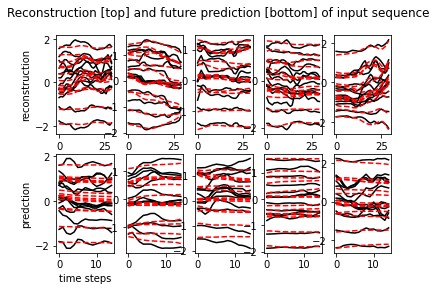

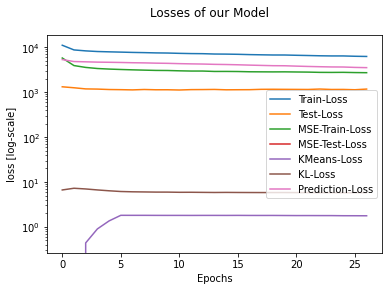

In [3]:
# Evaluate the network

vame.evaluate_model(config)

In [4]:
%%time
# Segment behavior

# vame.behavior_segmentation(config, model_name='VAME_prey_model', cluster_method='kmeans', n_cluster=[30])
vame.pose_segmentation(config)

Pose segmentation for VAME model: VAME 



  0%|                                                                                                                                                                                                             | 0/580 [00:00<?, ?it/s]

Using CUDA
GPU active: True
GPU used: GeForce RTX 2080 Ti
Load model... 
Embedd latent vector for file 04_02_2021_10_34_47_miniscope_DG_210202_a_succ


  6%|████████████▎                                                                                                                                                                                      | 40/632 [00:00<00:01, 398.90it/s]

Embedd latent vector for file 04_02_2021_10_30_38_miniscope_DG_210202_a_succ


 20%|███████████████████████████████████████▋                                                                                                                                                           | 54/265 [00:00<00:00, 535.15it/s]

Embedd latent vector for file 04_02_2021_10_25_41_miniscope_DG_210202_a_succ


 11%|█████████████████████▏                                                                                                                                                                             | 56/515 [00:00<00:00, 540.99it/s]

Embedd latent vector for file 04_02_2021_10_21_22_miniscope_DG_210202_a_succ


  6%|████████████▍                                                                                                                                                                                      | 45/708 [00:00<00:01, 448.82it/s]

Embedd latent vector for file 04_02_2021_10_16_10_miniscope_DG_210202_a_succ


  2%|████▍                                                                                                                                                                                             | 34/1480 [00:00<00:04, 334.88it/s]

Embedd latent vector for file 04_02_2021_10_10_35_miniscope_DG_210202_a_succ


 33%|███████████████████████████████████████████████████████████████▊                                                                                                                                   | 52/159 [00:00<00:00, 494.59it/s]

Embedd latent vector for file 04_02_2021_10_06_47_miniscope_DG_210202_a_succ


 26%|███████████████████████████████████████████████████▍                                                                                                                                               | 62/235 [00:00<00:00, 557.08it/s]

Embedd latent vector for file 04_02_2021_10_03_36_miniscope_DG_210202_a_succ


 11%|█████████████████████▋                                                                                                                                                                             | 54/485 [00:00<00:00, 534.51it/s]

Embedd latent vector for file 04_01_2021_09_59_45_miniscope_DG_210202_a_succ_injured


 21%|█████████████████████████████████████████▍                                                                                                                                                         | 62/292 [00:00<00:00, 567.97it/s]

Embedd latent vector for file 04_01_2021_09_55_30_miniscope_DG_210202_a_succ


  8%|███████████████▊                                                                                                                                                                                   | 38/470 [00:00<00:01, 374.73it/s]

Embedd latent vector for file 04_01_2021_09_51_46_miniscope_DG_210202_a_succ


 14%|███████████████████████████▋                                                                                                                                                                       | 64/451 [00:00<00:00, 572.98it/s]

Embedd latent vector for file 04_01_2021_09_47_53_miniscope_DG_210202_a_succ


 13%|██████████████████████████                                                                                                                                                                         | 64/480 [00:00<00:00, 567.22it/s]

Embedd latent vector for file 04_01_2021_09_43_29_miniscope_DG_210202_a_succ


  5%|█████████                                                                                                                                                                                         | 52/1106 [00:00<00:02, 476.44it/s]

Embedd latent vector for file 04_01_2021_09_38_38_miniscope_DG_210202_a_succ


 45%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 59/132 [00:00<00:00, 555.05it/s]

Embedd latent vector for file 04_01_2021_09_35_49_miniscope_DG_210202_a_succ


 11%|█████████████████████                                                                                                                                                                              | 50/464 [00:00<00:00, 448.46it/s]

Embedd latent vector for file 04_01_2021_09_31_49_miniscope_DG_210202_a_succ_grabbedcable


 10%|████████████████████▍                                                                                                                                                                              | 51/486 [00:00<00:00, 477.64it/s]

Embedd latent vector for file 03_31_2021_09_49_31_miniscope_DG_210202_a_succ


 13%|█████████████████████████▎                                                                                                                                                                         | 55/423 [00:00<00:00, 490.41it/s]

Embedd latent vector for file 03_31_2021_09_45_11_miniscope_DG_210202_a_succ


  0%|                                                                                                                                                                                                             | 0/189 [00:00<?, ?it/s]

Embedd latent vector for file 03_31_2021_09_38_46_miniscope_DG_210202_a_succ
Embedd latent vector for file 03_31_2021_09_35_52_miniscope_DG_210202_a_succ


  7%|█████████████▎                                                                                                                                                                                     | 53/775 [00:00<00:01, 529.03it/s]

Embedd latent vector for file 03_31_2021_09_32_31_miniscope_DG_210202_a_succ


  7%|█████████████▊                                                                                                                                                                                     | 48/675 [00:00<00:01, 436.53it/s]

Embedd latent vector for file 03_31_2021_09_26_57_miniscope_DG_210202_a_succ


  8%|██████████████▊                                                                                                                                                                                    | 53/696 [00:00<00:01, 529.85it/s]

Embedd latent vector for file 03_31_2021_09_23_53_miniscope_DG_210202_a_succ


 11%|████████████████████▉                                                                                                                                                                              | 53/495 [00:00<00:00, 472.26it/s]

Embedd latent vector for file 03_31_2021_09_19_18_miniscope_DG_210202_a_succ


  1%|██▌                                                                                                                                                                                               | 39/2913 [00:00<00:07, 386.79it/s]

Embedd latent vector for file 03_30_2021_09_51_19_miniscope_DG_210202_a_succ


  3%|█████▍                                                                                                                                                                                            | 55/1945 [00:00<00:03, 497.69it/s]

Embedd latent vector for file 03_30_2021_09_46_33_miniscope_DG_210202_a_succ_injured


  2%|████▊                                                                                                                                                                                             | 45/1804 [00:00<00:04, 430.71it/s]

Embedd latent vector for file 03_30_2021_09_41_12_miniscope_DG_210202_a_succ


  5%|████████▊                                                                                                                                                                                         | 55/1205 [00:00<00:02, 537.63it/s]

Embedd latent vector for file 03_30_2021_09_36_54_miniscope_DG_210202_a_succ


 32%|█████████████████████████████████████████████████████████████▌                                                                                                                                     | 60/190 [00:00<00:00, 595.30it/s]

Embedd latent vector for file 03_30_2021_09_33_30_miniscope_DG_210202_a_succ_injured


  4%|████████                                                                                                                                                                                          | 54/1309 [00:00<00:02, 500.45it/s]

Embedd latent vector for file 03_30_2021_09_27_31_miniscope_DG_210202_a_succ_cutearly


  6%|████████████                                                                                                                                                                                       | 56/908 [00:00<00:01, 494.55it/s]

Embedd latent vector for file 03_30_2021_09_21_05_miniscope_DG_210202_a_succ_injured


  8%|██████████████▋                                                                                                                                                                                    | 60/799 [00:00<00:01, 532.60it/s]

Embedd latent vector for file 03_30_2021_09_16_35_miniscope_DG_210202_a_succ_injured


  3%|█████▌                                                                                                                                                                                            | 62/2163 [00:00<00:03, 538.86it/s]

Embedd latent vector for file 03_29_2021_10_13_07_miniscope_DG_210202_a_succ


  2%|███▏                                                                                                                                                                                              | 64/3848 [00:00<00:06, 568.59it/s]

Embedd latent vector for file 03_29_2021_10_04_21_miniscope_DG_210202_a_succ


  2%|████▍                                                                                                                                                                                             | 55/2434 [00:00<00:04, 499.05it/s]

Embedd latent vector for file 03_29_2021_09_56_46_miniscope_DG_210202_a_succ


  2%|████                                                                                                                                                                                              | 59/2857 [00:00<00:05, 540.74it/s]

Embedd latent vector for file 03_29_2021_09_49_44_miniscope_DG_210202_a_succ


  3%|█████▍                                                                                                                                                                                            | 34/1214 [00:00<00:03, 339.28it/s]

Embedd latent vector for file 03_29_2021_09_43_54_miniscope_DG_210202_a_succ


  1%|██▏                                                                                                                                                                                               | 33/2872 [00:00<00:09, 293.98it/s]

Embedd latent vector for file 03_29_2021_09_37_03_miniscope_DG_210202_a_succ


  1%|█▉                                                                                                                                                                                                | 46/4605 [00:00<00:09, 458.58it/s]

Embedd latent vector for file 03_29_2021_09_25_44_miniscope_DG_210202_a_succ


 38%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 58/151 [00:00<00:00, 530.00it/s]

Embedd latent vector for file 03_29_2021_09_17_07_miniscope_DG_210202_a_succ


  1%|██▎                                                                                                                                                                                               | 59/4922 [00:00<00:08, 560.70it/s]

Embedd latent vector for file 03_26_2021_09_00_53_miniscope_DG_210202_a_fail_nonres_attempts


  1%|██▍                                                                                                                                                                                               | 62/5017 [00:00<00:08, 595.35it/s]

Embedd latent vector for file 03_26_2021_08_53_20_miniscope_DG_210202_a_fail_nonres_attempts


  1%|█▉                                                                                                                                                                                                | 51/5009 [00:00<00:11, 448.24it/s]

Embedd latent vector for file 03_26_2021_08_45_47_miniscope_DG_210202_a_fail_nonres_attempts


  1%|██▍                                                                                                                                                                                               | 62/4979 [00:00<00:08, 574.46it/s]

Embedd latent vector for file 03_26_2021_08_38_53_miniscope_DG_210202_a_fail_nonres_attempts


  6%|████████████                                                                                                                                                                                       | 60/969 [00:00<00:01, 575.26it/s]

Embedd latent vector for file 03_25_2021_09_52_28_miniscope_DG_210202_a_fail_nonres_attempts


  4%|███████▋                                                                                                                                                                                          | 59/1498 [00:00<00:02, 573.06it/s]

Embedd latent vector for file 03_25_2021_09_45_37_miniscope_DG_210202_a_fail_nonres_attempts


  2%|███▍                                                                                                                                                                                              | 47/2618 [00:00<00:06, 419.10it/s]

Embedd latent vector for file 03_25_2021_09_36_59_miniscope_DG_210202_a_fail_nonres_attempts


  1%|█▋                                                                                                                                                                                                | 44/5022 [00:00<00:12, 397.53it/s]

Embedd latent vector for file 03_25_2021_09_29_46_miniscope_DG_210202_a_fail_nonres_attempts


 16%|██████████████████████████████▌                                                                                                                                                                    | 53/338 [00:00<00:00, 515.19it/s]

Embedd latent vector for file 03_24_2021_13_59_13_miniscope_DG_210202_a_fail_nonres_attempts


  2%|███▍                                                                                                                                                                                              | 60/3366 [00:00<00:06, 534.31it/s]

Embedd latent vector for file 03_24_2021_13_52_36_miniscope_DG_210202_a_fail_nonres


  6%|███████████▌                                                                                                                                                                                      | 62/1041 [00:00<00:01, 599.29it/s]

Embedd latent vector for file 03_24_2021_13_45_32_miniscope_DG_210202_a_fail_nonres


  1%|█▉                                                                                                                                                                                                | 50/4940 [00:00<00:10, 448.23it/s]

Embedd latent vector for file 03_24_2021_13_38_36_miniscope_DG_210202_a_fail_nonres


  7%|█████████████▎                                                                                                                                                                                     | 35/513 [00:00<00:01, 349.91it/s]

Embedd latent vector for file 03_23_2021_07_36_47_miniscope_DG_210202_a_habi


 14%|██████████████████████████▊                                                                                                                                                                        | 51/371 [00:00<00:00, 501.76it/s]

Embedd latent vector for file 03_23_2021_07_28_32_miniscope_DG_210202_a_habi


  2%|████▏                                                                                                                                                                                             | 60/2816 [00:00<00:05, 539.00it/s]

Embedd latent vector for file 03_23_2021_07_22_20_miniscope_DG_210202_a_habi


  4%|███████▏                                                                                                                                                                                          | 53/1442 [00:00<00:02, 527.37it/s]

Embedd latent vector for file 03_23_2021_07_15_34_miniscope_DG_210202_a_habi


  5%|██████████▏                                                                                                                                                                                        | 36/690 [00:00<00:01, 331.47it/s]

Embedd latent vector for file 03_22_2021_10_01_27_miniscope_DG_210202_a_habi


 17%|████████████████████████████████▊                                                                                                                                                                  | 53/315 [00:00<00:00, 469.92it/s]

Embedd latent vector for file 03_22_2021_09_55_17_miniscope_DG_210202_a_habi


 24%|███████████████████████████████████████████████▌                                                                                                                                                   | 62/254 [00:00<00:00, 548.69it/s]

Embedd latent vector for file 03_22_2021_09_49_08_miniscope_DG_210202_a_habi


  5%|██████████▌                                                                                                                                                                                       | 58/1060 [00:00<00:01, 574.57it/s]

Embedd latent vector for file 03_22_2021_09_42_53_miniscope_DG_210202_a_habi


  8%|████████████████▎                                                                                                                                                                                  | 56/668 [00:00<00:01, 494.77it/s]

Embedd latent vector for file 03_22_2021_09_26_19_miniscope_DG_210202_a_habi_smallfluo


  1%|█▊                                                                                                                                                                                                | 48/4993 [00:00<00:11, 436.43it/s]

Embedd latent vector for file 03_22_2021_09_19_25_miniscope_DG_210202_a_habi_smallfluo


  5%|█████████▉                                                                                                                                                                                         | 50/985 [00:00<00:01, 480.26it/s]

Embedd latent vector for file 03_19_2021_07_37_05_miniscope_DG_210202_a_habi_badfluo


 15%|████████████████████████████▋                                                                                                                                                                      | 56/380 [00:00<00:00, 527.74it/s]

Embedd latent vector for file 03_19_2021_07_30_40_miniscope_DG_210202_a_habi_badfluo


  3%|█████▉                                                                                                                                                                                            | 62/2036 [00:00<00:03, 598.86it/s]

Embedd latent vector for file 03_19_2021_07_24_15_miniscope_DG_210202_a_habi_badfluo


 14%|███████████████████████████                                                                                                                                                                        | 50/360 [00:00<00:00, 497.76it/s]

Embedd latent vector for file 03_19_2021_07_17_14_miniscope_DG_210202_a_habi_badfluo


 34%|█████████████████████████████████████████████████████████████████▍                                                                                                                                 | 50/149 [00:00<00:00, 435.94it/s]

Embedd latent vector for file 03_18_2021_09_45_56_miniscope_DG_210202_a_habi_badfov


  7%|█████████████                                                                                                                                                                                      | 51/760 [00:00<00:01, 478.99it/s]

Embedd latent vector for file 03_18_2021_09_39_24_miniscope_DG_210202_a_habi_badfov


 25%|███████████████████████████████████████████████▊                                                                                                                                                   | 62/253 [00:00<00:00, 552.82it/s]

Embedd latent vector for file 03_18_2021_09_32_46_miniscope_DG_210202_a_habi_badfov


  3%|█████▍                                                                                                                                                                                            | 48/1703 [00:00<00:03, 430.88it/s]

Embedd latent vector for file 03_18_2021_09_25_02_miniscope_DG_210202_a_habi_badfov


  1%|██▏                                                                                                                                                                                               | 55/4883 [00:00<00:08, 543.07it/s]

Embedd latent vector for file 03_17_2021_09_47_02_miniscope_DG_210202_a_habi_nofluo


  1%|██▍                                                                                                                                                                                               | 60/4900 [00:00<00:08, 594.71it/s]

Embedd latent vector for file 03_17_2021_09_35_32_miniscope_DG_210202_a_habi_nofluo


  1%|██▏                                                                                                                                                                                               | 56/4965 [00:00<00:09, 539.99it/s]

Embedd latent vector for file 03_17_2021_09_28_35_miniscope_DG_210202_a_habi_nofluo


  1%|██▍                                                                                                                                                                                               | 62/5009 [00:00<00:08, 593.50it/s]

Embedd latent vector for file 03_17_2021_09_21_23_miniscope_DG_210202_a_habi_nofluo


  1%|██▍                                                                                                                                                                                               | 50/3930 [00:00<00:07, 494.14it/s]

Embedd latent vector for file 03_16_2021_10_17_47_miniscope_DG_210202_a_habi_nofluo


  1%|█▍                                                                                                                                                                                                | 39/5191 [00:00<00:13, 384.82it/s]

Embedd latent vector for file 03_16_2021_10_11_02_miniscope_DG_210202_a_habi_nofluo


  1%|█▉                                                                                                                                                                                                | 49/4827 [00:00<00:09, 486.05it/s]

Embedd latent vector for file 03_16_2021_10_00_55_miniscope_DG_210202_a_habi_nofluo


  1%|██▋                                                                                                                                                                                               | 46/3352 [00:00<00:07, 441.55it/s]

Embedd latent vector for file 03_16_2021_09_53_54_miniscope_DG_210202_a_habi_nofluo


  1%|██▏                                                                                                                                                                                               | 56/4915 [00:00<00:09, 502.68it/s]

Embedd latent vector for file 03_15_2021_10_57_23_miniscope_DG_210202_a_habi_nomini


  1%|█▊                                                                                                                                                                                                | 44/4743 [00:00<00:10, 438.95it/s]

Embedd latent vector for file 03_15_2021_10_50_53_miniscope_DG_210202_a_habi_nomini


  1%|██▏                                                                                                                                                                                               | 55/4879 [00:00<00:09, 510.74it/s]

Embedd latent vector for file 03_15_2021_10_43_36_miniscope_DG_210202_a_habi_nomini


  1%|██▏                                                                                                                                                                                               | 54/4817 [00:00<00:09, 510.68it/s]

Embedd latent vector for file 03_15_2021_10_35_50_miniscope_DG_210202_a_habi_nomini


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 40/83 [00:00<00:00, 385.49it/s]

Embedd latent vector for file 09_08_2020_15_56_34_miniscope_DG_200617_b_succ_injured_nofluo


  0%|                                                                                                                                                                                                             | 0/153 [00:00<?, ?it/s]

Embedd latent vector for file 09_08_2020_15_54_36_miniscope_DG_200617_b_succ
Embedd latent vector for file 09_08_2020_15_50_32_miniscope_DG_200617_b_succ


 39%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 46/119 [00:00<00:00, 408.23it/s]

Embedd latent vector for file 09_08_2020_15_47_44_miniscope_DG_200617_b_succ


 29%|████████████████████████████████████████████████████████                                                                                                                                           | 48/167 [00:00<00:00, 429.46it/s]

Embedd latent vector for file 09_08_2020_15_39_45_miniscope_DG_200617_b_succ


 40%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 43/108 [00:00<00:00, 420.80it/s]

Embedd latent vector for file 09_08_2020_15_36_13_miniscope_DG_200617_b_succ_injured


  0%|                                                                                                                                                                                                              | 0/26 [00:00<?, ?it/s]

Embedd latent vector for file 09_08_2020_15_32_30_miniscope_DG_200617_b_succ
Embedd latent vector for file 09_08_2020_15_26_21_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                              | 0/52 [00:00<?, ?it/s]

Embedd latent vector for file 09_08_2020_15_23_32_miniscope_DG_200701_a_succ
Embedd latent vector for file 09_08_2020_15_20_34_miniscope_DG_200701_a_succ


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 632.24it/s]


Embedd latent vector for file 09_08_2020_15_16_25_miniscope_DG_200701_a_succ
Embedd latent vector for file 09_08_2020_15_13_51_miniscope_DG_200701_a_succ


 43%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 54/126 [00:00<00:00, 534.14it/s]

Embedd latent vector for file 09_08_2020_15_10_07_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                              | 0/56 [00:00<?, ?it/s]

Embedd latent vector for file 09_08_2020_15_06_13_miniscope_DG_200701_a_succ
Embedd latent vector for file 09_08_2020_15_03_49_miniscope_DG_200701_a_succ_nomini


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 62/115 [00:00<00:00, 561.74it/s]

Embedd latent vector for file 09_08_2020_15_00_07_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                              | 0/72 [00:00<?, ?it/s]

Embedd latent vector for file 09_07_2020_15_41_46_miniscope_DG_200617_b_succ
Embedd latent vector for file 09_07_2020_15_38_41_miniscope_DG_200617_b_succ
Embedd latent vector for file 09_07_2020_15_29_47_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                             | 0/162 [00:00<?, ?it/s]

Embedd latent vector for file 09_07_2020_15_26_46_miniscope_DG_200617_b_succ
Embedd latent vector for file 09_07_2020_15_23_07_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                             | 0/109 [00:00<?, ?it/s]

Embedd latent vector for file 09_07_2020_15_18_17_miniscope_DG_200617_b_succ
Embedd latent vector for file 09_07_2020_15_02_53_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                              | 0/77 [00:00<?, ?it/s]

Embedd latent vector for file 09_07_2020_14_59_11_miniscope_DG_200701_a_succ
Embedd latent vector for file 09_07_2020_14_53_42_miniscope_DG_200701_a_succ


 23%|████████████████████████████████████████████                                                                                                                                                       | 52/230 [00:00<00:00, 461.08it/s]

Embedd latent vector for file 09_07_2020_14_51_32_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                             | 0/162 [00:00<?, ?it/s]

Embedd latent vector for file 09_07_2020_14_48_19_miniscope_DG_200701_a_succ
Embedd latent vector for file 09_07_2020_14_45_29_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                             | 0/122 [00:00<?, ?it/s]

Embedd latent vector for file 09_07_2020_14_42_14_miniscope_DG_200701_a_succ_injured
Embedd latent vector for file 09_06_2020_15_51_43_miniscope_DG_200617_b_succ


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 63/108 [00:00<00:00, 554.47it/s]

Embedd latent vector for file 09_06_2020_15_47_33_miniscope_DG_200617_b_succ_injured


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 57/110 [00:00<00:00, 559.48it/s]

Embedd latent vector for file 09_06_2020_15_43_13_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                              | 0/64 [00:00<?, ?it/s]

Embedd latent vector for file 09_06_2020_15_35_22_miniscope_DG_200617_b_succ
Embedd latent vector for file 09_06_2020_15_28_50_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                              | 0/36 [00:00<?, ?it/s]

Embedd latent vector for file 09_06_2020_15_25_10_miniscope_DG_200617_b_succ
Embedd latent vector for file 09_06_2020_15_18_22_miniscope_DG_200701_a_succ


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 60/150 [00:00<00:00, 595.84it/s]

Embedd latent vector for file 09_06_2020_15_14_12_miniscope_DG_200701_a_succ


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 62/128 [00:00<00:00, 568.41it/s]

Embedd latent vector for file 09_06_2020_15_11_37_miniscope_DG_200701_a_succ
Embedd latent vector for file 09_06_2020_15_09_11_miniscope_DG_200701_a_succ


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 61/203 [00:00<00:00, 553.56it/s]

Embedd latent vector for file 09_06_2020_15_05_22_miniscope_DG_200701_a_succ


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 667.90it/s]


Embedd latent vector for file 09_06_2020_15_02_17_miniscope_DG_200701_a_succ
Embedd latent vector for file 09_06_2020_14_58_24_miniscope_DG_200701_a_succ
Embedd latent vector for file 09_06_2020_14_55_10_miniscope_DG_200701_a_succ_injured


 32%|██████████████████████████████████████████████████████████████▋                                                                                                                                    | 63/196 [00:00<00:00, 592.99it/s]

Embedd latent vector for file 09_05_2020_16_26_47_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                             | 0/119 [00:00<?, ?it/s]

Embedd latent vector for file 09_05_2020_16_23_03_miniscope_DG_200617_b_succ
Embedd latent vector for file 09_05_2020_16_19_09_miniscope_DG_200617_b_succ


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 60/92 [00:00<00:00, 582.33it/s]

Embedd latent vector for file 09_05_2020_16_16_21_miniscope_DG_200617_b_succ


 24%|█████████████████████████████████████████████▉                                                                                                                                                     | 33/140 [00:00<00:00, 325.69it/s]

Embedd latent vector for file 09_05_2020_16_12_58_miniscope_DG_200617_b_succ


 29%|████████████████████████████████████████████████████████▏                                                                                                                                          | 55/191 [00:00<00:00, 488.45it/s]

Embedd latent vector for file 09_05_2020_16_09_14_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                              | 0/88 [00:00<?, ?it/s]

Embedd latent vector for file 09_05_2020_15_59_18_miniscope_DG_200701_a_succ
Embedd latent vector for file 09_05_2020_15_56_40_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                             | 0/192 [00:00<?, ?it/s]

Embedd latent vector for file 09_05_2020_15_52_46_miniscope_DG_200701_a_succ
Embedd latent vector for file 09_05_2020_15_50_02_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                              | 0/31 [00:00<?, ?it/s]

Embedd latent vector for file 09_05_2020_15_47_48_miniscope_DG_200701_a_succ
Embedd latent vector for file 09_05_2020_15_45_35_miniscope_DG_200701_a_succ_injured


 28%|█████████████████████████████████████████████████████▊                                                                                                                                             | 51/185 [00:00<00:00, 484.36it/s]

Embedd latent vector for file 09_05_2020_15_40_48_miniscope_DG_200701_a_succ_injured
Embedd latent vector for file 09_04_2020_17_26_53_miniscope_DG_200617_b_succ


 25%|█████████████████████████████████████████████████                                                                                                                                                  | 40/159 [00:00<00:00, 395.50it/s]

Embedd latent vector for file 09_04_2020_17_23_03_miniscope_DG_200617_b_succ


 46%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 54/117 [00:00<00:00, 518.35it/s]

Embedd latent vector for file 09_04_2020_17_17_48_miniscope_DG_200617_b_succ


 18%|███████████████████████████████████                                                                                                                                                                | 43/239 [00:00<00:00, 422.88it/s]

Embedd latent vector for file 09_04_2020_17_14_08_miniscope_DG_200617_b_succ
Embedd latent vector for file 09_04_2020_17_07_37_miniscope_DG_200617_b_succ_injured


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 55/105 [00:00<00:00, 479.62it/s]

Embedd latent vector for file 09_04_2020_17_03_57_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                             | 0/111 [00:00<?, ?it/s]

Embedd latent vector for file 09_04_2020_17_00_52_miniscope_DG_200617_b_succ
Embedd latent vector for file 09_04_2020_16_52_56_miniscope_DG_200701_a_succ


 41%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 55/133 [00:00<00:00, 495.76it/s]

Embedd latent vector for file 09_04_2020_16_46_11_miniscope_DG_200701_a_succ_distractedbytrash


 31%|████████████████████████████████████████████████████████████▍                                                                                                                                      | 57/184 [00:00<00:00, 538.86it/s]

Embedd latent vector for file 09_04_2020_16_43_01_miniscope_DG_200701_a_succ


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 55/157 [00:00<00:00, 514.25it/s]

Embedd latent vector for file 09_04_2020_16_39_31_miniscope_DG_200701_a_succ


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 497.61it/s]

Embedd latent vector for file 09_04_2020_16_35_52_miniscope_DG_200701_a_succ



  0%|                                                                                                                                                                                                              | 0/53 [00:00<?, ?it/s]

Embedd latent vector for file 09_04_2020_16_33_29_miniscope_DG_200701_a_succ
Embedd latent vector for file 09_04_2020_16_30_05_miniscope_DG_200701_a_succ_injured


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 50/93 [00:00<00:00, 456.91it/s]

Embedd latent vector for file 09_03_2020_16_40_53_miniscope_DG_200617_b_succ


 25%|████████████████████████████████████████████████▍                                                                                                                                                  | 65/262 [00:00<00:00, 592.50it/s]

Embedd latent vector for file 09_03_2020_16_36_15_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                              | 0/26 [00:00<?, ?it/s]

Embedd latent vector for file 09_03_2020_16_31_10_miniscope_DG_200617_b_succ
Embedd latent vector for file 09_03_2020_16_28_25_miniscope_DG_200617_b_succ


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 61/88 [00:00<00:00, 568.51it/s]

Embedd latent vector for file 09_03_2020_16_24_34_miniscope_DG_200617_b_succ
Embedd latent vector for file 09_03_2020_16_21_39_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                             | 0/162 [00:00<?, ?it/s]

Embedd latent vector for file 09_03_2020_16_15_16_miniscope_DG_200701_a_succ
Embedd latent vector for file 09_03_2020_16_12_49_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                              | 0/47 [00:00<?, ?it/s]

Embedd latent vector for file 09_03_2020_16_09_44_miniscope_DG_200701_a_succ
Embedd latent vector for file 09_03_2020_16_06_54_miniscope_DG_200701_a_succ_injured


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 533.02it/s]

Embedd latent vector for file 09_03_2020_16_03_07_miniscope_DG_200701_a_succ



 41%|███████████████████████████████████████████████████████████████████████████████                                                                                                                    | 60/148 [00:00<00:00, 564.96it/s]

Embedd latent vector for file 09_03_2020_15_59_43_miniscope_DG_200701_a_succ


 39%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 49/125 [00:00<00:00, 484.38it/s]

Embedd latent vector for file 09_03_2020_15_57_43_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                             | 0/102 [00:00<?, ?it/s]

Embedd latent vector for file 09_03_2020_15_54_14_miniscope_DG_200701_a_succ
Embedd latent vector for file 09_02_2020_17_38_56_miniscope_DG_200617_b_succ


 24%|███████████████████████████████████████████████                                                                                                                                                    | 54/224 [00:00<00:00, 533.54it/s]

Embedd latent vector for file 09_02_2020_17_35_23_miniscope_DG_200617_b_succ
Embedd latent vector for file 09_02_2020_17_27_37_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                             | 0/221 [00:00<?, ?it/s]

Embedd latent vector for file 09_02_2020_17_24_54_miniscope_DG_200617_b_succ
Embedd latent vector for file 09_02_2020_17_21_30_miniscope_DG_200617_b_succ
Embedd latent vector for file 09_02_2020_17_17_37_miniscope_DG_200617_b_succ


 32%|███████████████████████████████████████████████████████████████▏                                                                                                                                   | 60/185 [00:00<00:00, 569.94it/s]

Embedd latent vector for file 09_02_2020_17_13_08_miniscope_DG_200617_b_succ


 24%|██████████████████████████████████████████████▎                                                                                                                                                    | 53/223 [00:00<00:00, 492.38it/s]

Embedd latent vector for file 09_02_2020_16_55_43_miniscope_DG_200701_a_succ


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 55/95 [00:00<00:00, 499.10it/s]

Embedd latent vector for file 09_02_2020_16_53_10_miniscope_DG_200701_a_succ


 18%|███████████████████████████████████▏                                                                                                                                                               | 61/338 [00:00<00:00, 559.21it/s]

Embedd latent vector for file 09_02_2020_16_50_16_miniscope_DG_200701_a_succ


 18%|███████████████████████████████████▌                                                                                                                                                               | 63/345 [00:00<00:00, 563.51it/s]

Embedd latent vector for file 09_02_2020_16_45_55_miniscope_DG_200701_a_succ


 29%|████████████████████████████████████████████████████████▉                                                                                                                                          | 64/219 [00:00<00:00, 561.51it/s]

Embedd latent vector for file 09_02_2020_16_41_25_miniscope_DG_200701_a_succ


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 56/114 [00:00<00:00, 518.81it/s]

Embedd latent vector for file 09_02_2020_16_37_35_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                             | 0/117 [00:00<?, ?it/s]

Embedd latent vector for file 09_02_2020_16_34_36_miniscope_DG_200701_a_succ
Embedd latent vector for file 09_02_2020_16_30_27_miniscope_DG_200701_a_succ_injured


  0%|                                                                                                                                                                                                             | 0/159 [00:00<?, ?it/s]

Embedd latent vector for file 09_01_2020_16_58_35_miniscope_DG_200617_b_succ_injured
Embedd latent vector for file 09_01_2020_16_55_25_miniscope_DG_200617_b_succ


 17%|█████████████████████████████████▎                                                                                                                                                                 | 55/322 [00:00<00:00, 541.32it/s]

Embedd latent vector for file 09_01_2020_16_52_15_miniscope_DG_200617_b_succ_injured
Embedd latent vector for file 09_01_2020_16_47_10_miniscope_DG_200617_b_succ


 30%|███████████████████████████████████████████████████████████▏                                                                                                                                       | 48/158 [00:00<00:00, 474.96it/s]

Embedd latent vector for file 09_01_2020_16_43_46_miniscope_DG_200617_b_succ


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 62/124 [00:00<00:00, 550.49it/s]

Embedd latent vector for file 09_01_2020_16_34_42_miniscope_DG_200617_b_succ


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 547.43it/s]

Embedd latent vector for file 09_01_2020_16_29_24_miniscope_DG_200617_b_succ
Embedd latent vector for file 09_01_2020_16_20_52_miniscope_DG_200701_a_succ



  0%|                                                                                                                                                                                                             | 0/148 [00:00<?, ?it/s]

Embedd latent vector for file 09_01_2020_16_17_14_miniscope_DG_200701_a_succ


 44%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 63/142 [00:00<00:00, 564.11it/s]

Embedd latent vector for file 09_01_2020_16_14_05_miniscope_DG_200701_a_succ


 42%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 54/129 [00:00<00:00, 513.42it/s]

Embedd latent vector for file 09_01_2020_16_10_27_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                              | 0/68 [00:00<?, ?it/s]

Embedd latent vector for file 09_01_2020_16_07_13_miniscope_DG_200701_a_succ
Embedd latent vector for file 09_01_2020_16_03_24_miniscope_DG_200701_a_succ


 33%|████████████████████████████████████████████████████████████████▍                                                                                                                                  | 41/124 [00:00<00:00, 371.80it/s]

Embedd latent vector for file 09_01_2020_15_59_31_miniscope_DG_200701_a_succ


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 63/101 [00:00<00:00, 563.20it/s]

Embedd latent vector for file 09_01_2020_15_56_27_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                             | 0/110 [00:00<?, ?it/s]

Embedd latent vector for file 08_31_2020_16_42_25_miniscope_DG_200617_b_succ_injured
Embedd latent vector for file 08_31_2020_16_39_00_miniscope_DG_200617_b_succ


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 594.48it/s]


Embedd latent vector for file 08_31_2020_16_36_15_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_31_2020_16_32_34_miniscope_DG_200617_b_succ


 45%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 47/104 [00:00<00:00, 463.66it/s]

Embedd latent vector for file 08_31_2020_16_29_59_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                             | 0/112 [00:00<?, ?it/s]

Embedd latent vector for file 08_31_2020_16_26_28_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_31_2020_16_22_19_miniscope_DG_200617_b_succ


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 633.50it/s]

Embedd latent vector for file 08_31_2020_16_10_12_miniscope_DG_200701_a_succ
Embedd latent vector for file 08_31_2020_16_05_52_miniscope_DG_200701_a_succ



 38%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 58/153 [00:00<00:00, 541.35it/s]

Embedd latent vector for file 08_31_2020_16_01_53_miniscope_DG_200701_a_succ


 29%|█████████████████████████████████████████████████████████                                                                                                                                          | 62/212 [00:00<00:00, 554.85it/s]

Embedd latent vector for file 08_31_2020_15_54_51_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                              | 0/99 [00:00<?, ?it/s]

Embedd latent vector for file 08_31_2020_15_50_06_miniscope_DG_200701_a_succ
Embedd latent vector for file 08_31_2020_15_46_43_miniscope_DG_200701_a_succ


 27%|████████████████████████████████████████████████████▉                                                                                                                                              | 54/199 [00:00<00:00, 537.44it/s]

Embedd latent vector for file 08_31_2020_15_41_54_miniscope_DG_200701_a_succ


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 617.83it/s]

Embedd latent vector for file 08_30_2020_16_35_54_miniscope_DG_200617_b_succ



 33%|████████████████████████████████████████████████████████████████▌                                                                                                                                  | 46/139 [00:00<00:00, 408.86it/s]

Embedd latent vector for file 08_30_2020_16_31_45_miniscope_DG_200617_b_succ


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 62/79 [00:00<00:00, 565.53it/s]

Embedd latent vector for file 08_30_2020_16_28_07_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_30_2020_16_24_08_miniscope_DG_200617_b_succ


 41%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 54/132 [00:00<00:00, 531.76it/s]

Embedd latent vector for file 08_30_2020_16_20_40_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_30_2020_16_17_16_miniscope_DG_200617_b_succ


 40%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 55/139 [00:00<00:00, 509.95it/s]

Embedd latent vector for file 08_30_2020_16_14_23_miniscope_DG_200617_b_succ


 29%|███████████████████████████████████████████████████████▊                                                                                                                                           | 63/220 [00:00<00:00, 568.07it/s]

Embedd latent vector for file 08_30_2020_16_10_58_miniscope_DG_200617_b_succ_injured


  0%|                                                                                                                                                                                                              | 0/51 [00:00<?, ?it/s]

Embedd latent vector for file 08_30_2020_16_03_21_miniscope_DG_200701_a_succ
Embedd latent vector for file 08_30_2020_15_59_37_miniscope_DG_200701_a_succ_injured


 17%|████████████████████████████████▍                                                                                                                                                                  | 49/295 [00:00<00:00, 487.31it/s]

Embedd latent vector for file 08_30_2020_15_56_29_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                              | 0/48 [00:00<?, ?it/s]

Embedd latent vector for file 08_30_2020_15_53_35_miniscope_DG_200701_a_succ_injured
Embedd latent vector for file 08_30_2020_15_50_51_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                             | 0/115 [00:00<?, ?it/s]

Embedd latent vector for file 08_30_2020_15_47_33_miniscope_DG_200701_a_succ_injured
Embedd latent vector for file 08_30_2020_15_44_44_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                              | 0/62 [00:00<?, ?it/s]

Embedd latent vector for file 08_30_2020_15_40_53_miniscope_DG_200701_a_succ
Embedd latent vector for file 08_29_2020_16_54_07_miniscope_DG_200617_b_succ_nofluo


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 55/98 [00:00<00:00, 516.97it/s]

Embedd latent vector for file 08_29_2020_16_50_48_miniscope_DG_200617_b_succ


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 55/115 [00:00<00:00, 495.18it/s]

Embedd latent vector for file 08_29_2020_16_46_00_miniscope_DG_200617_b_succ


 15%|█████████████████████████████▊                                                                                                                                                                     | 47/308 [00:00<00:00, 434.93it/s]

Embedd latent vector for file 08_29_2020_16_42_06_miniscope_DG_200617_b_succ


 28%|█████████████████████████████████████████████████████▋                                                                                                                                             | 49/178 [00:00<00:00, 455.42it/s]

Embedd latent vector for file 08_29_2020_16_38_23_miniscope_DG_200617_b_succ


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 48/96 [00:00<00:00, 475.96it/s]

Embedd latent vector for file 08_29_2020_16_33_45_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                              | 0/58 [00:00<?, ?it/s]

Embedd latent vector for file 08_29_2020_16_31_16_miniscope_DG_200617_b_succ_injured
Embedd latent vector for file 08_29_2020_16_17_59_miniscope_DG_200701_a_succ


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 55/99 [00:00<00:00, 489.62it/s]

Embedd latent vector for file 08_29_2020_16_15_31_miniscope_DG_200701_a_succ


 29%|████████████████████████████████████████████████████████▏                                                                                                                                          | 49/170 [00:00<00:00, 443.78it/s]

Embedd latent vector for file 08_29_2020_16_12_42_miniscope_DG_200701_a_succ


 21%|█████████████████████████████████████████▋                                                                                                                                                         | 55/257 [00:00<00:00, 484.96it/s]

Embedd latent vector for file 08_29_2020_16_08_29_miniscope_DG_200701_a_succ


 23%|███████████████████████████████████████████▉                                                                                                                                                       | 55/244 [00:00<00:00, 490.84it/s]

Embedd latent vector for file 08_29_2020_16_04_30_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                             | 0/128 [00:00<?, ?it/s]

Embedd latent vector for file 08_29_2020_16_01_17_miniscope_DG_200701_a_succ
Embedd latent vector for file 08_29_2020_15_58_33_miniscope_DG_200701_a_succ


 16%|███████████████████████████████▌                                                                                                                                                                   | 42/259 [00:00<00:00, 418.15it/s]

Embedd latent vector for file 08_29_2020_15_55_24_miniscope_DG_200701_a_succ


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 60/106 [00:00<00:00, 538.68it/s]

Embedd latent vector for file 08_21_2020_16_33_02_miniscope_DG_200617_b_succ


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 564.89it/s]

Embedd latent vector for file 08_21_2020_16_28_13_miniscope_DG_200617_b_succ



 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 60/200 [00:00<00:00, 541.02it/s]

Embedd latent vector for file 08_21_2020_16_24_35_miniscope_DG_200617_b_succ


 26%|███████████████████████████████████████████████████▏                                                                                                                                               | 57/217 [00:00<00:00, 532.20it/s]

Embedd latent vector for file 08_21_2020_16_18_56_miniscope_DG_200617_b_succ


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 480.10it/s]

Embedd latent vector for file 08_21_2020_16_12_47_miniscope_DG_200617_b_succ



  0%|                                                                                                                                                                                                             | 0/458 [00:00<?, ?it/s]

Embedd latent vector for file 08_21_2020_16_08_48_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_21_2020_16_03_54_miniscope_DG_200617_b_succ


 21%|████████████████████████████████████████▎                                                                                                                                                          | 53/256 [00:00<00:00, 521.53it/s]

Embedd latent vector for file 08_21_2020_15_58_04_miniscope_DG_200617_b_succ_injured


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                  | 60/181 [00:00<00:00, 528.49it/s]

Embedd latent vector for file 08_21_2020_15_48_23_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                             | 0/180 [00:00<?, ?it/s]

Embedd latent vector for file 08_21_2020_15_45_14_miniscope_DG_200701_a_succ
Embedd latent vector for file 08_21_2020_15_42_56_miniscope_DG_200701_a_succ


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 573.53it/s]

Embedd latent vector for file 08_21_2020_15_39_23_miniscope_DG_200701_a_succ



  0%|                                                                                                                                                                                                             | 0/137 [00:00<?, ?it/s]

Embedd latent vector for file 08_21_2020_15_36_39_miniscope_DG_200701_a_succ
Embedd latent vector for file 08_21_2020_15_34_25_miniscope_DG_200701_a_succ_injured


 26%|██████████████████████████████████████████████████▊                                                                                                                                                | 56/215 [00:00<00:00, 514.62it/s]

Embedd latent vector for file 08_21_2020_15_32_26_miniscope_DG_200701_a_succ


 20%|██████████████████████████████████████▏                                                                                                                                                            | 45/230 [00:00<00:00, 448.00it/s]

Embedd latent vector for file 08_21_2020_15_29_32_miniscope_DG_200701_a_succ


 28%|█████████████████████████████████████████████████████▉                                                                                                                                             | 62/224 [00:00<00:00, 557.24it/s]

Embedd latent vector for file 08_20_2020_16_43_39_miniscope_DG_200617_b_succ_injured


  0%|                                                                                                                                                                                                             | 0/125 [00:00<?, ?it/s]

Embedd latent vector for file 08_20_2020_16_40_35_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_20_2020_16_36_12_miniscope_DG_200617_b_succ


 24%|█████████████████████████████████████████████▉                                                                                                                                                     | 40/170 [00:00<00:00, 356.77it/s]

Embedd latent vector for file 08_20_2020_16_31_59_miniscope_DG_200617_b_succ


 40%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 63/156 [00:00<00:00, 585.56it/s]

Embedd latent vector for file 08_20_2020_16_27_00_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                             | 0/182 [00:00<?, ?it/s]

Embedd latent vector for file 08_20_2020_16_23_32_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_20_2020_16_18_53_miniscope_DG_200617_b_succ


 25%|████████████████████████████████████████████████▉                                                                                                                                                  | 58/231 [00:00<00:00, 570.90it/s]

Embedd latent vector for file 08_20_2020_16_13_59_miniscope_DG_200617_b_succ


 44%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 57/131 [00:00<00:00, 532.42it/s]

Embedd latent vector for file 08_20_2020_16_06_26_miniscope_DG_200701_a_succ


 13%|█████████████████████████▊                                                                                                                                                                         | 64/484 [00:00<00:00, 584.57it/s]

Embedd latent vector for file 08_20_2020_16_03_02_miniscope_DG_200701_a_succ


 10%|███████████████████▋                                                                                                                                                                               | 62/616 [00:00<00:00, 575.03it/s]

Embedd latent vector for file 08_20_2020_15_57_27_miniscope_DG_200701_a_succ_grabbedcable


  0%|                                                                                                                                                                                                              | 0/91 [00:00<?, ?it/s]

Embedd latent vector for file 08_20_2020_15_54_48_miniscope_DG_200701_a_succ
Embedd latent vector for file 08_20_2020_15_51_33_miniscope_DG_200701_a_succ


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 62/111 [00:00<00:00, 591.02it/s]

Embedd latent vector for file 08_20_2020_15_48_39_miniscope_DG_200701_a_succ


 25%|████████████████████████████████████████████████▏                                                                                                                                                  | 45/182 [00:00<00:00, 449.75it/s]

Embedd latent vector for file 08_20_2020_15_43_36_miniscope_DG_200701_a_succ


 29%|████████████████████████████████████████████████████████                                                                                                                                           | 52/181 [00:00<00:00, 519.57it/s]

Embedd latent vector for file 08_20_2020_15_40_41_miniscope_DG_200701_a_succ


 28%|██████████████████████████████████████████████████████▍                                                                                                                                            | 62/222 [00:00<00:00, 574.46it/s]

Embedd latent vector for file 08_19_2020_16_55_33_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                             | 0/155 [00:00<?, ?it/s]

Embedd latent vector for file 08_19_2020_16_52_39_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_19_2020_16_50_11_miniscope_DG_200617_b_succ


 27%|███████████████████████████████████████████████████▉                                                                                                                                               | 62/233 [00:00<00:00, 582.23it/s]

Embedd latent vector for file 08_19_2020_16_44_52_miniscope_DG_200617_b_succ


 20%|███████████████████████████████████████▍                                                                                                                                                           | 63/312 [00:00<00:00, 574.92it/s]

Embedd latent vector for file 08_19_2020_16_39_04_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                             | 0/274 [00:00<?, ?it/s]

Embedd latent vector for file 08_19_2020_16_35_29_miniscope_DG_200617_b_succ_injured
Embedd latent vector for file 08_19_2020_16_33_11_miniscope_DG_200617_b_succ_injured
Embedd latent vector for file 08_19_2020_16_27_02_miniscope_DG_200617_b_succ


  2%|██▉                                                                                                                                                                                               | 62/4014 [00:00<00:07, 544.67it/s]

Embedd latent vector for file 08_19_2020_16_16_55_miniscope_DG_200701_a_succ_noncon


 34%|██████████████████████████████████████████████████████████████████▉                                                                                                                                | 56/163 [00:00<00:00, 523.87it/s]

Embedd latent vector for file 08_19_2020_16_11_32_miniscope_DG_200701_a_succ_injured


  0%|                                                                                                                                                                                                             | 0/454 [00:00<?, ?it/s]

Embedd latent vector for file 08_19_2020_16_09_08_miniscope_DG_200701_a_succ
Embedd latent vector for file 08_19_2020_16_05_59_miniscope_DG_200701_a_succ_grabbedcable


 36%|█████████████████████████████████████████████████████████████████████▍                                                                                                                             | 58/163 [00:00<00:00, 536.35it/s]

Embedd latent vector for file 08_19_2020_16_01_41_miniscope_DG_200701_a_succ


 21%|█████████████████████████████████████████▎                                                                                                                                                         | 47/222 [00:00<00:00, 469.84it/s]

Embedd latent vector for file 08_19_2020_15_58_22_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                             | 0/135 [00:00<?, ?it/s]

Embedd latent vector for file 08_19_2020_15_55_28_miniscope_DG_200701_a_succ_injured
Embedd latent vector for file 08_19_2020_15_51_39_miniscope_DG_200701_a_succ_injured


  7%|████████████▉                                                                                                                                                                                      | 33/499 [00:00<00:01, 305.47it/s]

Embedd latent vector for file 08_18_2020_16_45_57_miniscope_DG_200617_b_succ


 22%|██████████████████████████████████████████▍                                                                                                                                                        | 44/202 [00:00<00:00, 430.36it/s]

Embedd latent vector for file 08_18_2020_16_41_33_miniscope_DG_200617_b_succ


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 63/106 [00:00<00:00, 593.13it/s]

Embedd latent vector for file 08_18_2020_16_38_40_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_18_2020_16_34_54_miniscope_DG_200617_b_succ


  6%|████████████▍                                                                                                                                                                                      | 37/579 [00:00<00:01, 351.46it/s]

Embedd latent vector for file 08_18_2020_16_31_06_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                             | 0/107 [00:00<?, ?it/s]

Embedd latent vector for file 08_18_2020_16_28_42_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_18_2020_16_25_33_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                             | 0/155 [00:00<?, ?it/s]

Embedd latent vector for file 08_18_2020_16_23_10_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_18_2020_16_15_09_miniscope_DG_200701_a_succ


 11%|█████████████████████▉                                                                                                                                                                             | 41/365 [00:00<00:00, 381.88it/s]

Embedd latent vector for file 08_18_2020_16_11_41_miniscope_DG_200701_a_succ_grabbedcable


  0%|                                                                                                                                                                                                             | 0/185 [00:00<?, ?it/s]

Embedd latent vector for file 08_18_2020_16_08_29_miniscope_DG_200701_a_succ


 27%|████████████████████████████████████████████████████▊                                                                                                                                              | 49/181 [00:00<00:00, 433.07it/s]

Embedd latent vector for file 08_18_2020_16_04_51_miniscope_DG_200701_a_succ


 15%|████████████████████████████▍                                                                                                                                                                      | 62/426 [00:00<00:00, 573.65it/s]

Embedd latent vector for file 08_18_2020_16_01_32_miniscope_DG_200701_a_succ_injured


 39%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 55/140 [00:00<00:00, 509.99it/s]

Embedd latent vector for file 08_18_2020_15_59_09_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                             | 0/123 [00:00<?, ?it/s]

Embedd latent vector for file 08_18_2020_15_54_55_miniscope_DG_200701_a_succ
Embedd latent vector for file 08_18_2020_15_51_16_miniscope_DG_200701_a_succ


 32%|██████████████████████████████████████████████████████████████▌                                                                                                                                    | 52/162 [00:00<00:00, 471.16it/s]

Embedd latent vector for file 08_17_2020_16_25_53_miniscope_DG_200617_b_succ_injured


 44%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 66/150 [00:00<00:00, 593.01it/s]

Embedd latent vector for file 08_17_2020_16_22_44_miniscope_DG_200617_b_succ_injured


  0%|                                                                                                                                                                                                              | 0/67 [00:00<?, ?it/s]

Embedd latent vector for file 08_17_2020_16_19_31_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_17_2020_16_16_18_miniscope_DG_200617_b_succ


 42%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 62/147 [00:00<00:00, 556.37it/s]

Embedd latent vector for file 08_17_2020_16_12_24_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                             | 0/121 [00:00<?, ?it/s]

Embedd latent vector for file 08_17_2020_16_10_15_miniscope_DG_200617_b_succ


 30%|█████████████████████████████████████████████████████████▌                                                                                                                                         | 62/210 [00:00<00:00, 592.94it/s]

Embedd latent vector for file 08_17_2020_16_06_06_miniscope_DG_200617_b_succ


 31%|█████████████████████████████████████████████████████████████▏                                                                                                                                     | 54/172 [00:00<00:00, 519.19it/s]

Embedd latent vector for file 08_17_2020_16_01_03_miniscope_DG_200617_b_succ


 36%|██████████████████████████████████████████████████████████████████████▍                                                                                                                            | 56/155 [00:00<00:00, 543.11it/s]

Embedd latent vector for file 08_17_2020_15_50_49_miniscope_DG_200701_a_succ_injured


 37%|███████████████████████████████████████████████████████████████████████▉                                                                                                                           | 62/168 [00:00<00:00, 587.26it/s]

Embedd latent vector for file 08_17_2020_15_47_55_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                             | 0/119 [00:00<?, ?it/s]

Embedd latent vector for file 08_17_2020_15_45_26_miniscope_DG_200701_a_succ
Embedd latent vector for file 08_17_2020_15_43_31_miniscope_DG_200701_a_succ


 23%|█████████████████████████████████████████████▊                                                                                                                                                     | 54/230 [00:00<00:00, 508.65it/s]

Embedd latent vector for file 08_17_2020_15_40_54_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                              | 0/80 [00:00<?, ?it/s]

Embedd latent vector for file 08_17_2020_15_38_44_miniscope_DG_200701_a_succ
Embedd latent vector for file 08_17_2020_15_36_48_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                             | 0/265 [00:00<?, ?it/s]

Embedd latent vector for file 08_17_2020_15_34_07_miniscope_DG_200701_a_succ_injured
Embedd latent vector for file 08_16_2020_16_27_15_miniscope_DG_200617_b_succ


 37%|███████████████████████████████████████████████████████████████████████▌                                                                                                                           | 44/120 [00:00<00:00, 432.98it/s]

Embedd latent vector for file 08_16_2020_16_23_16_miniscope_DG_200617_b_succ_injured


 40%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 55/138 [00:00<00:00, 517.30it/s]

Embedd latent vector for file 08_16_2020_16_18_28_miniscope_DG_200617_b_succ


 32%|██████████████████████████████████████████████████████████████▋                                                                                                                                    | 55/171 [00:00<00:00, 495.89it/s]

Embedd latent vector for file 08_16_2020_16_15_42_miniscope_DG_200617_b_succ


 21%|█████████████████████████████████████████▏                                                                                                                                                         | 50/237 [00:00<00:00, 449.39it/s]

Embedd latent vector for file 08_16_2020_16_13_04_miniscope_DG_200617_b_succ


 24%|███████████████████████████████████████████████▎                                                                                                                                                   | 50/206 [00:00<00:00, 467.14it/s]

Embedd latent vector for file 08_16_2020_16_09_31_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                             | 0/139 [00:00<?, ?it/s]

Embedd latent vector for file 08_16_2020_16_07_07_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_16_2020_16_04_28_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_16_2020_15_56_30_miniscope_DG_200701_a_succ


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 498.27it/s]

Embedd latent vector for file 08_16_2020_15_52_46_miniscope_DG_200701_a_succ



 20%|███████████████████████████████████████▋                                                                                                                                                           | 45/221 [00:00<00:00, 442.31it/s]

Embedd latent vector for file 08_16_2020_15_50_17_miniscope_DG_200701_a_succ


 22%|██████████████████████████████████████████▉                                                                                                                                                        | 55/250 [00:00<00:00, 513.00it/s]

Embedd latent vector for file 08_16_2020_15_46_53_miniscope_DG_200701_a_succ


 47%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 52/111 [00:00<00:00, 451.94it/s]

Embedd latent vector for file 08_16_2020_15_43_35_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                             | 0/136 [00:00<?, ?it/s]

Embedd latent vector for file 08_16_2020_15_41_26_miniscope_DG_200701_a_succ_injured
Embedd latent vector for file 08_16_2020_15_39_22_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                             | 0/225 [00:00<?, ?it/s]

Embedd latent vector for file 08_16_2020_15_35_26_miniscope_DG_200701_a_succ
Embedd latent vector for file 08_15_2020_16_36_57_miniscope_DG_200617_b_succ


 16%|███████████████████████████████▍                                                                                                                                                                   | 46/285 [00:00<00:00, 447.18it/s]

Embedd latent vector for file 08_15_2020_16_34_53_miniscope_DG_200617_b_succ


 34%|█████████████████████████████████████████████████████████████████▋                                                                                                                                 | 60/178 [00:00<00:00, 533.71it/s]

Embedd latent vector for file 08_15_2020_16_31_30_miniscope_DG_200617_b_succ_nofluo


  0%|                                                                                                                                                                                                             | 0/147 [00:00<?, ?it/s]

Embedd latent vector for file 08_15_2020_16_28_36_miniscope_DG_200617_b_succ_injured
Embedd latent vector for file 08_15_2020_16_25_08_miniscope_DG_200617_b_succ_injured


 31%|████████████████████████████████████████████████████████████▎                                                                                                                                      | 60/194 [00:00<00:00, 592.60it/s]

Embedd latent vector for file 08_15_2020_16_22_29_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                             | 0/161 [00:00<?, ?it/s]

Embedd latent vector for file 08_15_2020_16_18_50_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_15_2020_16_16_11_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_15_2020_16_12_31_miniscope_DG_200617_b_succ


 23%|█████████████████████████████████████████████                                                                                                                                                      | 57/247 [00:00<00:00, 526.85it/s]

Embedd latent vector for file 08_15_2020_16_05_59_miniscope_DG_200701_a_succ


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 558.54it/s]

Embedd latent vector for file 08_15_2020_16_02_16_miniscope_DG_200701_a_succ



 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                  | 60/181 [00:00<00:00, 569.25it/s]

Embedd latent vector for file 08_15_2020_15_58_47_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                              | 0/76 [00:00<?, ?it/s]

Embedd latent vector for file 08_15_2020_15_54_28_miniscope_DG_200701_a_succ
Embedd latent vector for file 08_15_2020_15_52_25_miniscope_DG_200701_a_succ


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 60/94 [00:00<00:00, 557.24it/s]

Embedd latent vector for file 08_15_2020_15_49_06_miniscope_DG_200701_a_succ


 21%|████████████████████████████████████████▋                                                                                                                                                          | 39/187 [00:00<00:00, 353.01it/s]

Embedd latent vector for file 08_15_2020_15_45_13_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                             | 0/204 [00:00<?, ?it/s]

Embedd latent vector for file 08_15_2020_15_41_21_miniscope_DG_200701_a_succ
Embedd latent vector for file 08_14_2020_15_57_32_miniscope_DG_200617_b_succ


 32%|██████████████████████████████████████████████████████████████▏                                                                                                                                    | 60/188 [00:00<00:00, 548.37it/s]

Embedd latent vector for file 08_14_2020_15_54_58_miniscope_DG_200617_b_succ


 19%|█████████████████████████████████████▌                                                                                                                                                             | 52/270 [00:00<00:00, 466.74it/s]

Embedd latent vector for file 08_14_2020_15_50_50_miniscope_DG_200617_b_succ


 16%|███████████████████████████████▋                                                                                                                                                                   | 45/277 [00:00<00:00, 442.26it/s]

Embedd latent vector for file 08_14_2020_15_47_26_miniscope_DG_200617_b_succ_injured


  9%|█████████████████▎                                                                                                                                                                                 | 55/619 [00:00<00:01, 514.93it/s]

Embedd latent vector for file 08_14_2020_15_44_42_miniscope_DG_200617_b_succ


 30%|██████████████████████████████████████████████████████████▉                                                                                                                                        | 55/182 [00:00<00:00, 502.60it/s]

Embedd latent vector for file 08_14_2020_15_40_19_miniscope_DG_200617_b_succ


 30%|███████████████████████████████████████████████████████████▎                                                                                                                                       | 55/181 [00:00<00:00, 495.25it/s]

Embedd latent vector for file 08_14_2020_15_37_49_miniscope_DG_200617_b_succ_injured


 47%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 52/111 [00:00<00:00, 467.58it/s]

Embedd latent vector for file 08_14_2020_15_34_20_miniscope_DG_200617_b_succ_injured


 19%|████████████████████████████████████▎                                                                                                                                                              | 45/242 [00:00<00:00, 421.57it/s]

Embedd latent vector for file 08_14_2020_15_28_27_miniscope_DG_200701_a_succ


 22%|██████████████████████████████████████████▊                                                                                                                                                        | 54/246 [00:00<00:00, 483.91it/s]

Embedd latent vector for file 08_14_2020_15_23_43_miniscope_DG_200701_a_succ


 28%|███████████████████████████████████████████████████████▏                                                                                                                                           | 54/191 [00:00<00:00, 500.85it/s]

Embedd latent vector for file 08_14_2020_15_21_09_miniscope_DG_200701_a_succ


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 51/92 [00:00<00:00, 478.73it/s]

Embedd latent vector for file 08_14_2020_15_17_30_miniscope_DG_200701_a_succ_injured


 24%|██████████████████████████████████████████████▊                                                                                                                                                    | 62/258 [00:00<00:00, 559.17it/s]

Embedd latent vector for file 08_14_2020_15_09_52_miniscope_DG_200701_a_succ


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 58/101 [00:00<00:00, 548.28it/s]

Embedd latent vector for file 08_14_2020_15_07_03_miniscope_DG_200701_a_succ


 38%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 60/159 [00:00<00:00, 577.40it/s]

Embedd latent vector for file 08_14_2020_15_04_44_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                             | 0/280 [00:00<?, ?it/s]

Embedd latent vector for file 08_14_2020_15_02_32_miniscope_DG_200701_a_succ
Embedd latent vector for file 08_13_2020_16_35_25_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                             | 0/163 [00:00<?, ?it/s]

Embedd latent vector for file 08_13_2020_16_32_11_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_13_2020_16_26_36_miniscope_DG_200617_b_succ


 36%|██████████████████████████████████████████████████████████████████████▏                                                                                                                            | 54/150 [00:00<00:00, 536.38it/s]

Embedd latent vector for file 08_13_2020_16_21_12_miniscope_DG_200617_b_succ_injured


 44%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 64/144 [00:00<00:00, 598.60it/s]

Embedd latent vector for file 08_13_2020_16_12_01_miniscope_DG_200617_b_succ


 36%|███████████████████████████████████████████████████████████████████████                                                                                                                            | 62/170 [00:00<00:00, 576.66it/s]

Embedd latent vector for file 08_13_2020_16_09_18_miniscope_DG_200617_b_succ_injured


 30%|██████████████████████████████████████████████████████████▊                                                                                                                                        | 60/199 [00:00<00:00, 539.35it/s]

Embedd latent vector for file 08_13_2020_16_05_09_miniscope_DG_200617_b_succ


 38%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 48/128 [00:00<00:00, 438.14it/s]

Embedd latent vector for file 08_13_2020_15_59_37_miniscope_DG_200701_a_succ


 27%|████████████████████████████████████████████████████                                                                                                                                               | 62/232 [00:00<00:00, 579.65it/s]

Embedd latent vector for file 08_13_2020_15_55_14_miniscope_DG_200701_a_succ


 18%|███████████████████████████████████▌                                                                                                                                                               | 62/340 [00:00<00:00, 562.53it/s]

Embedd latent vector for file 08_13_2020_15_52_37_miniscope_DG_200701_a_succ


 20%|███████████████████████████████████████                                                                                                                                                            | 69/344 [00:00<00:00, 605.27it/s]

Embedd latent vector for file 08_13_2020_15_49_59_miniscope_DG_200701_a_succ_injured


  0%|                                                                                                                                                                                                              | 0/92 [00:00<?, ?it/s]

Embedd latent vector for file 08_13_2020_15_45_14_miniscope_DG_200701_a_succ_injured
Embedd latent vector for file 08_13_2020_15_42_16_miniscope_DG_200701_a_succ


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 55/115 [00:00<00:00, 511.29it/s]

Embedd latent vector for file 08_13_2020_15_39_43_miniscope_DG_200701_a_succ_movecam


 44%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 58/132 [00:00<00:00, 544.26it/s]

Embedd latent vector for file 08_13_2020_15_36_29_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                             | 0/237 [00:00<?, ?it/s]

Embedd latent vector for file 08_12_2020_16_30_56_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_12_2020_16_24_56_miniscope_DG_200617_b_succ


 34%|███████████████████████████████████████████████████████████████████                                                                                                                                | 55/160 [00:00<00:00, 500.18it/s]

Embedd latent vector for file 08_12_2020_16_17_05_miniscope_DG_200617_b_succ


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 485.69it/s]

Embedd latent vector for file 08_12_2020_16_12_08_miniscope_DG_200617_b_succ



 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 55/183 [00:00<00:00, 513.10it/s]

Embedd latent vector for file 08_12_2020_16_06_17_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                             | 0/180 [00:00<?, ?it/s]

Embedd latent vector for file 08_12_2020_16_02_32_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_12_2020_15_56_49_miniscope_DG_200701_a_succ


 41%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 39/94 [00:00<00:00, 386.92it/s]

Embedd latent vector for file 08_12_2020_15_51_54_miniscope_DG_200701_a_succ


 16%|███████████████████████████████▉                                                                                                                                                                   | 42/256 [00:00<00:00, 381.38it/s]

Embedd latent vector for file 08_12_2020_15_47_44_miniscope_DG_200701_a_succ


 21%|████████████████████████████████████████▌                                                                                                                                                          | 43/207 [00:00<00:00, 429.43it/s]

Embedd latent vector for file 08_12_2020_15_44_23_miniscope_DG_200701_a_succ_noncon


 29%|████████████████████████████████████████████████████████                                                                                                                                           | 40/139 [00:00<00:00, 392.39it/s]

Embedd latent vector for file 08_12_2020_15_39_17_miniscope_DG_200701_a_succ


  8%|███████████████▏                                                                                                                                                                                   | 55/704 [00:00<00:01, 515.43it/s]

Embedd latent vector for file 08_12_2020_15_35_36_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                             | 0/148 [00:00<?, ?it/s]

Embedd latent vector for file 08_12_2020_15_32_21_miniscope_DG_200701_a_succ_injured
Embedd latent vector for file 08_12_2020_15_29_25_miniscope_DG_200701_a_succ


 41%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 58/141 [00:00<00:00, 534.03it/s]

Embedd latent vector for file 08_11_2020_16_10_57_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                              | 0/51 [00:00<?, ?it/s]

Embedd latent vector for file 08_11_2020_16_06_06_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_11_2020_16_03_21_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                             | 0/130 [00:00<?, ?it/s]

Embedd latent vector for file 08_11_2020_16_00_10_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_11_2020_15_56_40_miniscope_DG_200617_b_succ


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 61/125 [00:00<00:00, 543.45it/s]

Embedd latent vector for file 08_11_2020_15_51_51_miniscope_DG_200617_b_succ


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 54/113 [00:00<00:00, 516.13it/s]

Embedd latent vector for file 08_11_2020_15_47_26_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                              | 0/57 [00:00<?, ?it/s]

Embedd latent vector for file 08_11_2020_15_44_45_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_11_2020_15_33_47_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                             | 0/130 [00:00<?, ?it/s]

Embedd latent vector for file 08_11_2020_15_31_17_miniscope_DG_200701_a_succ_injured
Embedd latent vector for file 08_11_2020_15_27_09_miniscope_DG_200701_a_succ_injured


  0%|                                                                                                                                                                                                             | 0/104 [00:00<?, ?it/s]

Embedd latent vector for file 08_11_2020_15_25_00_miniscope_DG_200701_a_succ
Embedd latent vector for file 08_11_2020_15_22_04_miniscope_DG_200701_a_succ


 25%|█████████████████████████████████████████████████▏                                                                                                                                                 | 54/214 [00:00<00:00, 528.69it/s]

Embedd latent vector for file 08_11_2020_15_17_38_miniscope_DG_200701_a_succ


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 52/103 [00:00<00:00, 487.33it/s]

Embedd latent vector for file 08_11_2020_15_15_22_miniscope_DG_200701_a_succ


 25%|█████████████████████████████████████████████████▎                                                                                                                                                 | 60/237 [00:00<00:00, 562.91it/s]

Embedd latent vector for file 08_11_2020_15_12_33_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                             | 0/131 [00:00<?, ?it/s]

Embedd latent vector for file 08_10_2020_17_33_00_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_10_2020_17_27_54_miniscope_DG_200617_b_succ


 26%|█████████████████████████████████████████████████▉                                                                                                                                                 | 44/172 [00:00<00:00, 439.34it/s]

Embedd latent vector for file 08_10_2020_17_24_14_miniscope_DG_200617_b_succ


 27%|████████████████████████████████████████████████████▉                                                                                                                                              | 54/199 [00:00<00:00, 500.68it/s]

Embedd latent vector for file 08_10_2020_17_20_19_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                             | 0/164 [00:00<?, ?it/s]

Embedd latent vector for file 08_10_2020_17_16_40_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_10_2020_17_13_00_miniscope_DG_200617_b_succ


 29%|████████████████████████████████████████████████████████▊                                                                                                                                          | 46/158 [00:00<00:00, 455.94it/s]

Embedd latent vector for file 08_10_2020_17_07_51_miniscope_DG_200617_b_succ_injured


 20%|██████████████████████████████████████▊                                                                                                                                                            | 44/221 [00:00<00:00, 409.33it/s]

Embedd latent vector for file 08_10_2020_17_04_35_miniscope_DG_200617_b_succ


 24%|███████████████████████████████████████████████▏                                                                                                                                                   | 44/182 [00:00<00:00, 434.39it/s]

Embedd latent vector for file 08_10_2020_16_56_35_miniscope_DG_200701_a_succ_injured


 29%|█████████████████████████████████████████████████████████▏                                                                                                                                         | 46/157 [00:00<00:00, 456.86it/s]

Embedd latent vector for file 08_10_2020_16_52_15_miniscope_DG_200701_a_succ


 20%|███████████████████████████████████████▏                                                                                                                                                           | 43/214 [00:00<00:00, 372.00it/s]

Embedd latent vector for file 08_10_2020_16_48_58_miniscope_DG_200701_a_succ


 22%|███████████████████████████████████████████                                                                                                                                                        | 38/172 [00:00<00:00, 378.09it/s]

Embedd latent vector for file 08_10_2020_16_44_58_miniscope_DG_200701_a_succ


 17%|████████████████████████████████▋                                                                                                                                                                  | 48/286 [00:00<00:00, 479.04it/s]

Embedd latent vector for file 08_10_2020_16_41_32_miniscope_DG_200701_a_succ


 21%|█████████████████████████████████████████▉                                                                                                                                                         | 55/256 [00:00<00:00, 488.40it/s]

Embedd latent vector for file 08_10_2020_16_38_11_miniscope_DG_200701_a_succ


 36%|███████████████████████████████████████████████████████████████████████                                                                                                                            | 55/151 [00:00<00:00, 492.58it/s]

Embedd latent vector for file 08_10_2020_16_34_57_miniscope_DG_200701_a_succ


 25%|█████████████████████████████████████████████████                                                                                                                                                  | 49/195 [00:00<00:00, 455.04it/s]

Embedd latent vector for file 08_10_2020_16_31_43_miniscope_DG_200701_a_succ


 20%|██████████████████████████████████████▎                                                                                                                                                            | 62/316 [00:00<00:00, 560.04it/s]

Embedd latent vector for file 08_09_2020_16_26_36_miniscope_DG_200617_b_succ


 49%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 58/119 [00:00<00:00, 569.70it/s]

Embedd latent vector for file 08_09_2020_16_23_45_miniscope_DG_200617_b_succ


 28%|█████████████████████████████████████████████████████▋                                                                                                                                             | 62/225 [00:00<00:00, 573.07it/s]

Embedd latent vector for file 08_09_2020_16_17_40_miniscope_DG_200617_b_succ


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 62/114 [00:00<00:00, 559.44it/s]

Embedd latent vector for file 08_09_2020_16_13_20_miniscope_DG_200617_b_succ


 18%|███████████████████████████████████                                                                                                                                                                | 52/289 [00:00<00:00, 490.73it/s]

Embedd latent vector for file 08_09_2020_16_08_16_miniscope_DG_200617_b_succ


 34%|██████████████████████████████████████████████████████████████████                                                                                                                                 | 63/186 [00:00<00:00, 589.93it/s]

Embedd latent vector for file 08_09_2020_16_03_39_miniscope_DG_200617_b_succ


 24%|██████████████████████████████████████████████▏                                                                                                                                                    | 46/194 [00:00<00:00, 416.54it/s]

Embedd latent vector for file 08_09_2020_16_01_33_miniscope_DG_200617_b_succ


 17%|█████████████████████████████████▌                                                                                                                                                                 | 62/360 [00:00<00:00, 577.31it/s]

Embedd latent vector for file 08_09_2020_15_57_15_miniscope_DG_200617_b_succ


 29%|█████████████████████████████████████████████████████████▎                                                                                                                                         | 62/211 [00:00<00:00, 556.89it/s]

Embedd latent vector for file 08_09_2020_15_51_40_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                             | 0/167 [00:00<?, ?it/s]

Embedd latent vector for file 08_09_2020_15_48_25_miniscope_DG_200701_a_succ_nomini
Embedd latent vector for file 08_09_2020_15_44_35_miniscope_DG_200701_a_succ


  1%|██▍                                                                                                                                                                                               | 58/4703 [00:00<00:08, 550.44it/s]

Embedd latent vector for file 08_09_2020_15_08_18_miniscope_DG_200701_a_fail_alive


 22%|███████████████████████████████████████████                                                                                                                                                        | 49/222 [00:00<00:00, 466.69it/s]

Embedd latent vector for file 08_09_2020_15_05_48_miniscope_DG_200701_a_succ


 12%|██████████████████████▊                                                                                                                                                                            | 47/402 [00:00<00:00, 415.61it/s]

Embedd latent vector for file 08_09_2020_15_03_09_miniscope_DG_200701_a_succ


 22%|███████████████████████████████████████████▏                                                                                                                                                       | 45/203 [00:00<00:00, 441.21it/s]

Embedd latent vector for file 08_09_2020_14_59_34_miniscope_DG_200701_a_succ_injured


 18%|██████████████████████████████████▌                                                                                                                                                                | 55/310 [00:00<00:00, 506.70it/s]

Embedd latent vector for file 08_09_2020_14_55_56_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                             | 0/579 [00:00<?, ?it/s]

Embedd latent vector for file 08_09_2020_14_53_16_miniscope_DG_200701_a_succ
Embedd latent vector for file 08_08_2020_16_29_56_miniscope_DG_200617_b_succ


 17%|████████████████████████████████▏                                                                                                                                                                  | 55/333 [00:00<00:00, 544.23it/s]

Embedd latent vector for file 08_08_2020_16_26_31_miniscope_DG_200617_b_succ


 10%|████████████████████▍                                                                                                                                                                              | 55/525 [00:00<00:00, 528.00it/s]

Embedd latent vector for file 08_08_2020_16_18_51_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                             | 0/284 [00:00<?, ?it/s]

Embedd latent vector for file 08_08_2020_16_15_39_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_08_2020_16_12_42_miniscope_DG_200617_b_succ_noncon


  7%|████████████▊                                                                                                                                                                                      | 53/808 [00:00<00:01, 471.81it/s]

Embedd latent vector for file 08_08_2020_16_08_14_miniscope_DG_200617_b_succ


  7%|██████████████▏                                                                                                                                                                                    | 38/522 [00:00<00:01, 364.76it/s]

Embedd latent vector for file 08_08_2020_16_00_22_miniscope_DG_200617_b_succ


 15%|█████████████████████████████▌                                                                                                                                                                     | 48/317 [00:00<00:00, 455.57it/s]

Embedd latent vector for file 08_08_2020_15_57_37_miniscope_DG_200617_b_succ


 38%|██████████████████████████████████████████████████████████████████████████                                                                                                                         | 63/166 [00:00<00:00, 547.31it/s]

Embedd latent vector for file 08_08_2020_15_50_40_miniscope_DG_200701_a_succ_noncon


 14%|████████████████████████████▏                                                                                                                                                                      | 62/429 [00:00<00:00, 548.98it/s]

Embedd latent vector for file 08_08_2020_15_47_53_miniscope_DG_200701_a_succ


  0%|                                                                                                                                                                                                            | 0/1972 [00:00<?, ?it/s]

Embedd latent vector for file 08_08_2020_15_44_28_miniscope_DG_200701_a_succ
Embedd latent vector for file 08_08_2020_15_38_09_miniscope_DG_200701_a_succ_injured


  4%|████████▎                                                                                                                                                                                         | 55/1285 [00:00<00:02, 533.20it/s]

Embedd latent vector for file 08_08_2020_15_33_57_miniscope_DG_200701_a_succ_injured_noncon


 16%|███████████████████████████████▉                                                                                                                                                                   | 51/312 [00:00<00:00, 466.37it/s]

Embedd latent vector for file 08_08_2020_15_30_48_miniscope_DG_200701_a_succ


 21%|████████████████████████████████████████▍                                                                                                                                                          | 55/265 [00:00<00:00, 506.84it/s]

Embedd latent vector for file 08_08_2020_15_27_33_miniscope_DG_200701_a_succ


 16%|██████████████████████████████▍                                                                                                                                                                    | 60/385 [00:00<00:00, 561.82it/s]

Embedd latent vector for file 08_08_2020_15_24_06_miniscope_DG_200701_a_succ


 46%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 51/111 [00:00<00:00, 476.59it/s]

Embedd latent vector for file 08_07_2020_17_13_15_miniscope_DG_200617_b_succ


 17%|████████████████████████████████▍                                                                                                                                                                  | 61/367 [00:00<00:00, 536.38it/s]

Embedd latent vector for file 08_07_2020_17_08_34_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                             | 0/456 [00:00<?, ?it/s]

Embedd latent vector for file 08_07_2020_17_03_26_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_07_2020_16_57_16_miniscope_DG_200617_b_succ


 50%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 53/107 [00:00<00:00, 519.33it/s]

Embedd latent vector for file 08_07_2020_16_52_22_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                             | 0/155 [00:00<?, ?it/s]

Embedd latent vector for file 08_07_2020_16_48_37_miniscope_DG_200617_b_succ


 18%|███████████████████████████████████▏                                                                                                                                                               | 61/338 [00:00<00:00, 585.87it/s]

Embedd latent vector for file 08_07_2020_16_43_52_miniscope_DG_200617_b_succ


 35%|███████████████████████████████████████████████████████████████████▎                                                                                                                               | 48/139 [00:00<00:00, 478.22it/s]

Embedd latent vector for file 08_07_2020_16_39_29_miniscope_DG_200617_b_succ


 20%|███████████████████████████████████████▎                                                                                                                                                           | 49/243 [00:00<00:00, 480.56it/s]

Embedd latent vector for file 08_07_2020_16_28_48_miniscope_DG_200701_a_succ


  9%|██████████████████                                                                                                                                                                                 | 47/508 [00:00<00:01, 408.33it/s]

Embedd latent vector for file 08_07_2020_16_24_44_miniscope_DG_200701_a_succ_noncon


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 55/103 [00:00<00:00, 489.69it/s]

Embedd latent vector for file 08_07_2020_16_21_53_miniscope_DG_200701_a_succ


 25%|█████████████████████████████████████████████████▏                                                                                                                                                 | 55/218 [00:00<00:00, 493.59it/s]

Embedd latent vector for file 08_07_2020_16_16_35_miniscope_DG_200701_a_succ


 22%|███████████████████████████████████████████▋                                                                                                                                                       | 54/241 [00:00<00:00, 496.26it/s]

Embedd latent vector for file 08_07_2020_16_13_27_miniscope_DG_200701_a_succ


 13%|████████████████████████▉                                                                                                                                                                          | 55/429 [00:00<00:00, 493.05it/s]

Embedd latent vector for file 08_07_2020_16_08_55_miniscope_DG_200701_a_succ


  5%|█████████▏                                                                                                                                                                                         | 44/934 [00:00<00:02, 405.81it/s]

Embedd latent vector for file 08_07_2020_16_05_16_miniscope_DG_200701_a_succ


 18%|██████████████████████████████████▎                                                                                                                                                                | 52/296 [00:00<00:00, 504.68it/s]

Embedd latent vector for file 08_07_2020_16_01_27_miniscope_DG_200701_a_succ


 19%|████████████████████████████████████▍                                                                                                                                                              | 60/321 [00:00<00:00, 589.80it/s]

Embedd latent vector for file 08_06_2020_18_53_34_miniscope_DG_200617_b_succ


 18%|███████████████████████████████████▌                                                                                                                                                               | 42/230 [00:00<00:00, 412.12it/s]

Embedd latent vector for file 08_06_2020_18_50_24_miniscope_DG_200617_b_succ


 11%|██████████████████████                                                                                                                                                                             | 45/397 [00:00<00:00, 445.20it/s]

Embedd latent vector for file 08_06_2020_18_46_29_miniscope_DG_200617_b_succ


  0%|                                                                                                                                                                                                             | 0/751 [00:00<?, ?it/s]

Embedd latent vector for file 08_06_2020_18_42_09_miniscope_DG_200617_b_succ
Embedd latent vector for file 08_06_2020_18_35_22_miniscope_DG_200617_b_succ


  8%|███████████████▍                                                                                                                                                                                   | 41/517 [00:00<00:01, 405.99it/s]

Embedd latent vector for file 08_06_2020_18_30_31_miniscope_DG_200617_b_succ


  4%|████████▍                                                                                                                                                                                          | 32/737 [00:00<00:02, 318.89it/s]

Embedd latent vector for file 08_06_2020_18_24_41_miniscope_DG_200617_b_succ


  5%|█████████▍                                                                                                                                                                                        | 49/1012 [00:00<00:02, 463.13it/s]

Embedd latent vector for file 08_06_2020_18_15_22_miniscope_DG_200617_b_succ


 12%|███████████████████████▌                                                                                                                                                                           | 36/298 [00:00<00:00, 325.46it/s]

Embedd latent vector for file 08_06_2020_18_07_32_miniscope_DG_200701_a_succ


 29%|███████████████████████████████████████████████████████▋                                                                                                                                           | 60/210 [00:00<00:00, 576.60it/s]

Embedd latent vector for file 08_06_2020_18_02_17_miniscope_DG_200701_a_succ


  6%|███████████▊                                                                                                                                                                                       | 56/924 [00:00<00:01, 553.64it/s]

Embedd latent vector for file 08_06_2020_17_58_44_miniscope_DG_200701_a_succ


  8%|████████████████▎                                                                                                                                                                                  | 47/560 [00:00<00:01, 430.95it/s]

Embedd latent vector for file 08_06_2020_17_54_57_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 58/4903 [00:00<00:08, 572.53it/s]

Embedd latent vector for file 08_06_2020_17_47_03_miniscope_DG_200701_a_fail


 10%|███████████████████▏                                                                                                                                                                               | 62/632 [00:00<00:00, 597.93it/s]

Embedd latent vector for file 08_06_2020_17_41_32_miniscope_DG_200701_a_succ


  9%|█████████████████▍                                                                                                                                                                                 | 62/694 [00:00<00:01, 546.32it/s]

Embedd latent vector for file 08_06_2020_17_37_15_miniscope_DG_200701_a_succ


  9%|█████████████████▏                                                                                                                                                                                 | 55/623 [00:00<00:01, 489.94it/s]

Embedd latent vector for file 08_06_2020_17_33_37_miniscope_DG_200701_a_succ


  3%|█████▌                                                                                                                                                                                            | 55/1921 [00:00<00:03, 480.22it/s]

Embedd latent vector for file 08_05_2020_16_20_09_miniscope_DG_200617_b_succ


  3%|█████▋                                                                                                                                                                                            | 60/2028 [00:00<00:03, 545.86it/s]

Embedd latent vector for file 08_05_2020_16_11_00_miniscope_DG_200617_b_succ


  4%|███████                                                                                                                                                                                           | 43/1182 [00:00<00:02, 426.17it/s]

Embedd latent vector for file 08_05_2020_16_06_18_miniscope_DG_200617_b_succ_earlystop


  1%|██▏                                                                                                                                                                                               | 55/4750 [00:00<00:09, 487.77it/s]

Embedd latent vector for file 08_05_2020_15_55_12_miniscope_DG_200617_b_succ


  6%|███████████▏                                                                                                                                                                                       | 54/940 [00:00<00:01, 509.55it/s]

Embedd latent vector for file 08_05_2020_15_43_21_miniscope_DG_200701_a_succ


  8%|██████████████▋                                                                                                                                                                                    | 56/743 [00:00<00:01, 487.44it/s]

Embedd latent vector for file 08_05_2020_15_36_29_miniscope_DG_200701_a_succ


  3%|██████▍                                                                                                                                                                                           | 45/1360 [00:00<00:03, 413.25it/s]

Embedd latent vector for file 08_05_2020_15_29_56_miniscope_DG_200701_a_succ


  2%|████▊                                                                                                                                                                                             | 62/2510 [00:00<00:04, 541.53it/s]

Embedd latent vector for file 08_05_2020_15_22_44_miniscope_DG_200701_a_succ


  1%|██▎                                                                                                                                                                                               | 41/3459 [00:00<00:09, 359.67it/s]

Embedd latent vector for file 08_04_2020_15_49_56_miniscope_DG_200617_b_habi_nocricket


  1%|██▏                                                                                                                                                                                               | 52/4666 [00:00<00:08, 517.42it/s]

Embedd latent vector for file 08_04_2020_15_43_15_miniscope_DG_200617_b_habi_nocricket


  1%|██▍                                                                                                                                                                                               | 60/4829 [00:00<00:08, 539.64it/s]

Embedd latent vector for file 08_04_2020_15_36_08_miniscope_DG_200617_b_habi_nocricket


  3%|██████▏                                                                                                                                                                                           | 63/1987 [00:00<00:03, 607.83it/s]

Embedd latent vector for file 08_04_2020_15_22_12_miniscope_DG_200701_a_habi_nocricket


  5%|█████████▎                                                                                                                                                                                        | 63/1308 [00:00<00:02, 611.04it/s]

Embedd latent vector for file 08_04_2020_15_15_34_miniscope_DG_200701_a_habi_nocricket


  1%|██▎                                                                                                                                                                                               | 55/4605 [00:00<00:09, 480.94it/s]

Embedd latent vector for file 08_04_2020_15_08_43_miniscope_DG_200701_a_habi_nocricket


  2%|████▋                                                                                                                                                                                             | 48/1980 [00:00<00:04, 469.20it/s]

Embedd latent vector for file 08_03_2020_16_51_07_miniscope_DG_200617_b_habi_nocricket


  1%|██▎                                                                                                                                                                                               | 60/4921 [00:00<00:09, 535.28it/s]

Embedd latent vector for file 08_03_2020_16_43_38_miniscope_DG_200617_b_habi_nocricket


  5%|█████████▊                                                                                                                                                                                         | 50/995 [00:00<00:02, 462.09it/s]

Embedd latent vector for file 08_03_2020_16_21_24_miniscope_DG_200701_a_habi_nocricket


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                           | 61/167 [00:00<00:00, 539.95it/s]

Embedd latent vector for file 08_03_2020_16_13_29_miniscope_DG_200701_a_habi_nocricket


  2%|███▏                                                                                                                                                                                              | 52/3165 [00:00<00:06, 518.74it/s]

Embedd latent vector for file 08_03_2020_16_05_59_miniscope_DG_200701_a_habi_nocricket


  1%|██                                                                                                                                                                                                | 49/4572 [00:00<00:09, 482.84it/s]

Embedd latent vector for file 08_01_2020_13_59_43_miniscope_DG_200617_b_habi_nocricket_nomini


 25%|█████████████████████████████████████████████████▍                                                                                                                                                 | 51/201 [00:00<00:00, 503.59it/s]

Embedd latent vector for file 08_01_2020_13_53_40_miniscope_DG_200617_b_habi_nocricket_nomini


  1%|██▏                                                                                                                                                                                               | 51/4620 [00:00<00:08, 509.80it/s]

Embedd latent vector for file 08_01_2020_13_47_15_miniscope_DG_200617_b_habi_nocricket_nomini


  3%|██████▋                                                                                                                                                                                           | 45/1294 [00:00<00:02, 445.90it/s]

Embedd latent vector for file 08_01_2020_13_37_45_miniscope_DG_200701_a_habi_nocricket_nomini


  1%|█▋                                                                                                                                                                                                | 30/3326 [00:00<00:11, 298.68it/s]

Embedd latent vector for file 08_01_2020_13_31_20_miniscope_DG_200701_a_habi_nocricket_nomini


  4%|███████▏                                                                                                                                                                                          | 52/1398 [00:00<00:02, 517.73it/s]

Embedd latent vector for file 08_01_2020_13_24_45_miniscope_DG_200701_a_habi_nocricket_nomini


  1%|██▏                                                                                                                                                                                               | 51/4500 [00:00<00:08, 501.34it/s]

Embedd latent vector for file 07_31_2020_16_57_29_miniscope_DG_200617_b_habi_nocricket_nomini


  1%|██▎                                                                                                                                                                                               | 55/4596 [00:00<00:08, 549.85it/s]

Embedd latent vector for file 07_31_2020_16_51_20_miniscope_DG_200617_b_habi_nocricket_nomini


  1%|██▏                                                                                                                                                                                               | 51/4644 [00:00<00:09, 506.82it/s]

Embedd latent vector for file 07_31_2020_16_44_36_miniscope_DG_200617_b_habi_nocricket_nomini


 18%|██████████████████████████████████▏                                                                                                                                                                | 43/245 [00:00<00:00, 423.57it/s]

Embedd latent vector for file 07_31_2020_16_29_30_miniscope_DG_200701_a_habi_nocricket_nomini


  2%|███▉                                                                                                                                                                                              | 56/2718 [00:00<00:04, 553.56it/s]

Embedd latent vector for file 07_31_2020_16_21_42_miniscope_DG_200701_a_habi_nocricket_nomini


  1%|██▍                                                                                                                                                                                               | 58/4635 [00:00<00:07, 579.27it/s]

Embedd latent vector for file 07_31_2020_16_13_37_miniscope_DG_200701_a_habi_nocricket_nomini


 11%|████████████████████▌                                                                                                                                                                              | 51/483 [00:00<00:00, 506.30it/s]

Embedd latent vector for file 03_13_2020_14_00_19_miniscope_MM_200129_b_succ


 17%|█████████████████████████████████                                                                                                                                                                  | 51/301 [00:00<00:00, 509.42it/s]

Embedd latent vector for file 03_13_2020_13_53_47_miniscope_MM_200129_b_succ


 30%|███████████████████████████████████████████████████████████                                                                                                                                        | 56/185 [00:00<00:00, 555.31it/s]

Embedd latent vector for file 03_13_2020_13_49_34_miniscope_MM_200129_b_succ


 18%|██████████████████████████████████▏                                                                                                                                                                | 57/325 [00:00<00:00, 563.68it/s]

Embedd latent vector for file 03_13_2020_13_44_46_miniscope_MM_200129_b_succ


 33%|████████████████████████████████████████████████████████████████▏                                                                                                                                  | 56/170 [00:00<00:00, 558.98it/s]

Embedd latent vector for file 03_13_2020_13_25_36_miniscope_MM_200129_a_succ


 15%|█████████████████████████████▍                                                                                                                                                                     | 56/371 [00:00<00:00, 553.94it/s]

Embedd latent vector for file 03_13_2020_13_20_21_miniscope_MM_200129_a_succ


  5%|█████████▍                                                                                                                                                                                        | 57/1169 [00:00<00:01, 560.86it/s]

Embedd latent vector for file 03_13_2020_13_14_07_miniscope_MM_200129_a_succ


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 56/89 [00:00<00:00, 553.77it/s]

Embedd latent vector for file 03_13_2020_13_10_44_miniscope_MM_200129_a_succ


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 61/124 [00:00<00:00, 602.83it/s]

Embedd latent vector for file 03_12_2020_16_56_04_miniscope_MM_200129_b_succ


 38%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 53/139 [00:00<00:00, 522.87it/s]

Embedd latent vector for file 03_12_2020_16_52_33_miniscope_MM_200129_b_succ


 38%|███████████████████████████████████████████████████████████████████████████                                                                                                                        | 60/156 [00:00<00:00, 595.65it/s]

Embedd latent vector for file 03_12_2020_16_49_07_miniscope_MM_200129_b_succ
Embedd latent vector for file 03_12_2020_16_44_47_miniscope_MM_200129_b_succ


  0%|                                                                                                                                                                                                             | 0/125 [00:00<?, ?it/s]

Embedd latent vector for file 03_12_2020_16_32_46_miniscope_MM_200129_a_succ
Embedd latent vector for file 03_12_2020_16_25_39_miniscope_MM_200129_a_succ


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 61/124 [00:00<00:00, 605.03it/s]

Embedd latent vector for file 03_12_2020_16_23_09_miniscope_MM_200129_a_succ


 20%|██████████████████████████████████████▎                                                                                                                                                            | 35/178 [00:00<00:00, 329.00it/s]

Embedd latent vector for file 03_11_2020_16_52_20_miniscope_MM_200129_b_succ


  0%|                                                                                                                                                                                                             | 0/239 [00:00<?, ?it/s]

Embedd latent vector for file 03_11_2020_16_47_49_miniscope_MM_200129_b_succ
Embedd latent vector for file 03_11_2020_16_42_47_miniscope_MM_200129_b_succ


 50%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 57/115 [00:00<00:00, 569.23it/s]

Embedd latent vector for file 03_11_2020_16_37_26_miniscope_MM_200129_b_succ


 17%|█████████████████████████████████▏                                                                                                                                                                 | 51/300 [00:00<00:00, 505.24it/s]

Embedd latent vector for file 03_11_2020_16_14_11_miniscope_MM_200129_a_succ


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 474.90it/s]

Embedd latent vector for file 03_11_2020_16_10_08_miniscope_MM_200129_a_succ



 46%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 52/114 [00:00<00:00, 514.78it/s]

Embedd latent vector for file 03_11_2020_16_02_24_miniscope_MM_200129_a_succ


 26%|███████████████████████████████████████████████████▌                                                                                                                                               | 60/227 [00:00<00:00, 599.14it/s]

Embedd latent vector for file 03_11_2020_15_58_51_miniscope_MM_200129_a_succ


 13%|█████████████████████████▏                                                                                                                                                                         | 49/379 [00:00<00:00, 488.24it/s]

Embedd latent vector for file 03_10_2020_16_21_31_miniscope_MM_200129_b_succ


 36%|██████████████████████████████████████████████████████████████████████▍                                                                                                                            | 60/166 [00:00<00:00, 599.49it/s]

Embedd latent vector for file 03_10_2020_16_17_45_miniscope_MM_200129_b_succ


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 63/123 [00:00<00:00, 607.75it/s]

Embedd latent vector for file 03_10_2020_16_13_35_miniscope_MM_200129_b_succ


 37%|███████████████████████████████████████████████████████████████████████▊                                                                                                                           | 70/190 [00:00<00:00, 611.51it/s]

Embedd latent vector for file 03_10_2020_16_09_06_miniscope_MM_200129_b_succ


 26%|███████████████████████████████████████████████████▎                                                                                                                                               | 59/224 [00:00<00:00, 589.74it/s]

Embedd latent vector for file 03_10_2020_16_00_39_miniscope_MM_200129_a_succ


 35%|███████████████████████████████████████████████████████████████████▌                                                                                                                               | 61/176 [00:00<00:00, 598.92it/s]

Embedd latent vector for file 03_10_2020_15_56_24_miniscope_MM_200129_a_succ


 23%|████████████████████████████████████████████▉                                                                                                                                                      | 61/265 [00:00<00:00, 604.27it/s]

Embedd latent vector for file 03_10_2020_15_52_35_miniscope_MM_200129_a_succ


 29%|█████████████████████████████████████████████████████████                                                                                                                                          | 60/205 [00:00<00:00, 599.41it/s]

Embedd latent vector for file 03_10_2020_15_48_48_miniscope_MM_200129_a_succ


 27%|███████████████████████████████████████████████████▋                                                                                                                                               | 61/230 [00:00<00:00, 600.60it/s]

Embedd latent vector for file 03_06_2020_16_30_52_miniscope_MM_200129_b_succ


 47%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 43/92 [00:00<00:00, 426.38it/s]

Embedd latent vector for file 03_06_2020_16_25_04_miniscope_MM_200129_b_succ


 23%|█████████████████████████████████████████████▍                                                                                                                                                     | 54/232 [00:00<00:00, 535.14it/s]

Embedd latent vector for file 03_06_2020_16_20_40_miniscope_MM_200129_b_succ


 18%|███████████████████████████████████▏                                                                                                                                                               | 61/338 [00:00<00:00, 599.64it/s]

Embedd latent vector for file 03_06_2020_16_17_02_miniscope_MM_200129_b_succ


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 61/120 [00:00<00:00, 604.82it/s]

Embedd latent vector for file 03_06_2020_16_04_24_miniscope_MM_200129_a_succ


 21%|█████████████████████████████████████████▋                                                                                                                                                         | 55/257 [00:00<00:00, 549.89it/s]

Embedd latent vector for file 03_06_2020_16_00_37_miniscope_MM_200129_a_succ


 17%|████████████████████████████████▎                                                                                                                                                                  | 52/314 [00:00<00:00, 514.72it/s]

Embedd latent vector for file 03_06_2020_15_53_37_miniscope_MM_200129_a_succ


 42%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 52/124 [00:00<00:00, 516.24it/s]

Embedd latent vector for file 03_06_2020_15_49_03_miniscope_MM_200129_a_succ


  8%|███████████████▎                                                                                                                                                                                   | 46/587 [00:00<00:01, 454.41it/s]

Embedd latent vector for file 03_05_2020_16_13_46_miniscope_MM_200129_b_succ


 12%|██████████████████████▉                                                                                                                                                                            | 51/433 [00:00<00:00, 509.52it/s]

Embedd latent vector for file 03_05_2020_16_07_59_miniscope_MM_200129_b_succ


  5%|██████████▏                                                                                                                                                                                        | 51/971 [00:00<00:01, 506.31it/s]

Embedd latent vector for file 03_05_2020_15_59_48_miniscope_MM_200129_b_succ


 15%|█████████████████████████████▊                                                                                                                                                                     | 46/301 [00:00<00:00, 452.37it/s]

Embedd latent vector for file 03_05_2020_15_56_12_miniscope_MM_200129_b_succ


 20%|██████████████████████████████████████▌                                                                                                                                                            | 58/293 [00:00<00:00, 576.02it/s]

Embedd latent vector for file 03_05_2020_15_46_40_miniscope_MM_200129_a_succ


  6%|████████████                                                                                                                                                                                       | 56/907 [00:00<00:01, 555.94it/s]

Embedd latent vector for file 03_05_2020_15_39_38_miniscope_MM_200129_a_succ


 17%|█████████████████████████████████▉                                                                                                                                                                 | 44/253 [00:00<00:00, 438.25it/s]

Embedd latent vector for file 03_05_2020_15_35_45_miniscope_MM_200129_a_succ


 46%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 56/121 [00:00<00:00, 555.94it/s]

Embedd latent vector for file 03_05_2020_15_32_18_miniscope_MM_200129_a_succ


 12%|███████████████████████▉                                                                                                                                                                           | 57/465 [00:00<00:00, 560.34it/s]

Embedd latent vector for file 03_04_2020_16_18_47_miniscope_MM_200129_b_succ


 15%|█████████████████████████████▎                                                                                                                                                                     | 57/380 [00:00<00:00, 559.33it/s]

Embedd latent vector for file 03_04_2020_16_16_18_miniscope_MM_200129_b_succ


 10%|████████████████████▏                                                                                                                                                                              | 52/502 [00:00<00:00, 517.47it/s]

Embedd latent vector for file 03_04_2020_16_12_03_miniscope_MM_200129_b_succ


  5%|█████████▏                                                                                                                                                                                        | 53/1113 [00:00<00:02, 515.95it/s]

Embedd latent vector for file 03_04_2020_16_05_47_miniscope_MM_200129_b_succ


 27%|█████████████████████████████████████████████████████                                                                                                                                              | 61/224 [00:00<00:00, 599.64it/s]

Embedd latent vector for file 03_04_2020_15_54_26_miniscope_MM_200129_a_succ


  8%|██████████████▉                                                                                                                                                                                    | 61/795 [00:00<00:01, 598.58it/s]

Embedd latent vector for file 03_04_2020_15_46_47_miniscope_MM_200129_a_succ


 12%|████████████████████████                                                                                                                                                                           | 60/485 [00:00<00:00, 593.79it/s]

Embedd latent vector for file 03_04_2020_15_42_07_miniscope_MM_200129_a_succ


 14%|████████████████████████████▏                                                                                                                                                                      | 53/367 [00:00<00:00, 527.90it/s]

Embedd latent vector for file 03_04_2020_15_37_26_miniscope_MM_200129_a_succ


  4%|████████▍                                                                                                                                                                                         | 60/1386 [00:00<00:02, 594.71it/s]

Embedd latent vector for file 03_02_2020_16_29_48_miniscope_MM_200129_b_succ


  7%|█████████████▊                                                                                                                                                                                     | 58/817 [00:00<00:01, 569.45it/s]

Embedd latent vector for file 03_02_2020_16_20_39_miniscope_MM_200129_b_succ


  2%|████▊                                                                                                                                                                                             | 51/2076 [00:00<00:03, 506.31it/s]

Embedd latent vector for file 03_02_2020_16_15_37_miniscope_MM_200129_b_fail


  0%|                                                                                                                                                                                                             | 0/139 [00:00<?, ?it/s]

Embedd latent vector for file 03_02_2020_16_09_51_miniscope_MM_200129_b_fail
Embedd latent vector for file 03_02_2020_15_59_15_miniscope_MM_200129_a_succ


  9%|██████████████████                                                                                                                                                                                 | 56/606 [00:00<00:00, 555.17it/s]

Embedd latent vector for file 03_02_2020_15_54_55_miniscope_MM_200129_a_succ


 19%|████████████████████████████████████▊                                                                                                                                                              | 56/297 [00:00<00:00, 555.94it/s]

Embedd latent vector for file 03_02_2020_15_50_05_miniscope_MM_200129_a_succ


 13%|█████████████████████████▌                                                                                                                                                                         | 57/434 [00:00<00:00, 564.88it/s]

Embedd latent vector for file 03_02_2020_15_45_20_miniscope_MM_200129_a_succ_nomini


  6%|████████████▎                                                                                                                                                                                      | 56/883 [00:00<00:01, 559.73it/s]

Embedd latent vector for file 03_02_2020_15_41_21_miniscope_MM_200129_a_succ_nomini


  6%|███████████▌                                                                                                                                                                                       | 56/942 [00:00<00:01, 559.71it/s]

Embedd latent vector for file 03_02_2020_15_35_18_miniscope_MM_200129_a_succ_nomini


  3%|█████                                                                                                                                                                                             | 61/2344 [00:00<00:03, 603.89it/s]

Embedd latent vector for file 12_16_2019_16_34_45_miniscope_MM_191108_a_fail


 35%|████████████████████████████████████████████████████████████████████                                                                                                                               | 60/172 [00:00<00:00, 598.13it/s]

Embedd latent vector for file 12_16_2019_16_31_08_miniscope_MM_191108_a_succ


 15%|█████████████████████████████▊                                                                                                                                                                     | 60/392 [00:00<00:00, 599.32it/s]

Embedd latent vector for file 12_16_2019_16_27_17_miniscope_MM_191108_a_succ


  1%|██▍                                                                                                                                                                                               | 47/3691 [00:00<00:07, 463.75it/s]

Embedd latent vector for file 12_16_2019_16_21_34_miniscope_MM_191108_a_fail


 23%|████████████████████████████████████████████▊                                                                                                                                                      | 51/222 [00:00<00:00, 504.97it/s]

Embedd latent vector for file 12_12_2019_15_32_29_miniscope_MM_191108_a_succ


 18%|██████████████████████████████████▍                                                                                                                                                                | 52/294 [00:00<00:00, 511.18it/s]

Embedd latent vector for file 12_12_2019_15_27_48_miniscope_MM_191108_a_succ


  4%|████████▍                                                                                                                                                                                         | 52/1194 [00:00<00:02, 510.22it/s]

Embedd latent vector for file 12_12_2019_15_23_10_miniscope_MM_191108_a_fail


  2%|███▌                                                                                                                                                                                              | 30/1622 [00:00<00:05, 297.78it/s]

Embedd latent vector for file 12_12_2019_15_18_57_miniscope_MM_191108_a_fail


 29%|███████████████████████████████████████████████████████▋                                                                                                                                           | 60/210 [00:00<00:00, 595.66it/s]

Embedd latent vector for file 12_12_2019_15_16_04_miniscope_MM_191108_a_succ


  7%|█████████████▉                                                                                                                                                                                     | 61/855 [00:00<00:01, 604.48it/s]

Embedd latent vector for file 12_12_2019_15_11_45_miniscope_MM_191108_a_fail


 20%|██████████████████████████████████████▋                                                                                                                                                            | 61/307 [00:00<00:00, 602.97it/s]

Embedd latent vector for file 12_12_2019_15_08_15_miniscope_MM_191108_a_succ


 22%|██████████████████████████████████████████▊                                                                                                                                                        | 61/278 [00:00<00:00, 598.58it/s]

Embedd latent vector for file 12_12_2019_15_04_45_miniscope_MM_191108_a_succ


 21%|█████████████████████████████████████████▏                                                                                                                                                         | 61/289 [00:00<00:00, 602.33it/s]

Embedd latent vector for file 12_12_2019_15_00_56_miniscope_MM_191108_a_succ


 22%|███████████████████████████████████████████▊                                                                                                                                                       | 51/227 [00:00<00:00, 501.35it/s]

Embedd latent vector for file 12_12_2019_14_58_00_miniscope_MM_191108_a_succ_nofluo


  4%|███████▊                                                                                                                                                                                          | 61/1514 [00:00<00:02, 605.59it/s]

Embedd latent vector for file 12_11_2019_17_14_34_miniscope_MM_191108_a_fail_miniscopeafterbonsai


 13%|█████████████████████████▌                                                                                                                                                                         | 61/465 [00:00<00:00, 601.72it/s]

Embedd latent vector for file 12_11_2019_17_09_52_miniscope_MM_191108_a_succ


 15%|█████████████████████████████▏                                                                                                                                                                     | 61/408 [00:00<00:00, 609.50it/s]

Embedd latent vector for file 12_11_2019_17_05_25_miniscope_MM_191108_a_succ


 27%|████████████████████████████████████████████████████▏                                                                                                                                              | 61/228 [00:00<00:00, 604.80it/s]

Embedd latent vector for file 12_11_2019_17_01_21_miniscope_MM_191108_a_succ


 21%|████████████████████████████████████████▎                                                                                                                                                          | 50/242 [00:00<00:00, 490.41it/s]

Embedd latent vector for file 12_11_2019_16_56_38_miniscope_MM_191108_a_succ


 18%|██████████████████████████████████▍                                                                                                                                                                | 63/357 [00:00<00:00, 618.70it/s]

Embedd latent vector for file 12_11_2019_16_53_36_miniscope_MM_191108_a_succ


 14%|███████████████████████████▎                                                                                                                                                                       | 52/371 [00:00<00:00, 511.16it/s]

Embedd latent vector for file 12_11_2019_16_49_04_miniscope_MM_191108_a_succ_miniscopeafterbonsai


 15%|████████████████████████████▋                                                                                                                                                                      | 35/238 [00:00<00:00, 346.92it/s]

Embedd latent vector for file 12_11_2019_16_45_12_miniscope_MM_191108_a_succ


 28%|███████████████████████████████████████████████████████▍                                                                                                                                           | 52/183 [00:00<00:00, 511.16it/s]

Embedd latent vector for file 12_10_2019_16_57_26_miniscope_MM_191107_a_succ_nomini


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 52/101 [00:00<00:00, 514.50it/s]

Embedd latent vector for file 12_10_2019_16_53_34_miniscope_MM_191107_a_succ_nomini


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 503.24it/s]

Embedd latent vector for file 12_10_2019_16_48_14_miniscope_MM_191107_a_succ_nomini



 32%|██████████████████████████████████████████████████████████████▏                                                                                                                                    | 52/163 [00:00<00:00, 510.39it/s]

Embedd latent vector for file 12_10_2019_16_44_10_miniscope_MM_191107_a_succ_nomini


 27%|████████████████████████████████████████████████████▊                                                                                                                                              | 52/192 [00:00<00:00, 514.70it/s]

Embedd latent vector for file 12_10_2019_16_36_38_miniscope_MM_191106_a_succ_nomini


  8%|██████████████▊                                                                                                                                                                                    | 52/687 [00:00<00:01, 511.16it/s]

Embedd latent vector for file 12_10_2019_15_43_20_miniscope_MM_191108_a_fail


 23%|████████████████████████████████████████████▊                                                                                                                                                      | 52/226 [00:00<00:00, 513.76it/s]

Embedd latent vector for file 12_10_2019_15_39_55_miniscope_MM_191108_a_succ


 22%|███████████████████████████████████████████▋                                                                                                                                                       | 52/232 [00:00<00:00, 510.33it/s]

Embedd latent vector for file 12_10_2019_15_35_36_miniscope_MM_191108_a_succ


 19%|████████████████████████████████████▊                                                                                                                                                              | 57/302 [00:00<00:00, 559.03it/s]

Embedd latent vector for file 12_10_2019_15_30_07_miniscope_MM_191108_a_succ


  3%|█████▍                                                                                                                                                                                            | 56/2020 [00:00<00:03, 558.98it/s]

Embedd latent vector for file 12_10_2019_15_23_16_miniscope_MM_191108_a_fail


 12%|██████████████████████▌                                                                                                                                                                            | 57/492 [00:00<00:00, 567.56it/s]

Embedd latent vector for file 12_10_2019_15_19_56_miniscope_MM_191108_a_succ


 13%|████████████████████████▉                                                                                                                                                                          | 61/476 [00:00<00:00, 609.73it/s]

Embedd latent vector for file 12_10_2019_15_15_08_miniscope_MM_191108_a_succ


 15%|█████████████████████████████▎                                                                                                                                                                     | 61/405 [00:00<00:00, 608.50it/s]

Embedd latent vector for file 12_10_2019_15_10_23_miniscope_MM_191108_a_succ


 15%|████████████████████████████▉                                                                                                                                                                      | 49/330 [00:00<00:00, 488.43it/s]

Embedd latent vector for file 12_10_2019_15_05_17_miniscope_MM_191108_a_succ


 39%|████████████████████████████████████████████████████████████████████████████                                                                                                                       | 62/159 [00:00<00:00, 608.50it/s]

Embedd latent vector for file 12_10_2019_15_00_45_miniscope_MM_191108_a_succ


 45%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 61/136 [00:00<00:00, 601.77it/s]

Embedd latent vector for file 12_09_2019_17_04_36_miniscope_MM_191107_a_succ_nomini


 19%|████████████████████████████████████▍                                                                                                                                                              | 61/326 [00:00<00:00, 604.08it/s]

Embedd latent vector for file 12_09_2019_17_01_33_miniscope_MM_191107_a_succ_bad_track_nomini


 27%|████████████████████████████████████████████████████▊                                                                                                                                              | 61/225 [00:00<00:00, 604.48it/s]

Embedd latent vector for file 12_09_2019_16_58_58_miniscope_MM_191107_a_succ_nomini


 36%|█████████████████████████████████████████████████████████████████████▉                                                                                                                             | 61/170 [00:00<00:00, 603.07it/s]

Embedd latent vector for file 12_09_2019_16_53_42_miniscope_MM_191106_a_succ_nomini


  7%|█████████████▊                                                                                                                                                                                     | 61/861 [00:00<00:01, 608.48it/s]

Embedd latent vector for file 12_09_2019_16_49_50_miniscope_MM_191106_a_succ_nomini


 20%|██████████████████████████████████████▍                                                                                                                                                            | 60/304 [00:00<00:00, 598.98it/s]

Embedd latent vector for file 12_09_2019_16_46_19_miniscope_MM_191106_a_succ_nomini


  0%|                                                                                                                                                                                                              | 0/90 [00:00<?, ?it/s]

Embedd latent vector for file 12_09_2019_16_41_05_miniscope_MM_191105_a_succ_nomini
Embedd latent vector for file 12_09_2019_16_38_36_miniscope_MM_191105_a_succ_nomini


 15%|█████████████████████████████▎                                                                                                                                                                     | 61/405 [00:00<00:00, 602.43it/s]

Embedd latent vector for file 12_09_2019_16_34_39_miniscope_MM_191105_a_succ_nomini


 35%|███████████████████████████████████████████████████████████████████▌                                                                                                                               | 61/176 [00:00<00:00, 605.81it/s]

Embedd latent vector for file 12_09_2019_16_30_00_miniscope_MM_191105_a_succ_nomini


 29%|███████████████████████████████████████████████████████▉                                                                                                                                           | 60/209 [00:00<00:00, 599.11it/s]

Embedd latent vector for file 12_09_2019_15_34_10_miniscope_MM_191108_a_succ


 34%|█████████████████████████████████████████████████████████████████▎                                                                                                                                 | 61/182 [00:00<00:00, 604.57it/s]

Embedd latent vector for file 12_09_2019_15_30_13_miniscope_MM_191108_a_succ


 17%|█████████████████████████████████▊                                                                                                                                                                 | 60/346 [00:00<00:00, 597.99it/s]

Embedd latent vector for file 12_09_2019_15_25_14_miniscope_MM_191108_a_succ


 14%|███████████████████████████▊                                                                                                                                                                       | 51/357 [00:00<00:00, 509.53it/s]

Embedd latent vector for file 12_09_2019_15_21_10_miniscope_MM_191108_a_succ


 25%|████████████████████████████████████████████████▉                                                                                                                                                  | 52/207 [00:00<00:00, 518.75it/s]

Embedd latent vector for file 12_09_2019_15_16_05_miniscope_MM_191108_a_succ


 20%|███████████████████████████████████████▌                                                                                                                                                           | 51/251 [00:00<00:00, 503.73it/s]

Embedd latent vector for file 12_09_2019_15_12_24_miniscope_MM_191108_a_succ


 33%|████████████████████████████████████████████████████████████████▏                                                                                                                                  | 52/158 [00:00<00:00, 510.21it/s]

Embedd latent vector for file 12_09_2019_15_08_33_miniscope_MM_191108_a_succ


 12%|████████████████████████▍                                                                                                                                                                          | 51/408 [00:00<00:00, 509.53it/s]

Embedd latent vector for file 12_09_2019_15_04_06_miniscope_MM_191108_a_succ


 35%|████████████████████████████████████████████████████████████████████▌                                                                                                                              | 52/148 [00:00<00:00, 510.53it/s]

Embedd latent vector for file 12_07_2019_16_38_08_miniscope_MM_191107_a_succ_nomini


 25%|████████████████████████████████████████████████▌                                                                                                                                                  | 52/209 [00:00<00:00, 519.07it/s]

Embedd latent vector for file 12_07_2019_16_34_28_miniscope_MM_191107_a_succ_nomini


 24%|██████████████████████████████████████████████▋                                                                                                                                                    | 46/192 [00:00<00:00, 456.65it/s]

Embedd latent vector for file 12_07_2019_16_29_31_miniscope_MM_191107_a_succ_nomini


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 52/95 [00:00<00:00, 513.72it/s]

Embedd latent vector for file 12_07_2019_16_23_23_miniscope_MM_191106_a_succ_nomini


 17%|█████████████████████████████████▏                                                                                                                                                                 | 52/306 [00:00<00:00, 514.02it/s]

Embedd latent vector for file 12_07_2019_16_18_20_miniscope_MM_191106_a_succ_nomini


 28%|██████████████████████████████████████████████████████▏                                                                                                                                            | 42/151 [00:00<00:00, 419.70it/s]

Embedd latent vector for file 12_07_2019_16_09_54_miniscope_MM_191105_a_succ_nomini


 22%|██████████████████████████████████████████▍                                                                                                                                                        | 52/239 [00:00<00:00, 517.54it/s]

Embedd latent vector for file 12_07_2019_16_05_30_miniscope_MM_191105_a_succ_nomini


  3%|██████▋                                                                                                                                                                                           | 57/1656 [00:00<00:02, 559.38it/s]

Embedd latent vector for file 12_07_2019_15_56_10_miniscope_MM_191108_a_fail


  6%|███████████▎                                                                                                                                                                                       | 35/603 [00:00<00:01, 343.00it/s]

Embedd latent vector for file 12_07_2019_15_52_11_miniscope_MM_191108_a_succ


 26%|██████████████████████████████████████████████████▍                                                                                                                                               | 107/412 [00:00<00:00, 543.39it/s]

Embedd latent vector for file 12_07_2019_15_47_28_miniscope_MM_191108_a_succ


 24%|██████████████████████████████████████████████▊                                                                                                                                                    | 55/229 [00:00<00:00, 544.98it/s]

Embedd latent vector for file 12_07_2019_15_43_37_miniscope_MM_191108_a_succ


 30%|██████████████████████████████████████████████████████████                                                                                                                                         | 61/205 [00:00<00:00, 603.54it/s]

Embedd latent vector for file 12_07_2019_15_39_33_miniscope_MM_191108_a_succ


 10%|███████████████████                                                                                                                                                                                | 60/613 [00:00<00:00, 598.18it/s]

Embedd latent vector for file 12_07_2019_15_34_47_miniscope_MM_191108_a_succ


 12%|███████████████████████▏                                                                                                                                                                           | 54/454 [00:00<00:00, 531.91it/s]

Embedd latent vector for file 12_07_2019_15_29_41_miniscope_MM_191108_a_succ


 34%|███████████████████████████████████████████████████████████████████▏                                                                                                                               | 61/177 [00:00<00:00, 605.58it/s]

Embedd latent vector for file 12_07_2019_15_24_53_miniscope_MM_191108_a_succ


 15%|████████████████████████████▌                                                                                                                                                                      | 61/417 [00:00<00:00, 602.68it/s]

Embedd latent vector for file 12_07_2019_15_20_56_miniscope_MM_191108_a_succ


 16%|███████████████████████████████▎                                                                                                                                                                   | 62/386 [00:00<00:00, 613.80it/s]

Embedd latent vector for file 12_07_2019_15_15_49_miniscope_MM_191108_a_succ


 16%|██████████████████████████████▎                                                                                                                                                                    | 60/386 [00:00<00:00, 599.85it/s]

Embedd latent vector for file 12_07_2019_15_11_16_miniscope_MM_191108_a_succ


  5%|██████████▌                                                                                                                                                                                       | 60/1096 [00:00<00:01, 599.30it/s]

Embedd latent vector for file 12_07_2019_15_06_28_miniscope_MM_191108_a_succ


  9%|██████████████████▍                                                                                                                                                                                | 61/646 [00:00<00:00, 599.63it/s]

Embedd latent vector for file 12_07_2019_15_01_31_miniscope_MM_191108_a_succ


 13%|████████████████████████▌                                                                                                                                                                          | 54/429 [00:00<00:00, 536.99it/s]

Embedd latent vector for file 12_06_2019_15_18_15_miniscope_MM_191107_a_succ_nomini


 27%|████████████████████████████████████████████████████                                                                                                                                               | 52/195 [00:00<00:00, 519.50it/s]

Embedd latent vector for file 12_06_2019_15_13_44_miniscope_MM_191107_a_succ_nomini


 20%|██████████████████████████████████████▎                                                                                                                                                            | 52/265 [00:00<00:00, 513.33it/s]

Embedd latent vector for file 12_06_2019_15_04_44_miniscope_MM_191107_a_succ_nomini


  2%|████▏                                                                                                                                                                                             | 50/2310 [00:00<00:04, 491.82it/s]

Embedd latent vector for file 12_06_2019_14_55_56_miniscope_MM_191106_a_succ_nomini


 26%|█████████████████████████████████████████████████▊                                                                                                                                                 | 56/219 [00:00<00:00, 549.63it/s]

Embedd latent vector for file 12_06_2019_14_50_58_miniscope_MM_191106_a_succ_nomini


 28%|███████████████████████████████████████████████████████▏                                                                                                                                           | 56/198 [00:00<00:00, 559.98it/s]

Embedd latent vector for file 12_06_2019_14_47_35_miniscope_MM_191106_a_succ_nomini


 24%|██████████████████████████████████████████████▎                                                                                                                                                    | 57/240 [00:00<00:00, 569.81it/s]

Embedd latent vector for file 12_06_2019_14_21_20_miniscope_MM_191105_a_succ_nomini


 20%|██████████████████████████████████████▌                                                                                                                                                            | 39/197 [00:00<00:00, 349.30it/s]

Embedd latent vector for file 12_06_2019_14_15_39_miniscope_MM_191105_a_succ_nomini


 29%|█████████████████████████████████████████████████████████▎                                                                                                                                         | 57/194 [00:00<00:00, 559.43it/s]

Embedd latent vector for file 12_06_2019_14_07_11_miniscope_MM_191105_a_succ_nomini


 18%|███████████████████████████████████▋                                                                                                                                                               | 57/312 [00:00<00:00, 565.87it/s]

Embedd latent vector for file 12_06_2019_14_00_21_miniscope_MM_191105_a_succ_nomini


 10%|██████████████████▊                                                                                                                                                                                | 56/582 [00:00<00:00, 558.36it/s]

Embedd latent vector for file 12_04_2019_16_53_11_miniscope_MM_191105_a_succ_nomini


 15%|████████████████████████████▍                                                                                                                                                                      | 57/391 [00:00<00:00, 564.79it/s]

Embedd latent vector for file 12_04_2019_16_48_26_miniscope_MM_191105_a_succ_nomini


 26%|██████████████████████████████████████████████████▌                                                                                                                                                | 61/235 [00:00<00:00, 608.56it/s]

Embedd latent vector for file 12_04_2019_16_44_23_miniscope_MM_191105_a_succ_nomini


 11%|██████████████████████▍                                                                                                                                                                            | 61/531 [00:00<00:00, 604.61it/s]

Embedd latent vector for file 12_04_2019_16_39_29_miniscope_MM_191105_a_succ_nomini


  3%|██████▎                                                                                                                                                                                           | 58/1781 [00:00<00:03, 572.73it/s]

Embedd latent vector for file 12_04_2019_16_27_21_miniscope_MM_191108_a_succ_nomini


  3%|█████▉                                                                                                                                                                                            | 55/1782 [00:00<00:03, 525.20it/s]

Embedd latent vector for file 12_04_2019_16_18_37_miniscope_MM_191108_a_succ_nomini


  7%|█████████████▊                                                                                                                                                                                     | 61/860 [00:00<00:01, 605.59it/s]

Embedd latent vector for file 12_04_2019_16_13_30_miniscope_MM_191108_a_succ_nomini


  0%|                                                                                                                                                                                                             | 0/614 [00:00<?, ?it/s]

Embedd latent vector for file 12_04_2019_16_07_38_miniscope_MM_191108_a_succ_nomini


 21%|████████████████████████████████████████▎                                                                                                                                                          | 53/256 [00:00<00:00, 521.00it/s]

Embedd latent vector for file 12_04_2019_16_01_30_miniscope_MM_191107_a_succ_nomini


 16%|███████████████████████████████▍                                                                                                                                                                   | 56/347 [00:00<00:00, 520.45it/s]

Embedd latent vector for file 12_04_2019_15_56_34_miniscope_MM_191107_a_succ_nomini


 28%|██████████████████████████████████████████████████████▏                                                                                                                                            | 52/187 [00:00<00:00, 514.88it/s]

Embedd latent vector for file 12_04_2019_15_52_05_miniscope_MM_191107_a_succ_nomini


 16%|███████████████████████████████▏                                                                                                                                                                   | 52/325 [00:00<00:00, 513.23it/s]

Embedd latent vector for file 12_04_2019_15_45_59_miniscope_MM_191107_a_succ_nomini


 15%|████████████████████████████▉                                                                                                                                                                      | 52/351 [00:00<00:00, 511.17it/s]

Embedd latent vector for file 12_04_2019_15_29_28_miniscope_MM_191106_a_succ_nomini


 19%|████████████████████████████████████▎                                                                                                                                                              | 52/279 [00:00<00:00, 516.22it/s]

Embedd latent vector for file 12_04_2019_15_23_56_miniscope_MM_191106_a_succ_nomini


 18%|███████████████████████████████████▉                                                                                                                                                               | 52/282 [00:00<00:00, 516.22it/s]

Embedd latent vector for file 12_04_2019_15_19_29_miniscope_MM_191106_a_succ_nomini


 11%|██████████████████████▎                                                                                                                                                                            | 53/462 [00:00<00:00, 521.00it/s]

Embedd latent vector for file 12_03_2019_16_57_25_miniscope_MM_191108_a_succ_nomini


  3%|██████                                                                                                                                                                                            | 57/1812 [00:00<00:03, 559.28it/s]

Embedd latent vector for file 12_03_2019_16_48_22_miniscope_MM_191108_a_succ_nomini


 23%|█████████████████████████████████████████████                                                                                                                                                      | 57/247 [00:00<00:00, 564.37it/s]

Embedd latent vector for file 12_03_2019_16_42_00_miniscope_MM_191108_a_fail_nomini


  1%|██▏                                                                                                                                                                                               | 61/5478 [00:00<00:08, 602.41it/s]

Embedd latent vector for file 12_03_2019_16_34_28_miniscope_MM_191108_a_fail_nomini


  1%|█▊                                                                                                                                                                                                | 51/5389 [00:00<00:10, 501.31it/s]

Embedd latent vector for file 12_03_2019_16_20_45_miniscope_MM_191106_a_fail_nomini


  8%|███████████████▉                                                                                                                                                                                   | 61/744 [00:00<00:01, 605.69it/s]

Embedd latent vector for file 12_03_2019_16_11_31_miniscope_MM_191106_a_succ_nomini


 18%|███████████████████████████████████▉                                                                                                                                                               | 61/331 [00:00<00:00, 602.80it/s]

Embedd latent vector for file 12_03_2019_16_03_45_miniscope_MM_191107_a_succ_nomini


 23%|████████████████████████████████████████████▊                                                                                                                                                      | 62/270 [00:00<00:00, 607.19it/s]

Embedd latent vector for file 12_03_2019_15_57_28_miniscope_MM_191107_a_succ_nomini


 12%|████████████████████████                                                                                                                                                                           | 61/495 [00:00<00:00, 601.99it/s]

Embedd latent vector for file 12_03_2019_15_52_44_miniscope_MM_191107_a_succ_nomini


  5%|██████████▏                                                                                                                                                                                       | 60/1141 [00:00<00:01, 594.90it/s]

Embedd latent vector for file 12_03_2019_15_47_19_miniscope_MM_191107_a_succ_nomini


  2%|███▏                                                                                                                                                                                              | 61/3657 [00:00<00:05, 604.49it/s]

Embedd latent vector for file 12_03_2019_15_38_58_miniscope_MM_191106_a_fail_nomini


  1%|██▏                                                                                                                                                                                               | 52/4716 [00:00<00:09, 516.61it/s]

Embedd latent vector for file 12_03_2019_15_31_21_miniscope_MM_191106_a_fail_nomini


  5%|█████████▋                                                                                                                                                                                        | 61/1215 [00:00<00:01, 598.54it/s]

Embedd latent vector for file 12_03_2019_15_24_04_miniscope_MM_191105_a_succ_nomini


  2%|███▏                                                                                                                                                                                              | 60/3651 [00:00<00:05, 599.67it/s]

Embedd latent vector for file 12_03_2019_15_15_55_miniscope_MM_191105_a_succ_nomini


  1%|██▌                                                                                                                                                                                               | 51/3783 [00:00<00:07, 508.44it/s]

Embedd latent vector for file 12_03_2019_15_08_15_miniscope_MM_191105_a_succ_nomini


  1%|█▊                                                                                                                                                                                                | 46/5046 [00:00<00:11, 452.19it/s]

Embedd latent vector for file 12_03_2019_15_00_53_miniscope_MM_191105_a_fail_nomini


  1%|██▍                                                                                                                                                                                               | 61/4838 [00:00<00:07, 599.63it/s]

Embedd latent vector for file 12_02_2019_17_52_21_miniscope_MM_191108_a_fail_nomini


  1%|█▉                                                                                                                                                                                                | 51/5177 [00:00<00:10, 504.42it/s]

Embedd latent vector for file 12_02_2019_17_44_49_miniscope_MM_191108_a_fail_nomini


  3%|█████▎                                                                                                                                                                                            | 61/2207 [00:00<00:03, 604.30it/s]

Embedd latent vector for file 12_02_2019_17_33_47_miniscope_MM_191107_a_succ_nomini


  3%|██████▍                                                                                                                                                                                           | 52/1560 [00:00<00:02, 513.76it/s]

Embedd latent vector for file 12_02_2019_17_26_56_miniscope_MM_191107_a_succ_nomini


  2%|████▍                                                                                                                                                                                             | 52/2302 [00:00<00:04, 514.59it/s]

Embedd latent vector for file 12_02_2019_17_18_30_miniscope_MM_191107_a_succ_nomini


  1%|██▊                                                                                                                                                                                               | 56/3871 [00:00<00:06, 558.23it/s]

Embedd latent vector for file 12_02_2019_17_08_58_miniscope_MM_191107_a_succ_nomini


  1%|█▏                                                                                                                                                                                                | 34/5511 [00:00<00:16, 330.37it/s]

Embedd latent vector for file 12_02_2019_16_58_55_miniscope_MM_191106_a_fail_nomini


  1%|██▎                                                                                                                                                                                               | 56/4694 [00:00<00:08, 555.09it/s]

Embedd latent vector for file 12_02_2019_16_52_33_miniscope_MM_191106_a_fail_nomini


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 594.31it/s]

Embedd latent vector for file 12_02_2019_16_45_51_miniscope_MM_191106_a_fail_nomini



  3%|█████▊                                                                                                                                                                                            | 61/2057 [00:00<00:03, 607.78it/s]

Embedd latent vector for file 12_02_2019_16_37_29_miniscope_MM_191106_a_fail_nomini


  1%|██▍                                                                                                                                                                                               | 60/4832 [00:00<00:07, 598.59it/s]

Embedd latent vector for file 12_02_2019_16_27_33_miniscope_MM_191105_a_fail_nomini


  1%|██▎                                                                                                                                                                                               | 56/4613 [00:00<00:08, 549.82it/s]

Embedd latent vector for file 12_02_2019_16_21_09_miniscope_MM_191105_a_fail_nomini


  1%|██▎                                                                                                                                                                                               | 59/4923 [00:00<00:08, 584.63it/s]

Embedd latent vector for file 12_02_2019_16_05_42_miniscope_MM_191105_a_fail_nomini


  1%|██▏                                                                                                                                                                                               | 56/4845 [00:00<00:08, 554.01it/s]

Embedd latent vector for file 11_29_2019_16_02_26_miniscope_MM_191108_a_fail_nomini


  2%|████                                                                                                                                                                                              | 58/2751 [00:00<00:04, 572.68it/s]

Embedd latent vector for file 11_29_2019_15_56_39_miniscope_MM_191108_a_fail_nomini


  1%|██▋                                                                                                                                                                                               | 52/3678 [00:00<00:07, 513.77it/s]

Embedd latent vector for file 11_29_2019_15_49_40_miniscope_MM_191108_a_fail_nomini


  1%|██▋                                                                                                                                                                                               | 66/4706 [00:00<00:08, 571.68it/s]

Embedd latent vector for file 11_29_2019_15_42_19_miniscope_MM_191108_a_fail_nomini


  1%|██▏                                                                                                                                                                                               | 61/5396 [00:00<00:08, 607.27it/s]

Embedd latent vector for file 11_29_2019_15_30_55_miniscope_MM_191107_a_fail_nomini


  1%|██▍                                                                                                                                                                                               | 57/4622 [00:00<00:08, 560.32it/s]

Embedd latent vector for file 11_29_2019_15_23_26_miniscope_MM_191107_a_fail_nomini


  1%|██▋                                                                                                                                                                                               | 61/4397 [00:00<00:07, 599.64it/s]

Embedd latent vector for file 11_29_2019_15_16_19_miniscope_MM_191107_a_fail_nomini


  1%|█▉                                                                                                                                                                                                | 52/5153 [00:00<00:09, 513.67it/s]

Embedd latent vector for file 11_29_2019_15_08_11_miniscope_MM_191107_a_fail_nomini


  1%|██▋                                                                                                                                                                                               | 60/4372 [00:00<00:08, 538.52it/s]

Embedd latent vector for file 11_29_2019_14_57_47_miniscope_MM_191106_a_fail_nomini


  1%|█▉                                                                                                                                                                                                | 51/5113 [00:00<00:09, 509.43it/s]

Embedd latent vector for file 11_29_2019_14_50_39_miniscope_MM_191106_a_fail_nomini


  1%|██▌                                                                                                                                                                                               | 60/4462 [00:00<00:07, 599.52it/s]

Embedd latent vector for file 11_29_2019_14_43_47_miniscope_MM_191106_a_fail_nomini


  1%|██▎                                                                                                                                                                                               | 52/4253 [00:00<00:08, 511.18it/s]

Embedd latent vector for file 11_29_2019_14_36_52_miniscope_MM_191106_a_fail_nomini


  1%|██▎                                                                                                                                                                                               | 56/4820 [00:00<00:08, 555.94it/s]

Embedd latent vector for file 11_29_2019_14_25_32_miniscope_MM_191105_a_fail_nomini


  2%|███                                                                                                                                                                                               | 61/3881 [00:00<00:06, 603.33it/s]

Embedd latent vector for file 11_29_2019_14_16_30_miniscope_MM_191105_a_fail_nomini


  1%|██▍                                                                                                                                                                                               | 56/4560 [00:00<00:08, 554.16it/s]

Embedd latent vector for file 11_29_2019_14_09_23_miniscope_MM_191105_a_fail_nomini


  2%|██▉                                                                                                                                                                                               | 61/4019 [00:00<00:06, 608.28it/s]

Embedd latent vector for file 11_29_2019_14_03_19_miniscope_MM_191105_a_fail_nomini


  1%|██▍                                                                                                                                                                                               | 56/4489 [00:00<00:08, 522.62it/s]

Embedd latent vector for file 11_26_2019_17_06_44_miniscope_MM_191108_a_fail_nomini


  1%|█▊                                                                                                                                                                                                | 45/4869 [00:00<00:10, 447.15it/s]

Embedd latent vector for file 11_26_2019_17_00_05_miniscope_MM_191108_a_fail_nomini


  1%|██▏                                                                                                                                                                                               | 47/4252 [00:00<00:09, 464.00it/s]

Embedd latent vector for file 11_26_2019_16_54_02_miniscope_MM_191108_a_fail_nomini


  2%|███▎                                                                                                                                                                                              | 56/3283 [00:00<00:05, 553.53it/s]

Embedd latent vector for file 11_26_2019_16_48_28_miniscope_MM_191108_a_fail_nomini


  1%|██▌                                                                                                                                                                                               | 58/4379 [00:00<00:07, 573.22it/s]

Embedd latent vector for file 11_26_2019_16_39_57_miniscope_MM_191107_a_fail_nomini


  1%|█▊                                                                                                                                                                                                | 42/4631 [00:00<00:11, 412.88it/s]

Embedd latent vector for file 11_26_2019_16_32_30_miniscope_MM_191107_a_fail_nomini


  2%|███▏                                                                                                                                                                                              | 59/3655 [00:00<00:06, 584.54it/s]

Embedd latent vector for file 11_26_2019_16_26_36_miniscope_MM_191107_a_fail_nomini


  1%|██▋                                                                                                                                                                                               | 60/4309 [00:00<00:07, 598.49it/s]

Embedd latent vector for file 11_26_2019_16_20_21_miniscope_MM_191107_a_fail_nomini


  1%|██▍                                                                                                                                                                                               | 56/4562 [00:00<00:08, 554.54it/s]

Embedd latent vector for file 11_26_2019_16_10_04_miniscope_MM_191106_a_fail_nomini


  1%|██▎                                                                                                                                                                                               | 53/4377 [00:00<00:08, 520.08it/s]

Embedd latent vector for file 11_26_2019_15_59_23_miniscope_MM_191106_a_fail_nomini


  1%|██▊                                                                                                                                                                                               | 51/3500 [00:00<00:06, 505.42it/s]

Embedd latent vector for file 11_26_2019_15_52_26_miniscope_MM_191106_a_fail_nomini


  1%|██▍                                                                                                                                                                                               | 60/4767 [00:00<00:07, 594.77it/s]

Embedd latent vector for file 11_26_2019_15_44_01_miniscope_MM_191106_a_fail_nomini


  2%|███▍                                                                                                                                                                                              | 58/3253 [00:00<00:05, 571.45it/s]

Embedd latent vector for file 11_25_2019_16_36_00_miniscope_MM_191108_a_fail_nomini


  0%|                                                                                                                                                                                                             | 0/127 [00:00<?, ?it/s]

Embedd latent vector for file 11_25_2019_16_28_56_miniscope_MM_191108_a_fail_nomini


  2%|███▏                                                                                                                                                                                              | 57/3446 [00:00<00:06, 558.22it/s]

Embedd latent vector for file 11_25_2019_16_22_23_miniscope_MM_191108_a_fail_nomini


  1%|██▉                                                                                                                                                                                               | 60/4005 [00:00<00:06, 598.28it/s]

Embedd latent vector for file 11_25_2019_16_15_54_miniscope_MM_191108_a_fail_nomini


  1%|██▏                                                                                                                                                                                               | 51/4517 [00:00<00:08, 504.45it/s]

Embedd latent vector for file 11_25_2019_16_04_36_miniscope_MM_191107_a_fail_nomini


  1%|██▊                                                                                                                                                                                               | 56/3858 [00:00<00:06, 559.27it/s]

Embedd latent vector for file 11_25_2019_15_58_05_miniscope_MM_191107_a_fail_nomini


  2%|███▌                                                                                                                                                                                              | 60/3325 [00:00<00:05, 599.11it/s]

Embedd latent vector for file 11_25_2019_15_49_41_miniscope_MM_191107_a_fail_nomini


  1%|██▋                                                                                                                                                                                               | 50/3613 [00:00<00:08, 433.09it/s]

Embedd latent vector for file 11_25_2019_15_43_30_miniscope_MM_191107_a_fail_nomini


  2%|███▏                                                                                                                                                                                              | 56/3454 [00:00<00:06, 555.94it/s]

Embedd latent vector for file 11_25_2019_15_28_57_miniscope_MM_191106_a_fail_nomini


  1%|██▊                                                                                                                                                                                               | 61/4191 [00:00<00:06, 602.13it/s]

Embedd latent vector for file 11_25_2019_15_22_31_miniscope_MM_191106_a_fail_nomini


  1%|██▍                                                                                                                                                                                               | 52/4167 [00:00<00:08, 509.84it/s]

Embedd latent vector for file 11_25_2019_15_15_55_miniscope_MM_191106_a_fail_nomini


  2%|███                                                                                                                                                                                               | 61/3885 [00:00<00:06, 580.97it/s]

Embedd latent vector for file 11_25_2019_15_09_04_miniscope_MM_191106_a_fail_nomini


  1%|██▌                                                                                                                                                                                               | 60/4624 [00:00<00:07, 594.55it/s]

Embedd latent vector for file 11_25_2019_14_55_06_miniscope_MM_191105_a_fail_nomini


  1%|██▎                                                                                                                                                                                               | 44/3724 [00:00<00:08, 436.81it/s]

Embedd latent vector for file 11_25_2019_14_47_40_miniscope_MM_191105_a_fail_nomini


  1%|██▍                                                                                                                                                                                               | 51/4044 [00:00<00:07, 505.18it/s]

Embedd latent vector for file 11_25_2019_14_38_45_miniscope_MM_191105_a_fail_nomini


  1%|██▏                                                                                                                                                                                               | 51/4464 [00:00<00:08, 504.43it/s]

Embedd latent vector for file 11_25_2019_14_30_43_miniscope_MM_191105_a_fail_nomini


 40%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 61/153 [00:00<00:00, 598.59it/s]

Embedd latent vector for file 11_14_2019_17_50_12_miniscope_DG_190810_a_succ_nomini


 24%|██████████████████████████████████████████████▉                                                                                                                                                    | 71/295 [00:00<00:00, 615.71it/s]

Embedd latent vector for file 11_14_2019_17_46_42_miniscope_DG_190810_a_succ_nomini


 21%|█████████████████████████████████████████▏                                                                                                                                                         | 61/289 [00:00<00:00, 606.94it/s]

Embedd latent vector for file 11_14_2019_17_43_07_miniscope_DG_190810_a_succ_nomini


 20%|██████████████████████████████████████▊                                                                                                                                                            | 60/301 [00:00<00:00, 599.16it/s]

Embedd latent vector for file 11_14_2019_17_39_46_miniscope_DG_190810_a_succ_nomini


  9%|█████████████████▌                                                                                                                                                                                 | 60/667 [00:00<00:01, 599.33it/s]

Embedd latent vector for file 11_14_2019_17_30_44_miniscope_DG_190806_a_succ_nofluo


  2%|████▎                                                                                                                                                                                             | 61/2748 [00:00<00:04, 601.84it/s]

Embedd latent vector for file 11_14_2019_17_24_28_miniscope_DG_190806_a_succ_nofluo


  8%|██████████████▉                                                                                                                                                                                    | 51/664 [00:00<00:01, 504.18it/s]

Embedd latent vector for file 11_14_2019_17_19_46_miniscope_DG_190806_a_succ_nofluo


  4%|████████▋                                                                                                                                                                                         | 51/1137 [00:00<00:02, 508.74it/s]

Embedd latent vector for file 11_14_2019_17_15_24_miniscope_DG_190806_a_succ_nofluo


 32%|█████████████████████████████████████████████████████████████▊                                                                                                                                     | 52/164 [00:00<00:00, 511.17it/s]

Embedd latent vector for file 11_13_2019_18_25_56_miniscope_DG_190810_a_succ_nomini


  7%|██████████████▏                                                                                                                                                                                    | 52/714 [00:00<00:01, 510.12it/s]

Embedd latent vector for file 11_13_2019_18_23_01_miniscope_DG_190810_a_succ_nomini


 12%|███████████████████████▌                                                                                                                                                                           | 47/388 [00:00<00:00, 462.38it/s]

Embedd latent vector for file 11_13_2019_18_19_35_miniscope_DG_190810_a_succ_nomini


  4%|███████▏                                                                                                                                                                                          | 57/1526 [00:00<00:02, 562.98it/s]

Embedd latent vector for file 11_13_2019_18_14_36_miniscope_DG_190810_a_succ_nomini


  9%|██████████████████▌                                                                                                                                                                                | 56/590 [00:00<00:00, 559.48it/s]

Embedd latent vector for file 11_13_2019_18_08_16_miniscope_DG_190806_a_succ_nofluo


  8%|███████████████▋                                                                                                                                                                                   | 61/758 [00:00<00:01, 602.55it/s]

Embedd latent vector for file 11_13_2019_18_04_22_miniscope_DG_190806_a_succ_nofluo


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 60/114 [00:00<00:00, 597.72it/s]

Embedd latent vector for file 11_13_2019_18_00_39_miniscope_DG_190806_a_succ_nofluo


 16%|███████████████████████████████                                                                                                                                                                    | 62/389 [00:00<00:00, 608.38it/s]

Embedd latent vector for file 11_13_2019_17_57_10_miniscope_DG_190806_a_succ_nofluobadtrigger


 43%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 62/145 [00:00<00:00, 608.36it/s]

Embedd latent vector for file 11_12_2019_17_14_20_miniscope_DG_190810_a_succ_nomini


 32%|██████████████████████████████████████████████████████████████▎                                                                                                                                    | 69/216 [00:00<00:00, 611.37it/s]

Embedd latent vector for file 11_12_2019_17_10_51_miniscope_DG_190810_a_succ_nomini


  0%|                                                                                                                                                                                                            | 0/1065 [00:00<?, ?it/s]

Embedd latent vector for file 11_12_2019_17_07_21_miniscope_DG_190810_a_succ_nomini
Embedd latent vector for file 11_12_2019_17_02_59_miniscope_DG_190810_a_succ_nomini


 14%|███████████████████████████▏                                                                                                                                                                       | 53/381 [00:00<00:00, 528.96it/s]

Embedd latent vector for file 11_12_2019_16_54_56_miniscope_DG_190806_a_succ_nofluo


  4%|████████▋                                                                                                                                                                                         | 61/1367 [00:00<00:02, 604.45it/s]

Embedd latent vector for file 11_12_2019_16_50_34_miniscope_DG_190806_a_succ_nofluo


  8%|██████████████▋                                                                                                                                                                                    | 61/809 [00:00<00:01, 603.38it/s]

Embedd latent vector for file 11_12_2019_16_47_36_miniscope_DG_190806_a_succ_nofluo


  3%|█████▊                                                                                                                                                                                            | 51/1690 [00:00<00:03, 504.88it/s]

Embedd latent vector for file 11_12_2019_16_41_32_miniscope_DG_190806_a_succ_nofluobadtrigger


  3%|██████▏                                                                                                                                                                                           | 53/1662 [00:00<00:03, 522.39it/s]

Embedd latent vector for file 11_11_2019_23_43_13_miniscope_DG_190810_a_succ_nomini


  6%|████████████▋                                                                                                                                                                                      | 57/879 [00:00<00:01, 565.87it/s]

Embedd latent vector for file 11_11_2019_23_35_36_miniscope_DG_190810_a_succ_nomini


  4%|███████▋                                                                                                                                                                                          | 57/1449 [00:00<00:02, 565.87it/s]

Embedd latent vector for file 11_11_2019_23_30_06_miniscope_DG_190810_a_succ_nomini


  2%|██▉                                                                                                                                                                                               | 61/3973 [00:00<00:06, 604.67it/s]

Embedd latent vector for file 11_11_2019_23_23_16_miniscope_DG_190810_a_fail_nomini


  1%|██▋                                                                                                                                                                                               | 60/4356 [00:00<00:07, 599.58it/s]

Embedd latent vector for file 11_11_2019_23_07_55_miniscope_DG_190806_a_fail_nofluo


  3%|██████                                                                                                                                                                                            | 56/1778 [00:00<00:03, 553.86it/s]

Embedd latent vector for file 11_11_2019_22_56_57_miniscope_DG_190806_a_succ_nofluo


  1%|██▏                                                                                                                                                                                               | 53/4723 [00:00<00:08, 529.86it/s]

Embedd latent vector for file 11_11_2019_22_48_32_miniscope_DG_190806_a_fail_nofluo


  1%|██▊                                                                                                                                                                                               | 51/3541 [00:00<00:06, 504.57it/s]

Embedd latent vector for file 11_11_2019_22_43_04_miniscope_DG_190806_a_fail_nofluo


  1%|█▍                                                                                                                                                                                                | 36/4876 [00:00<00:13, 355.45it/s]

Embedd latent vector for file 11_11_2019_01_21_58_miniscope_DG_190806_a_fail_nofluo


  2%|██▉                                                                                                                                                                                               | 58/3756 [00:00<00:06, 571.69it/s]

Embedd latent vector for file 11_11_2019_00_54_37_miniscope_DG_190806_a_fail_nomini


 16%|███████████████████████████████▍                                                                                                                                                                   | 42/261 [00:00<00:00, 412.50it/s]

Embedd latent vector for file 11_11_2019_00_49_07_miniscope_DG_190806_a_fail_nomini


  5%|████████▉                                                                                                                                                                                         | 51/1112 [00:00<00:02, 509.68it/s]

Embedd latent vector for file 11_11_2019_00_41_27_miniscope_DG_190806_a_fail_nomini


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1112/1112 [00:02<00:00, 519.05it/s]


For all animals the same k-Means parameterization of latent vectors is applied for 15 cluster
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\04_02_2021_10_34_47_miniscope_DG_210202_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\04_02_2021_10_30_38_miniscope_DG_210202_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\04_02_2021_10_25_41_miniscope_DG_210202_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\04_02_2021_10_21_22_miniscope_DG_210202_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\04_02_2021_10_16_10_miniscope_DG_210202_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\04_02_2021_10_10_35_miniscope_DG_210202_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\04_02_2021_10_06_47_miniscope_DG_210202_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\04_02_2021_10_03_

D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\09_07_2020_15_23_07_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\09_07_2020_15_18_17_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\09_07_2020_15_02_53_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\09_07_2020_14_59_11_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\09_07_2020_14_53_42_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\09_07_2020_14_51_32_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\09_07_2020_14_48_19_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\09_07_2020_14_45_29_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\

D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_30_2020_16_20_40_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_30_2020_16_17_16_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_30_2020_16_14_23_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_30_2020_16_10_58_miniscope_DG_200617_b_succ_injured\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_30_2020_16_03_21_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_30_2020_15_59_37_miniscope_DG_200701_a_succ_injured\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_30_2020_15_56_29_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_30_2020_15_53_35_miniscope_DG_200701_a_succ_injured\VAME\kmeans-15\
D:\VAME_projects\VAME_pr

D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_17_2020_15_36_48_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_17_2020_15_34_07_miniscope_DG_200701_a_succ_injured\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_16_2020_16_27_15_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_16_2020_16_23_16_miniscope_DG_200617_b_succ_injured\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_16_2020_16_18_28_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_16_2020_16_15_42_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_16_2020_16_13_04_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_16_2020_16_09_31_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse

D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_09_2020_15_51_40_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_09_2020_15_48_25_miniscope_DG_200701_a_succ_nomini\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_09_2020_15_44_35_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_09_2020_15_08_18_miniscope_DG_200701_a_fail_alive\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_09_2020_15_05_48_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_09_2020_15_03_09_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_09_2020_14_59_34_miniscope_DG_200701_a_succ_injured\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\08_09_2020_14_55_56_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_

D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\03_06_2020_16_00_37_miniscope_MM_200129_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\03_06_2020_15_53_37_miniscope_MM_200129_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\03_06_2020_15_49_03_miniscope_MM_200129_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\03_05_2020_16_13_46_miniscope_MM_200129_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\03_05_2020_16_07_59_miniscope_MM_200129_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\03_05_2020_15_59_48_miniscope_MM_200129_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\03_05_2020_15_56_12_miniscope_MM_200129_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\03_05_2020_15_46_40_miniscope_MM_200129_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\

D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\12_06_2019_15_13_44_miniscope_MM_191107_a_succ_nomini\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\12_06_2019_15_04_44_miniscope_MM_191107_a_succ_nomini\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\12_06_2019_14_55_56_miniscope_MM_191106_a_succ_nomini\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\12_06_2019_14_50_58_miniscope_MM_191106_a_succ_nomini\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\12_06_2019_14_47_35_miniscope_MM_191106_a_succ_nomini\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\12_06_2019_14_21_20_miniscope_MM_191105_a_succ_nomini\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\12_06_2019_14_15_39_miniscope_MM_191105_a_succ_nomini\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\12_06_2019_14_07_11_miniscope_MM_191105_a_succ_nomini\VAME\kme

D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\11_13_2019_18_25_56_miniscope_DG_190810_a_succ_nomini\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\11_13_2019_18_23_01_miniscope_DG_190810_a_succ_nomini\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\11_13_2019_18_19_35_miniscope_DG_190810_a_succ_nomini\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\11_13_2019_18_14_36_miniscope_DG_190810_a_succ_nomini\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\11_13_2019_18_08_16_miniscope_DG_190806_a_succ_nofluo\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\11_13_2019_18_04_22_miniscope_DG_190806_a_succ_nofluo\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\11_13_2019_18_00_39_miniscope_DG_190806_a_succ_nofluo\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-May2-2021\results\11_13_2019_17_57_10_miniscope_DG_190806_a_succ_nofluobadtrigge

In [ ]:
# Visualize embedding
# vame.visualization(config, label=None)

In [ ]:
# Create motif videos
# vame.motif_videos(config, videoType='.avi')

In [ ]:
# Community analysis

# vame.community(config, show_umap=False, cut_tree=None)

In [ ]:
# Quantify behavior

# vame.behavior_quantification(config, model_name='VAME_prey_model', cluster_method='kmeans', n_cluster=30)